In [1]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
d, w0 = 2, 20

In [4]:
x = np.linspace(0,1,500)
x_test=np.linspace(1,2,500)

In [5]:
x = np.array([x for _ in range(100)])
x_test= np.array([x_test for _ in range(100)])


(100, 500) (100, 500)


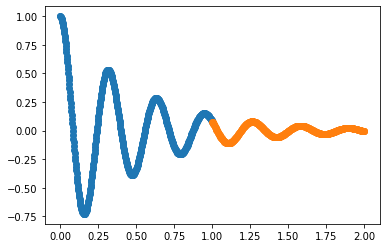

In [6]:

N = 100 # number of samples
y = oscillator(d, w0, x).astype(np.float32)
y_test =oscillator(d, w0, x_test).astype(np.float32)
print(x.shape,y.shape)
plt.scatter(x[1],y[1])
plt.scatter(x_test[1],y_test[1])

In [7]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [8]:
x = torch.linspace(0,1,500).requires_grad_()
x = x.repeat(100,1)
y = oscillator(d, w0, x)

In [9]:
class LSTM(nn.Module):
    
    def __init__(self, hidden_layers=64,outputs=1 ):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers).to(device)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers).to(device)
        self.linear = nn.Linear(self.hidden_layers, outputs).to(device)
        self.optimizer = torch.optim.LBFGS(self.parameters(), lr=1.0)
        self.optimizer_Adam = torch.optim.Adam(self.parameters(), lr=1e-3)
        
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        c_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        h_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        c_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2)# output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1).to(device)
        return outputs
    


2 min 

In [10]:
class PhysicsInformedNN():
    
    def __init__(self):
        # deep neural networks
        self.dnn = LSTM().to(device)
        
        
    def net_u(self,t,future_preds=0):  
        u = self.dnn.forward(t, future_preds)
        return u
    
    def derivates(self, u ,coordinates):
        
        coordinates = (coordinates.to(device),)
        u_t = torch.gradient(u, spacing = coordinates)[0].to(device) 
        u_tt = torch.gradient(u, spacing = coordinates)[0].to(device) 

        return u_t , u_tt
    
    def net_f(self,t,lambda1=4.0,lambda2=400.0):
        """ The pytorch autograd version of calculating residual """

        u = self.net_u(t)
        
        u_t = torch.zeros(len(u),len(u[0])).to(device)
        u_tt = torch.zeros(len(u),len(u[0])).to(device)
        
        coordinate_t = torch.linspace(0,1,len(u[0]))
        for i , time_serie in enumerate(u): 
            u_t[i], u_tt[i] =  self.derivates(time_serie, coordinate_t)
            
        f = u_tt + lambda1*u_t + lambda2*u
        return f.to(device), u , u_t , u_tt
    
    def predict(self, t,future_preds=0):
        self.dnn.eval()
        u = self.net_u(t,future_preds=0)
        return u 

In [11]:
model = PhysicsInformedNN()


(1e-9) y (1e-8) physics[,1:]
ok

muy buenos resultados con noise 0.1 y 29 iteraciones 

In [12]:
noise=0.1
y_with_noise = y + noise*torch.std(y)*torch.randn(size=x.size())

STEP:  0
loss: 0.14095766842365265
loss: 0.13147586584091187
loss: 0.1271255761384964
loss: 0.12636467814445496
loss: 0.1117173582315445
loss: 0.07537762075662613
loss: 0.016847021877765656
loss: 0.6640232801437378
loss: 0.010462801903486252
loss: 0.008625629357993603
loss: 0.007034628186374903
loss: 0.006955106742680073
loss: 0.006938643287867308
loss: 0.006410844624042511
loss: 0.0051294006407260895
loss: 0.0031771219801157713
loss: 0.0031849003862589598
loss: 0.002329347189515829
loss: 0.002268562326207757
loss: 0.0022452091798186302
Loss u: 2.175086e-03


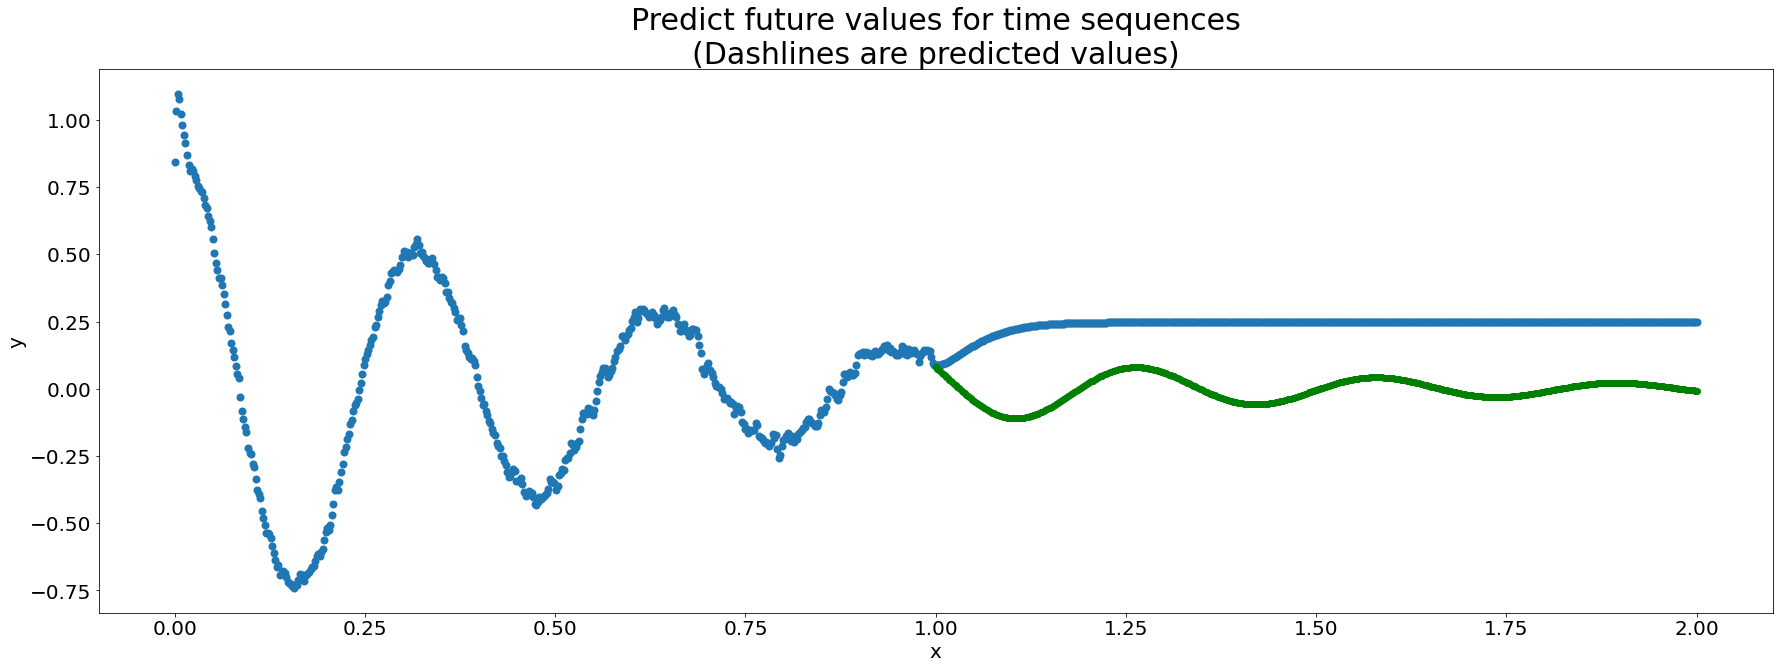

STEP:  1
loss: 0.002228332217782736
loss: 0.002223619492724538
loss: 0.0022223955020308495
loss: 0.0022141714580357075
loss: 0.0021985494531691074
loss: 0.002179661300033331
loss: 0.0021639857441186905
loss: 0.002159631811082363
loss: 0.0021591295953840017
loss: 0.002158388029783964
loss: 0.002156974049285054
loss: 0.002152802189812064
loss: 0.0021424817387014627
loss: 0.0021159923635423183
loss: 0.002066313289105892
loss: 0.002054600277915597
loss: 0.0020770560950040817
loss: 0.002050535287708044
loss: 0.002045354573056102
loss: 0.0020403126254677773
Loss u: 1.973811e-03


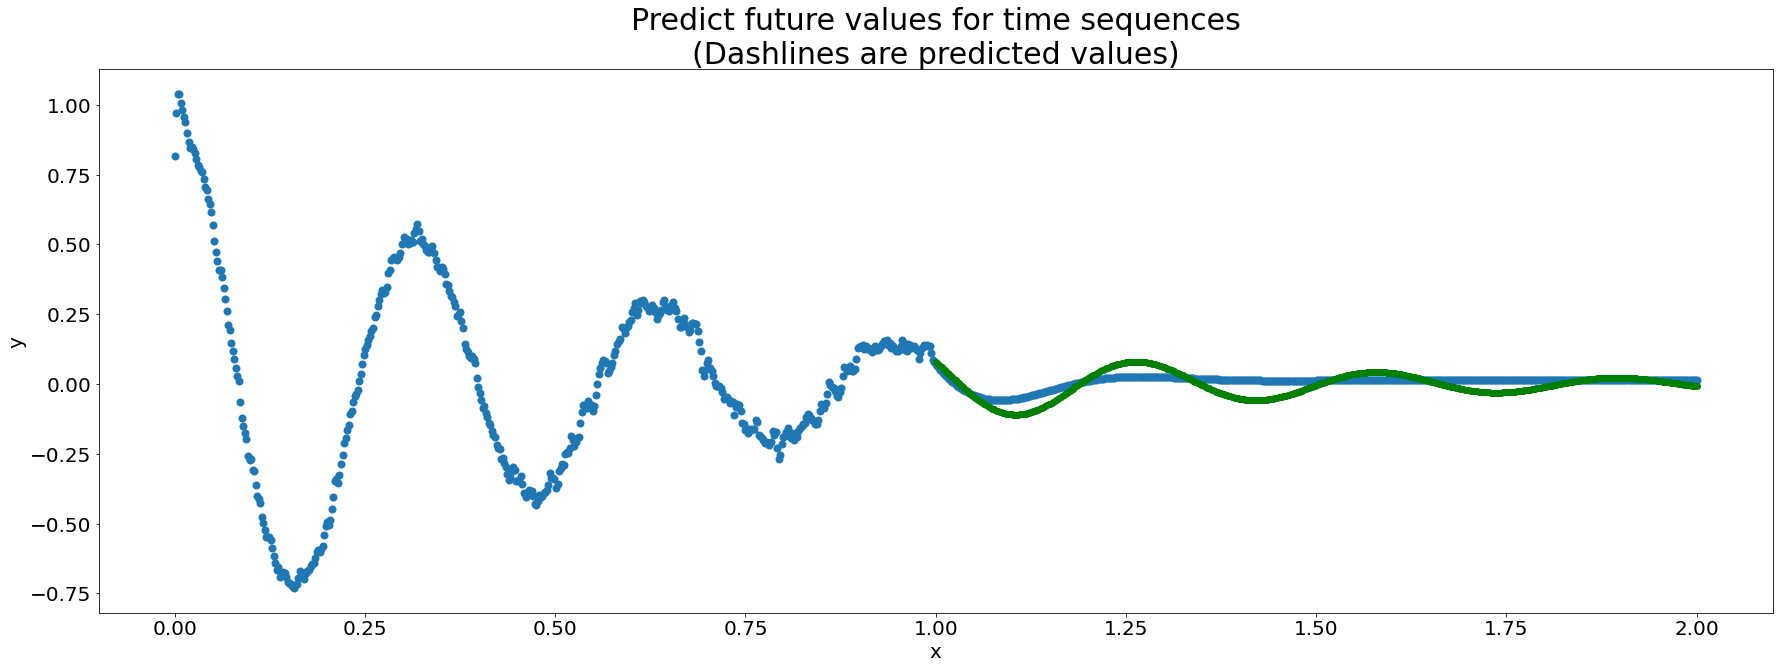

STEP:  2
loss: 0.0020387759432196617
loss: 0.002037803176790476
loss: 0.0020375698804855347
loss: 0.0020373761653900146
loss: 0.0020366485696285963
loss: 0.0020353856962174177
loss: 0.0020315549336373806
loss: 0.0020217527635395527
loss: 0.001993345096707344
loss: 0.002076319884508848
loss: 0.0019774814136326313
loss: 0.0019816739950329065
loss: 0.001934815663844347
loss: 0.0019174872431904078
loss: 0.0019099655328318477
loss: 0.00190929532982409
loss: 0.0019069688860327005
loss: 0.0019063286017626524
loss: 0.0019043289357796311
loss: 0.0018993030535057187
Loss u: 1.854367e-03


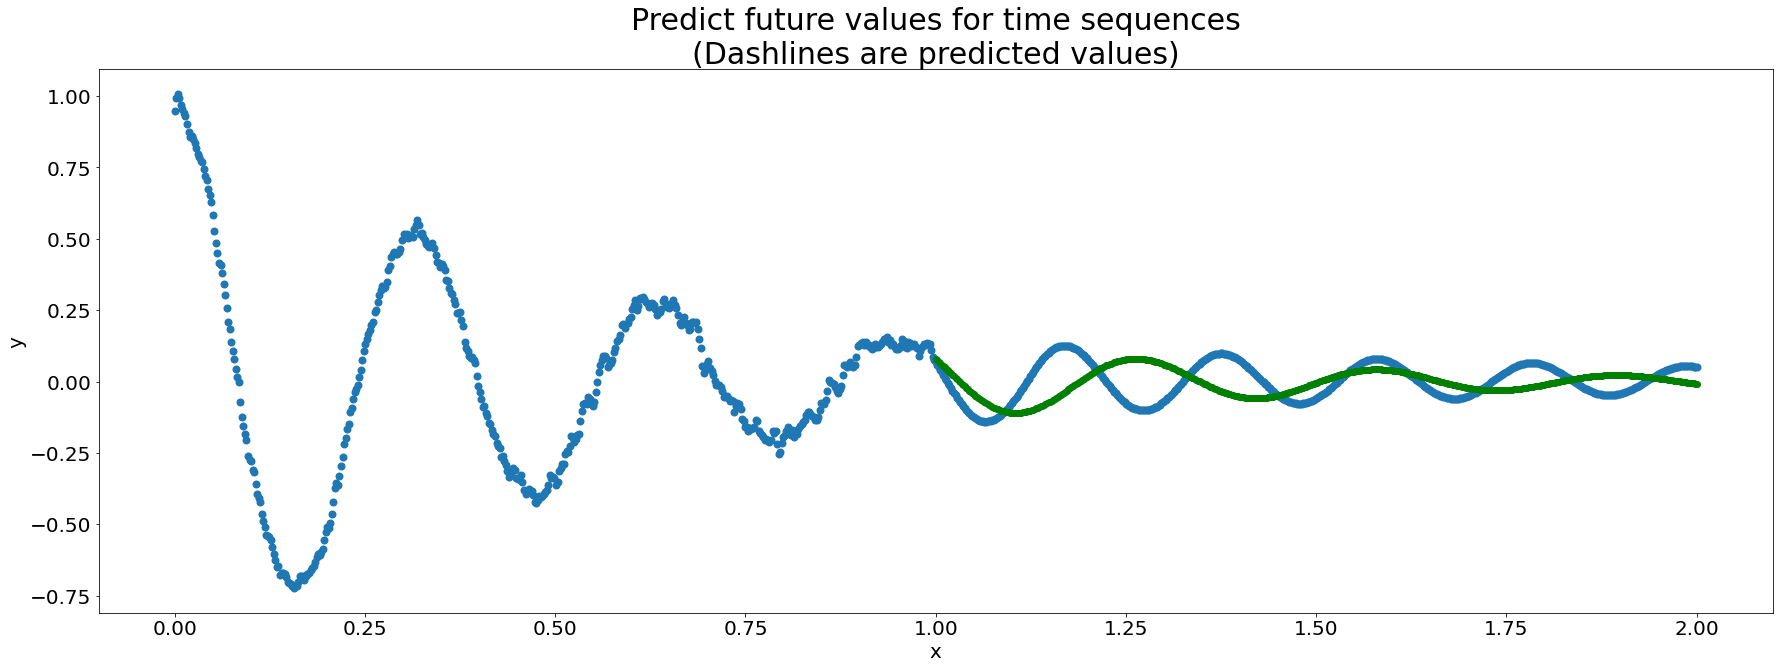

STEP:  3
loss: 0.0018962138565257192
loss: 0.0018850881606340408
loss: 0.0018757538637146354
loss: 0.001869463943876326
loss: 0.0018691547447815537
loss: 0.0018656039610505104
loss: 0.0018625663360580802
loss: 0.001859700190834701
loss: 0.0018529245862737298
loss: 0.001845779363065958
loss: 0.0018307807622477412
loss: 0.0018223634688183665
loss: 0.0018015773966908455
loss: 0.0017866091802716255
loss: 0.0018236757023259997
loss: 0.0018696722108870745
loss: 0.0017868925351649523
loss: 0.001762579777278006
loss: 0.001733642304316163
loss: 0.0017176190158352256
Loss u: 1.699773e-03


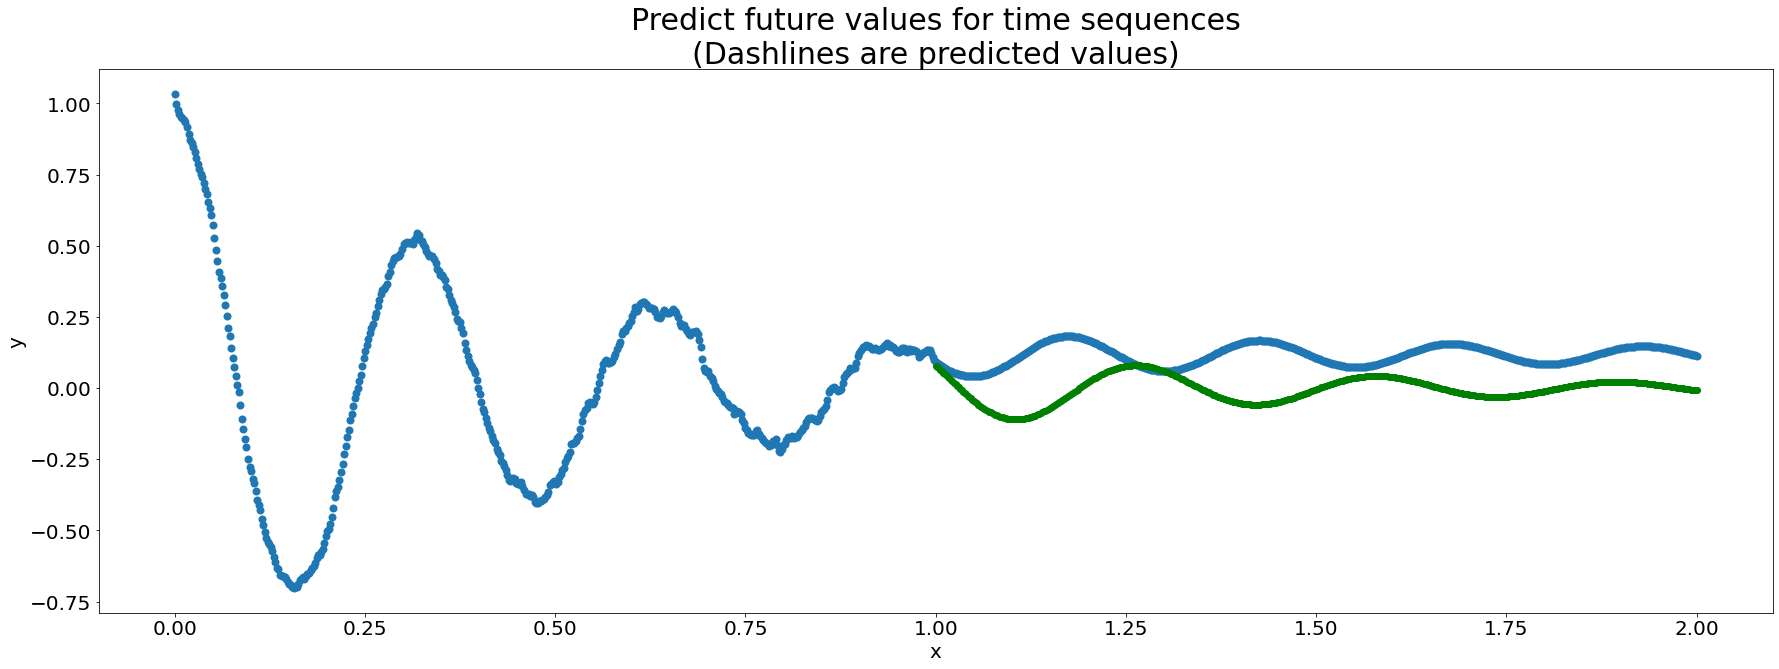

STEP:  4
loss: 0.0017270866082981229
loss: 0.0017043291591107845
loss: 0.0016990581061691046
loss: 0.0018123346380889416
loss: 0.0016963464440777898
loss: 0.0016941223293542862
loss: 0.0017257108120247722
loss: 0.0016882197232916951
loss: 0.0016840898897498846
loss: 0.002063772641122341
loss: 0.0016811559908092022
loss: 0.001678883214481175
loss: 0.0016764268511906266
loss: 0.0016665675211697817
loss: 0.0016605884302407503
loss: 0.0016938330372795463
loss: 0.001656681764870882
loss: 0.0016541329678148031
loss: 0.0016774269752204418
loss: 0.0016484904335811734
Loss u: 1.614756e-03


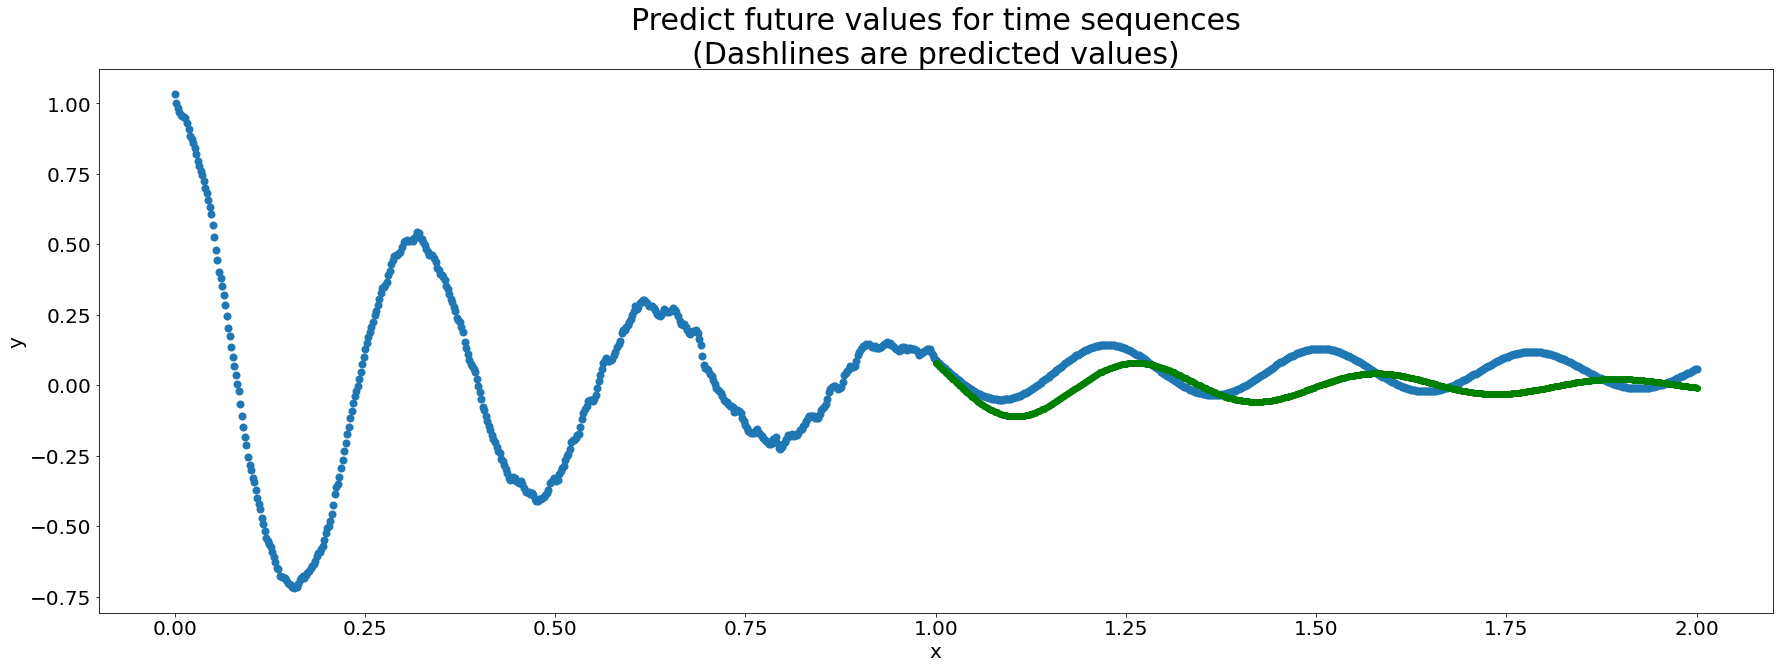

STEP:  5
loss: 0.0016449609538540244
loss: 0.0017050914466381073
loss: 0.0016392491525039077
loss: 0.0016352958045899868
loss: 0.0019795377738773823
loss: 0.0016322486335411668
loss: 0.0016298340633511543
loss: 0.0016774999676272273
loss: 0.001624362776055932
loss: 0.0016210111789405346
loss: 0.0016131401062011719
loss: 0.0017128767212852836
loss: 0.00161093904171139
loss: 0.0016092953737825155
loss: 0.0016139913350343704
loss: 0.0016055544838309288
loss: 0.0016041347989812493
loss: 0.0016024268697947264
loss: 0.0016013019485399127
loss: 0.0015986578073352575
Loss u: 1.573836e-03


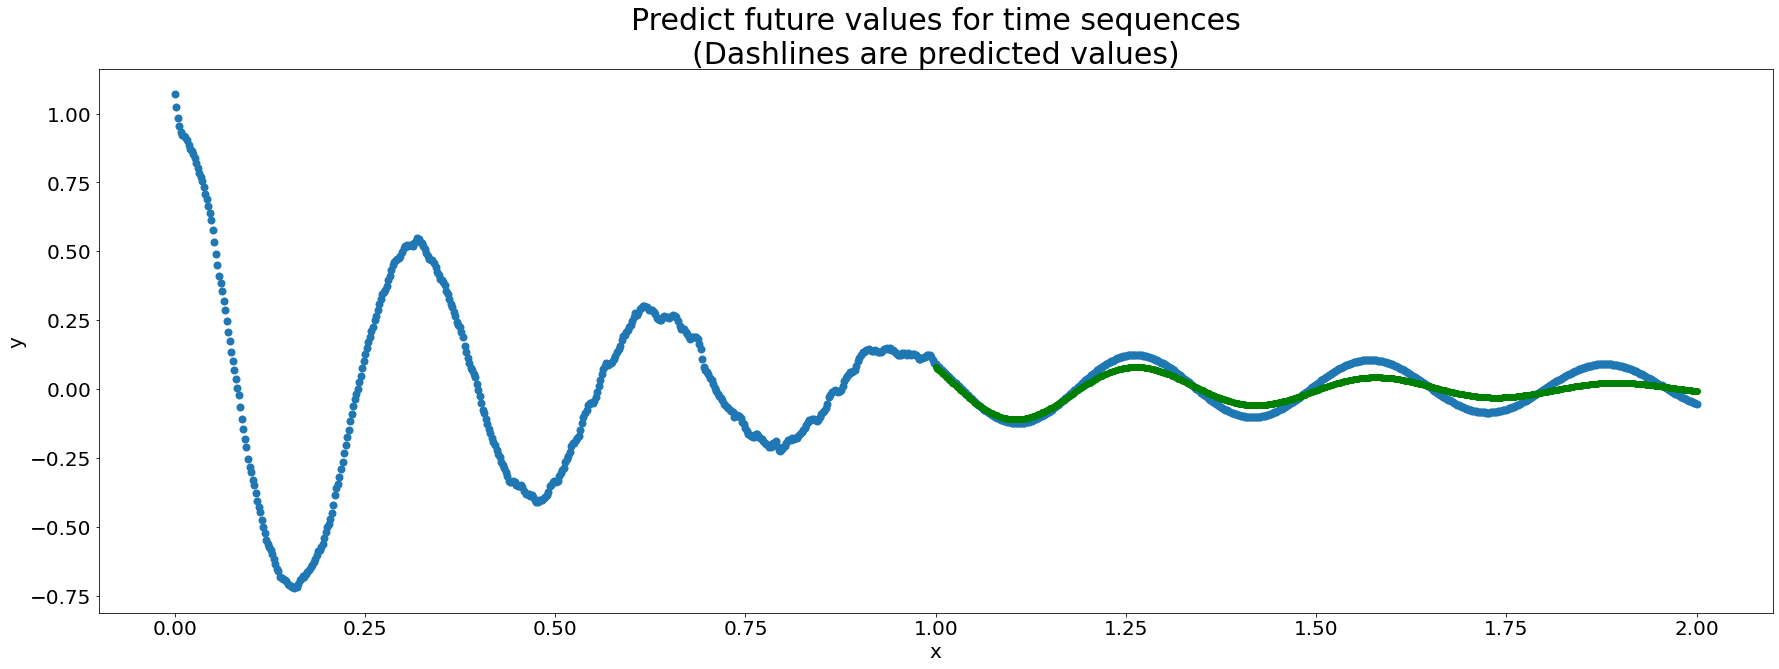

STEP:  6
loss: 0.0015949145890772343
loss: 0.0015936600975692272
loss: 0.0015908523928374052
loss: 0.0015888722846284509
loss: 0.001631779014132917
loss: 0.001586281694471836
loss: 0.0015849320916458964
loss: 0.001582775148563087
loss: 0.0015819284599274397
loss: 0.001580603769980371
loss: 0.001579861156642437
loss: 0.00157846137881279
loss: 0.0015778950182721019
loss: 0.0015772776678204536
loss: 0.00157629803288728
loss: 0.0015749623998999596
loss: 0.0015729956794530153
loss: 0.00156911532394588
loss: 0.0015664229867979884
loss: 0.0015661384677514434
Loss u: 1.543362e-03


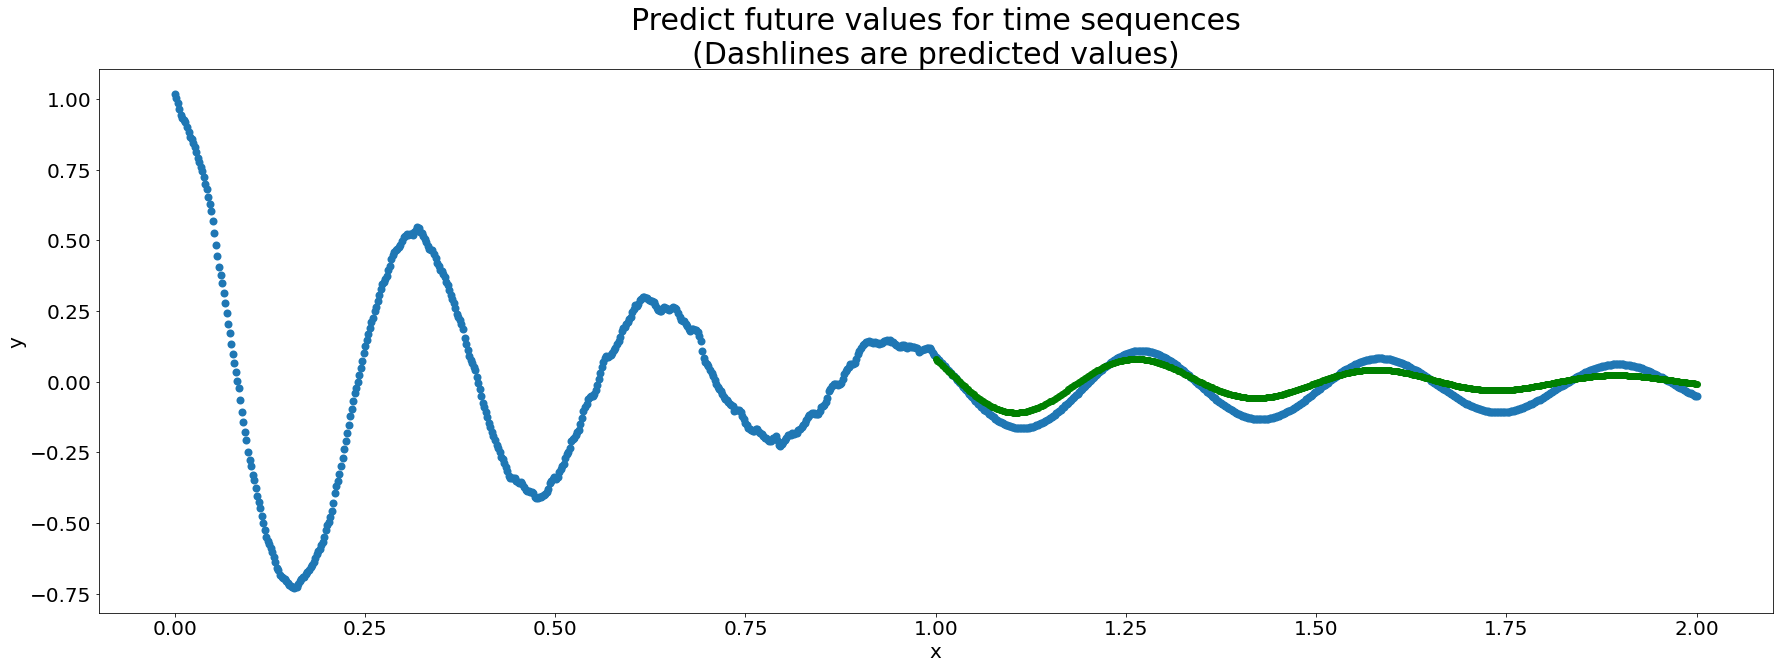

STEP:  7
loss: 0.0015700669027864933
loss: 0.0015600664773955941
loss: 0.0015577167505398393
loss: 0.0015581970801576972
loss: 0.0015553670236840844
loss: 0.0015546572394669056
loss: 0.001554126967675984
loss: 0.0015536387218162417
loss: 0.0015528221847489476
loss: 0.0015509743243455887
loss: 0.0015856069512665272
loss: 0.001550368731841445
loss: 0.0015499547589570284
loss: 0.0015486000338569283
loss: 0.0015504417242482305
loss: 0.0015476301778107882
loss: 0.0015472513623535633
loss: 0.0015487686032429338
loss: 0.0015462159644812346
loss: 0.0015456208493560553
Loss u: 1.523042e-03


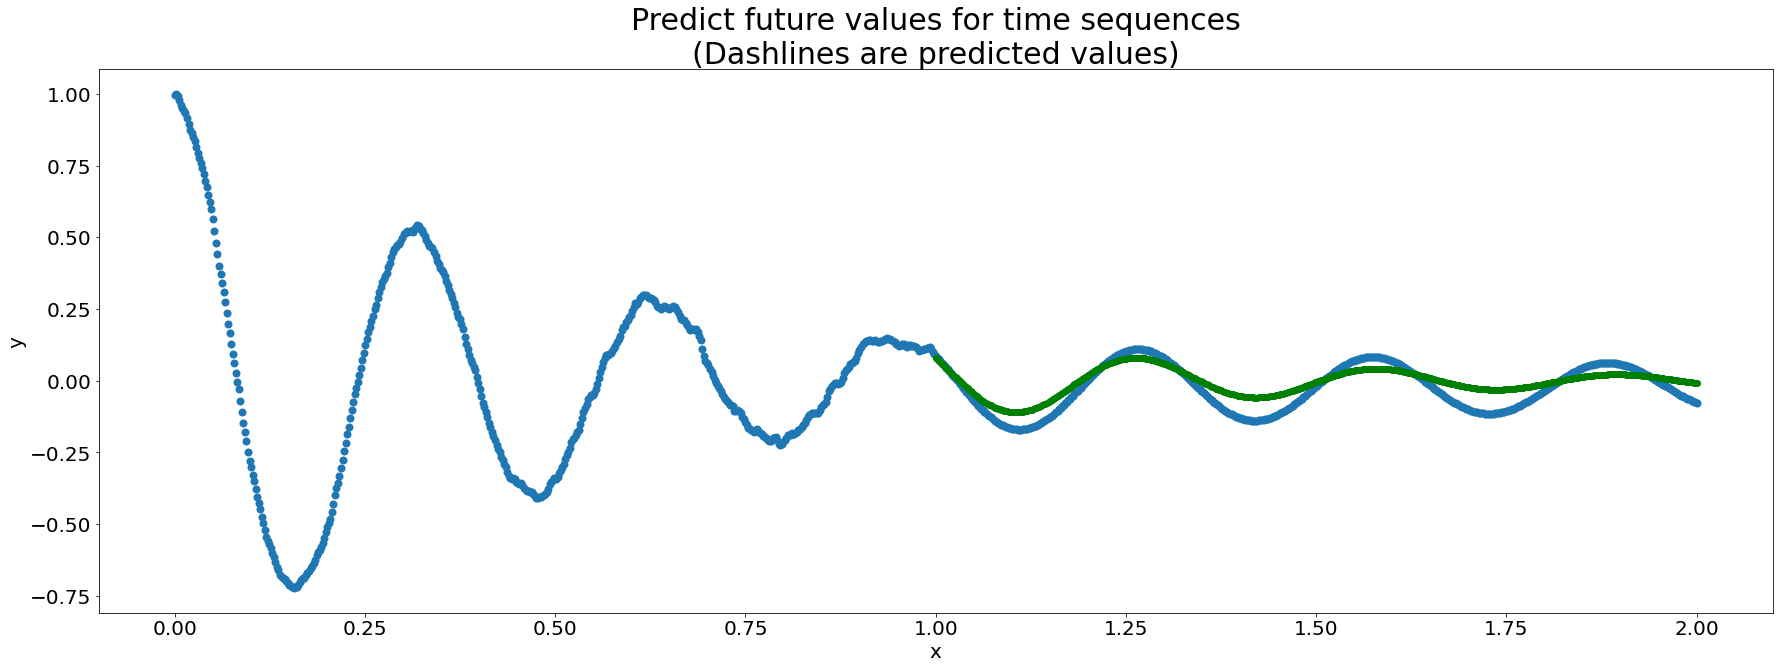

STEP:  8
loss: 0.001555172842927277
loss: 0.0015444000018760562
loss: 0.0015436871908605099
loss: 0.0016180984675884247
loss: 0.0015431977808475494
loss: 0.0015428217593580484
loss: 0.0016902085626497865
loss: 0.0015424845041707158
loss: 0.0015421847347170115
loss: 0.0015396192902699113
loss: 0.0015419288538396358
loss: 0.001537709729745984
loss: 0.0015371677000075579
loss: 0.0015367974992841482
loss: 0.0015359196113422513
loss: 0.0015356338117271662
loss: 0.0015349924797192216
loss: 0.0015343076083809137
loss: 0.0015338573139160872
loss: 0.0015334615018218756
Loss u: 1.503240e-03


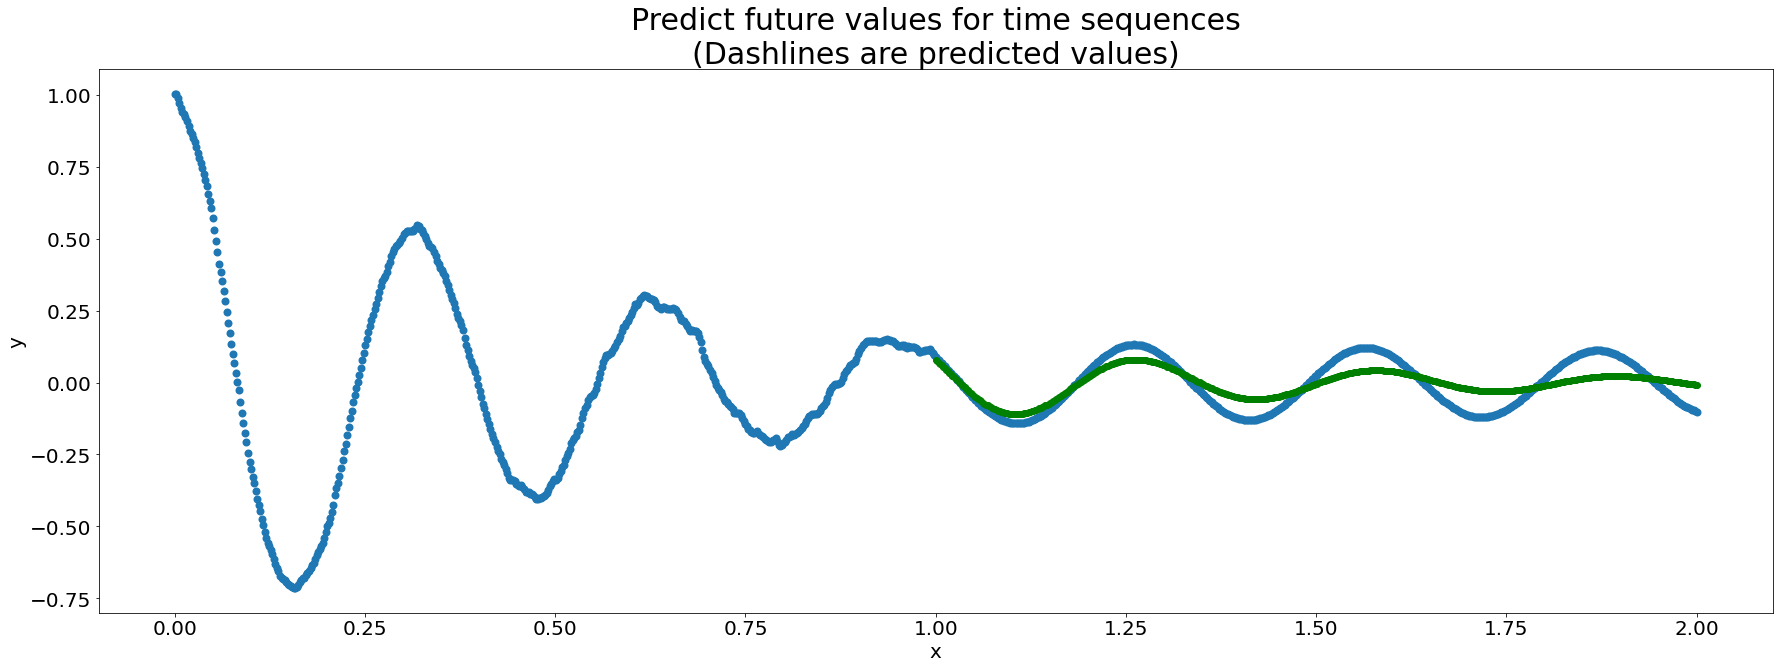

STEP:  9
loss: 0.0015332779148593545
loss: 0.0015328621957451105
loss: 0.0015316703356802464
loss: 0.001533527742139995
loss: 0.0015288081485778093
loss: 0.0015264521352946758
loss: 0.001534507144242525
loss: 0.0015252031153067946
loss: 0.001524433377198875
loss: 0.0015224680537357926
loss: 0.0015216120518743992
loss: 0.0015210523270070553
loss: 0.0015204534865915775
loss: 0.0015201445203274488
loss: 0.0015198967885226011
loss: 0.0015181174967437983
loss: 0.0017718198942020535
loss: 0.0015176875749602914
loss: 0.001521083409897983
loss: 0.0015134350396692753
Loss u: 1.481972e-03


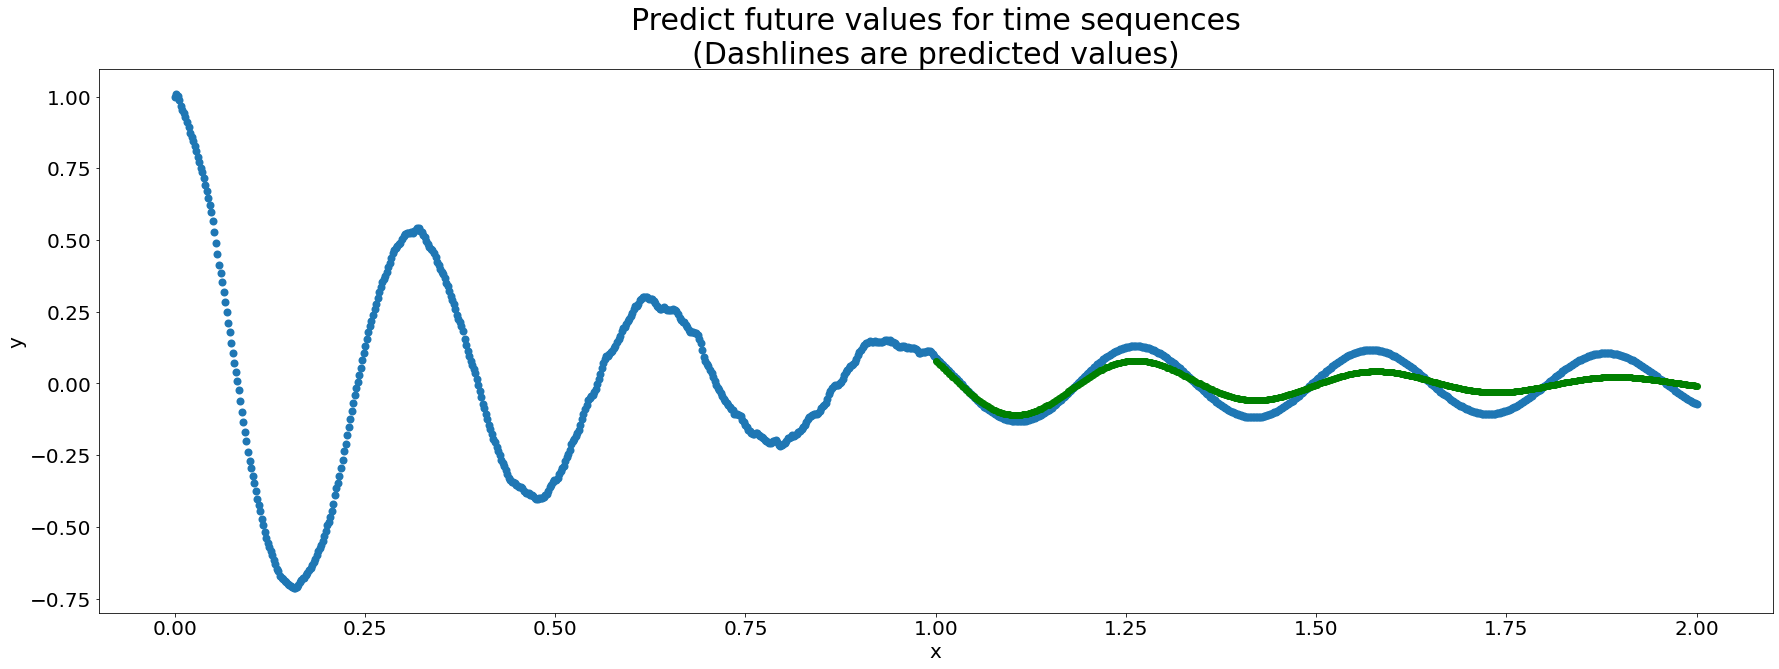

STEP:  10
loss: 0.0015113677363842726
loss: 0.0015090039232745767
loss: 0.0015085831983014941
loss: 0.0015033857198432088
loss: 0.0014997825492173433
loss: 0.001558359363116324
loss: 0.0014986019814386964
loss: 0.0014980738051235676
loss: 0.0014963246649131179
loss: 0.0014936338411644101
loss: 0.0014917377848178148
loss: 0.0014901460381224751
loss: 0.0014887785073369741
loss: 0.0014871847815811634
loss: 0.0014856362249702215
loss: 0.0014842399396002293
loss: 0.0014832274755463004
loss: 0.001482563093304634
loss: 0.001482687541283667
loss: 0.001481836661696434
Loss u: 1.445761e-03


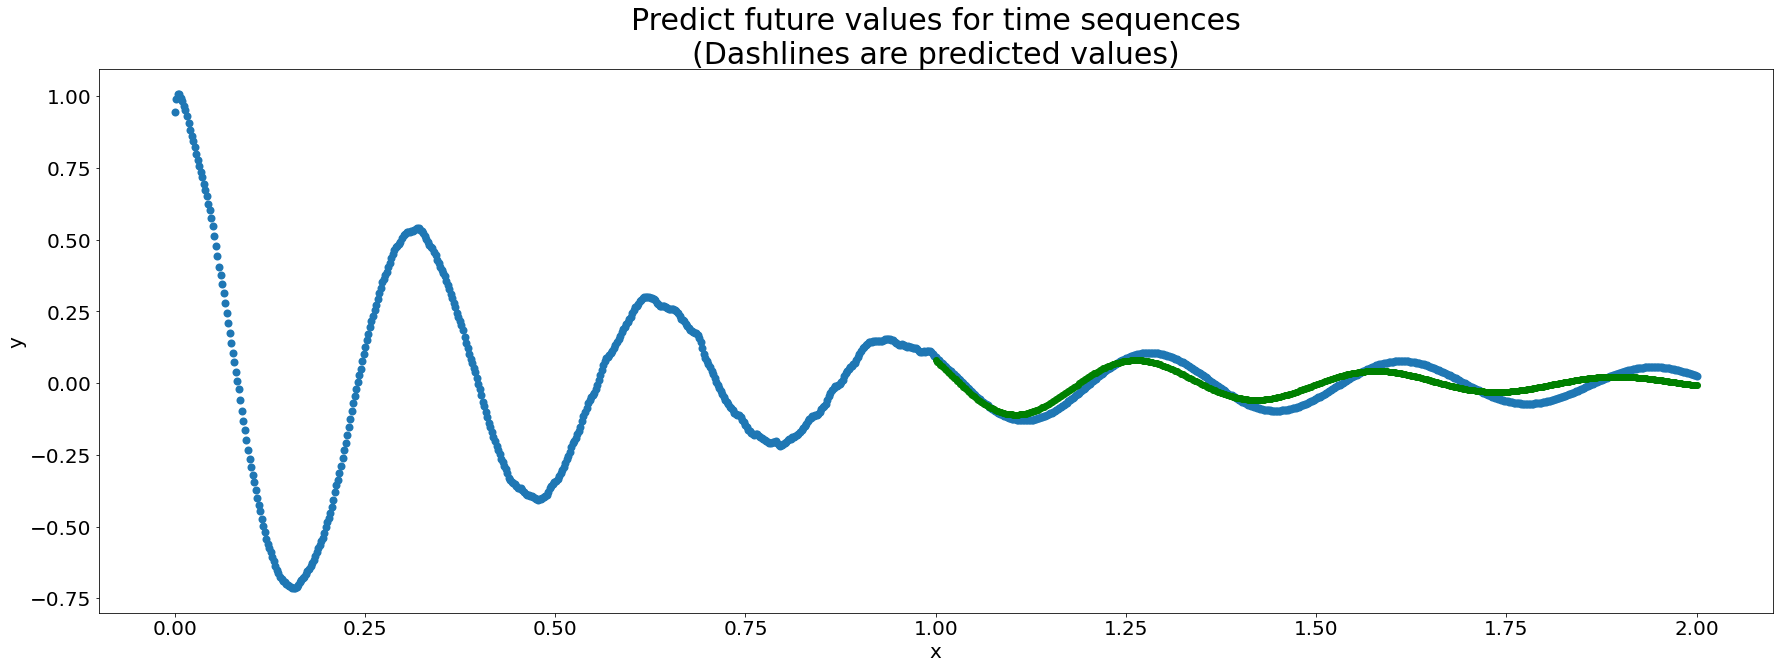

STEP:  11
loss: 0.0014817899791523814
loss: 0.0014817521441727877
loss: 0.0014817252522334456
loss: 0.001481652376241982
loss: 0.0014811689034104347
loss: 0.001588664366863668
loss: 0.0014805850805714726
loss: 0.0014802123187109828
loss: 0.0014794250018894672
loss: 0.0014786854153499007
loss: 0.0014782838989049196
loss: 0.0014782085781916976
loss: 0.0014772473368793726
loss: 0.001476734527386725
loss: 0.001691487617790699
loss: 0.0014763487270101905
loss: 0.0014761128695681691
loss: 0.0014761529164388776
loss: 0.0014748076209798455
loss: 0.0014740091282874346
Loss u: 1.416870e-02


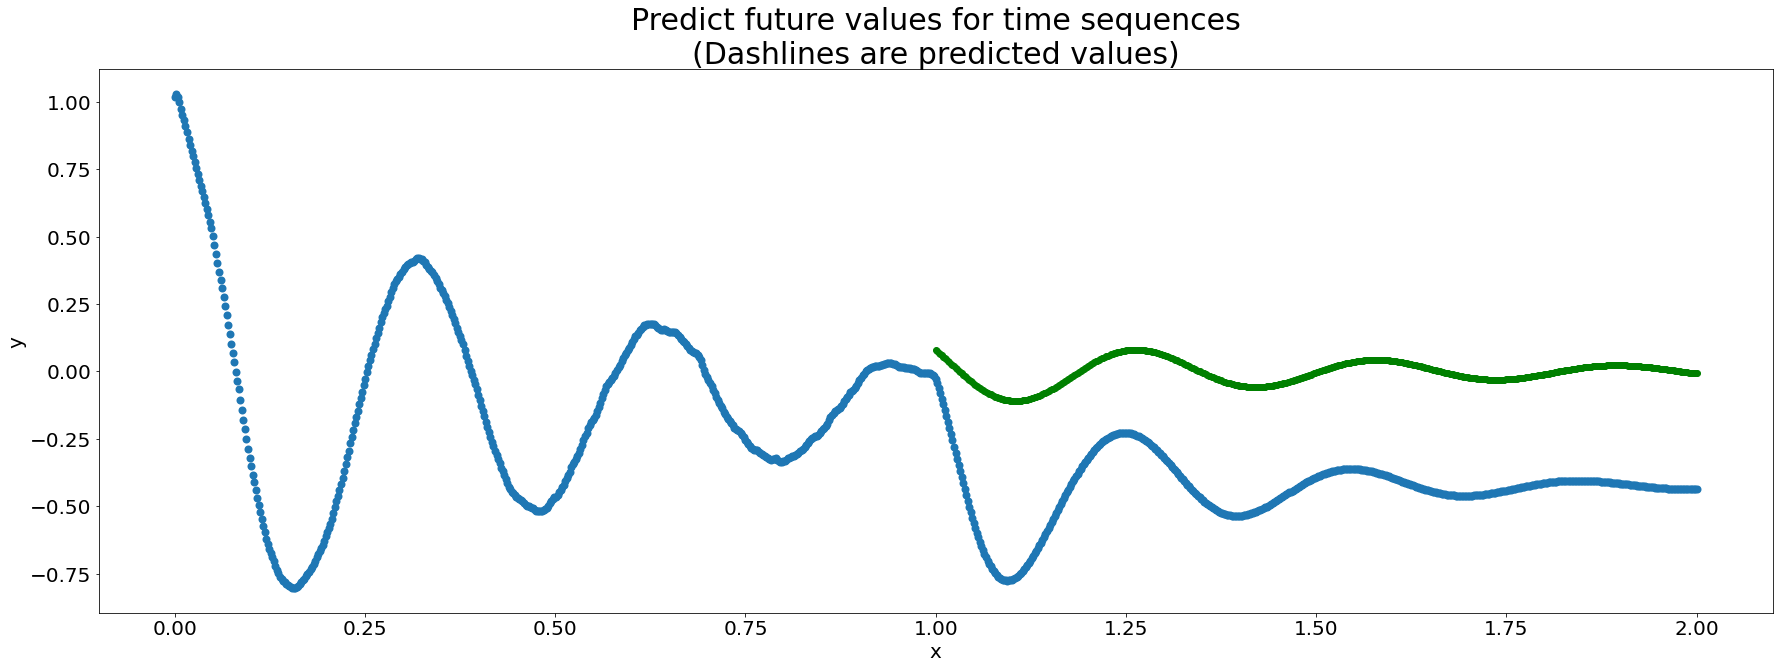

STEP:  12
loss: 0.014139488339424133
loss: 0.001473795622587204
loss: 0.0014736867742612958
loss: 0.0014733447460457683
loss: 0.0014732201816514134
loss: 0.001473081880249083
loss: 0.001472984324209392
loss: 0.0014728656969964504
loss: 0.001472610980272293
loss: 0.0014720737235620618
loss: 0.0014707462396472692
loss: 0.0014693934936076403
loss: 0.0014674729900434613
loss: 0.00146432314068079
loss: 0.0014637823915109038
loss: 0.0014631362864747643
loss: 0.001468840055167675
loss: 0.0014633859973400831
loss: 0.0014645075425505638
loss: 0.0014618625864386559
Loss u: 1.425068e-03


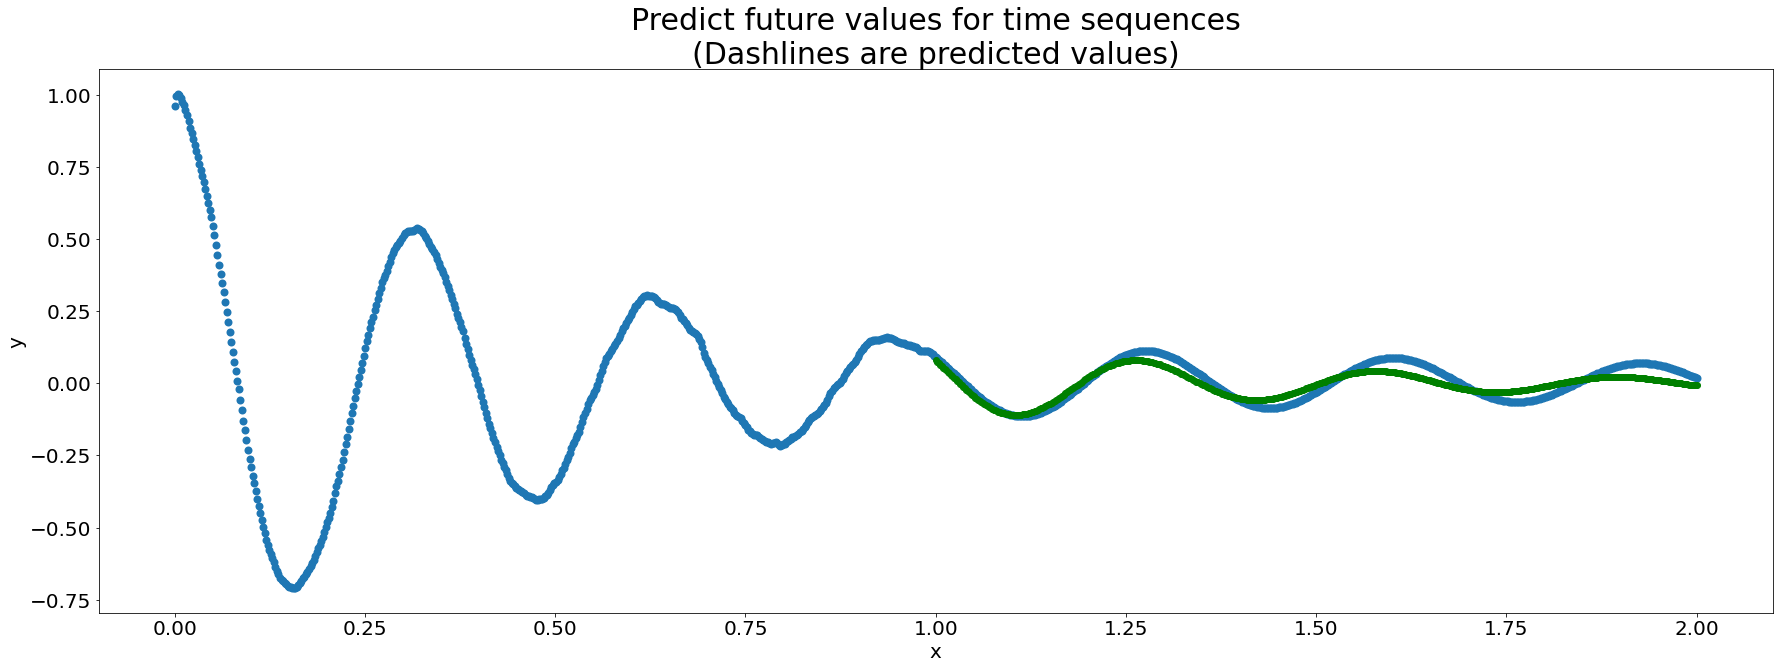

STEP:  13
loss: 0.0014614565297961235
loss: 0.0014609534991905093
loss: 0.0014606406912207603
loss: 0.0014601160073652864
loss: 0.001459464430809021
loss: 0.0014588937629014254
loss: 0.0014578414848074317
loss: 0.0014573128428310156
loss: 0.0014569269260391593
loss: 0.0014565937453880906
loss: 0.0014561545103788376
loss: 0.0014542842982336879
loss: 0.0014585864264518023
loss: 0.0014605254400521517
loss: 0.0014689574018120766
loss: 0.00146167550701648
loss: 0.0014704422792419791
loss: 0.0014543670695275068
loss: 0.0014532586792483926
loss: 0.0014526189770549536
Loss u: 1.415137e-03


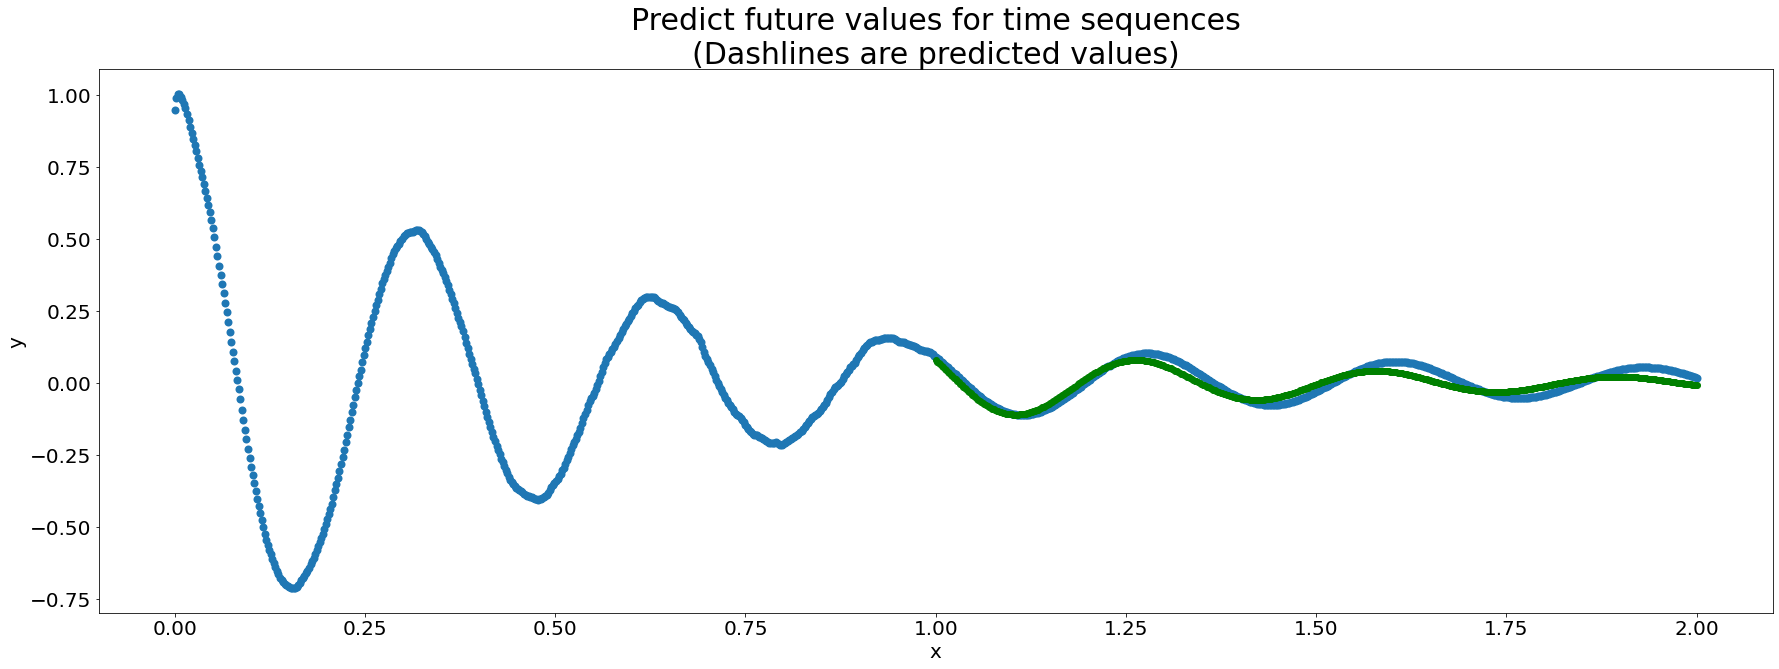

STEP:  14
loss: 0.0014514378271996975
loss: 0.001451746211387217
loss: 0.0014492591144517064
loss: 0.0014482963597401977
loss: 0.0014657615683972836
loss: 0.001447585178539157
loss: 0.0014476613141596317
loss: 0.0014466627035290003
loss: 0.0014465423300862312
loss: 0.0014457455836236477
loss: 0.0014454539632424712
loss: 0.001445084111765027
loss: 0.0014447243884205818
loss: 0.0014442773535847664
loss: 0.0014439983060583472
loss: 0.001443734741769731
loss: 0.0014435863122344017
loss: 0.0014430452138185501
loss: 0.0014425108674913645
loss: 0.0014418255304917693
Loss u: 1.409453e-03


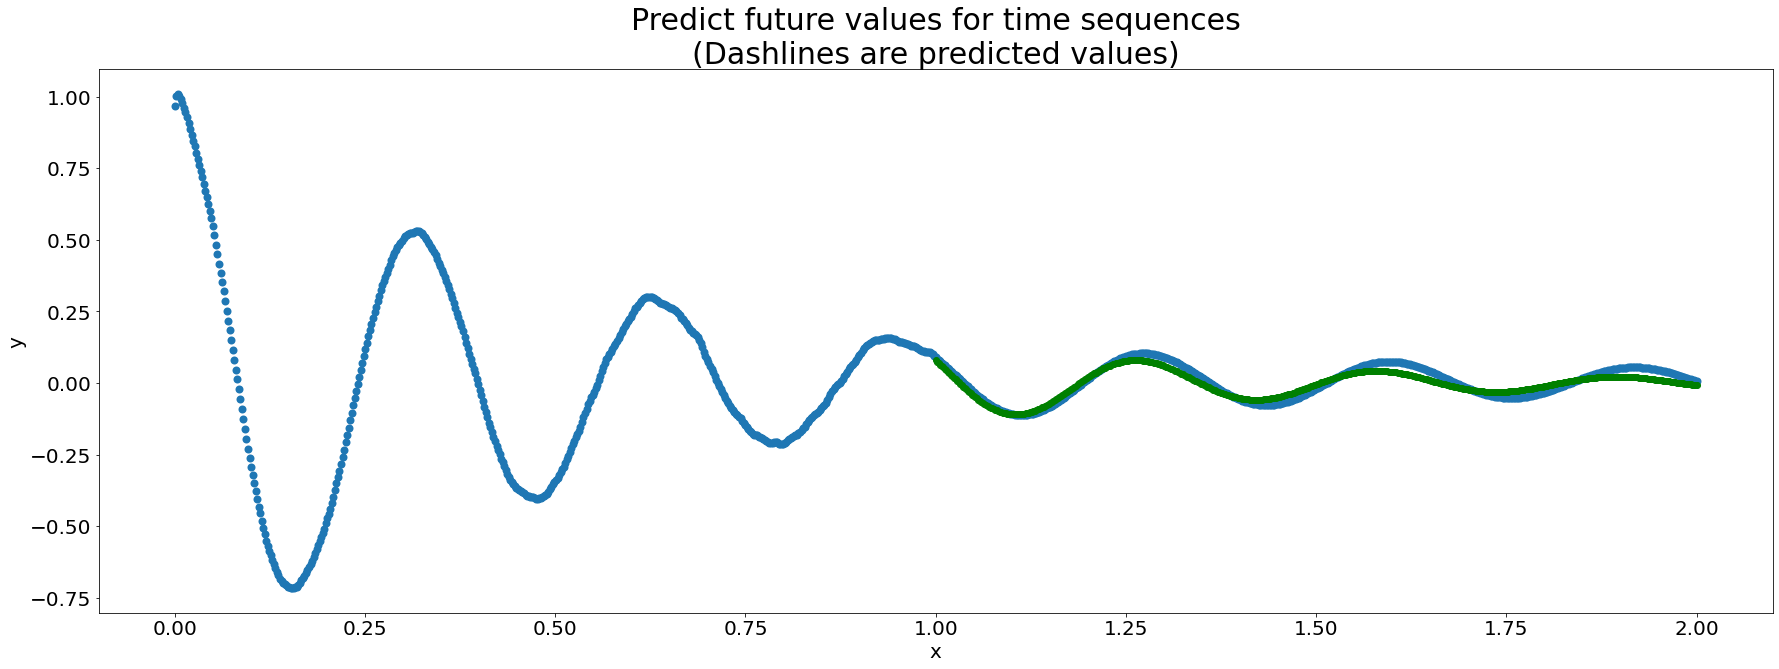

STEP:  15
loss: 0.0014407712733373046
loss: 0.0014474076451733708
loss: 0.00144107430242002
loss: 0.0014419574290513992
loss: 0.0014395046746358275
loss: 0.0014387101400643587
loss: 0.0014390787109732628
loss: 0.0014380248030647635
loss: 0.0014375215396285057
loss: 0.08780870586633682
loss: 0.001437233411706984
loss: 0.0014371348079293966
loss: 0.0014369998825713992
loss: 0.0014368030242621899
loss: 0.001436638180166483
loss: 0.001439503743313253
loss: 0.0014356147730723023
loss: 0.0014348560944199562
loss: 0.0015106201171875
loss: 0.0014344978844746947
Loss u: 1.404612e-03


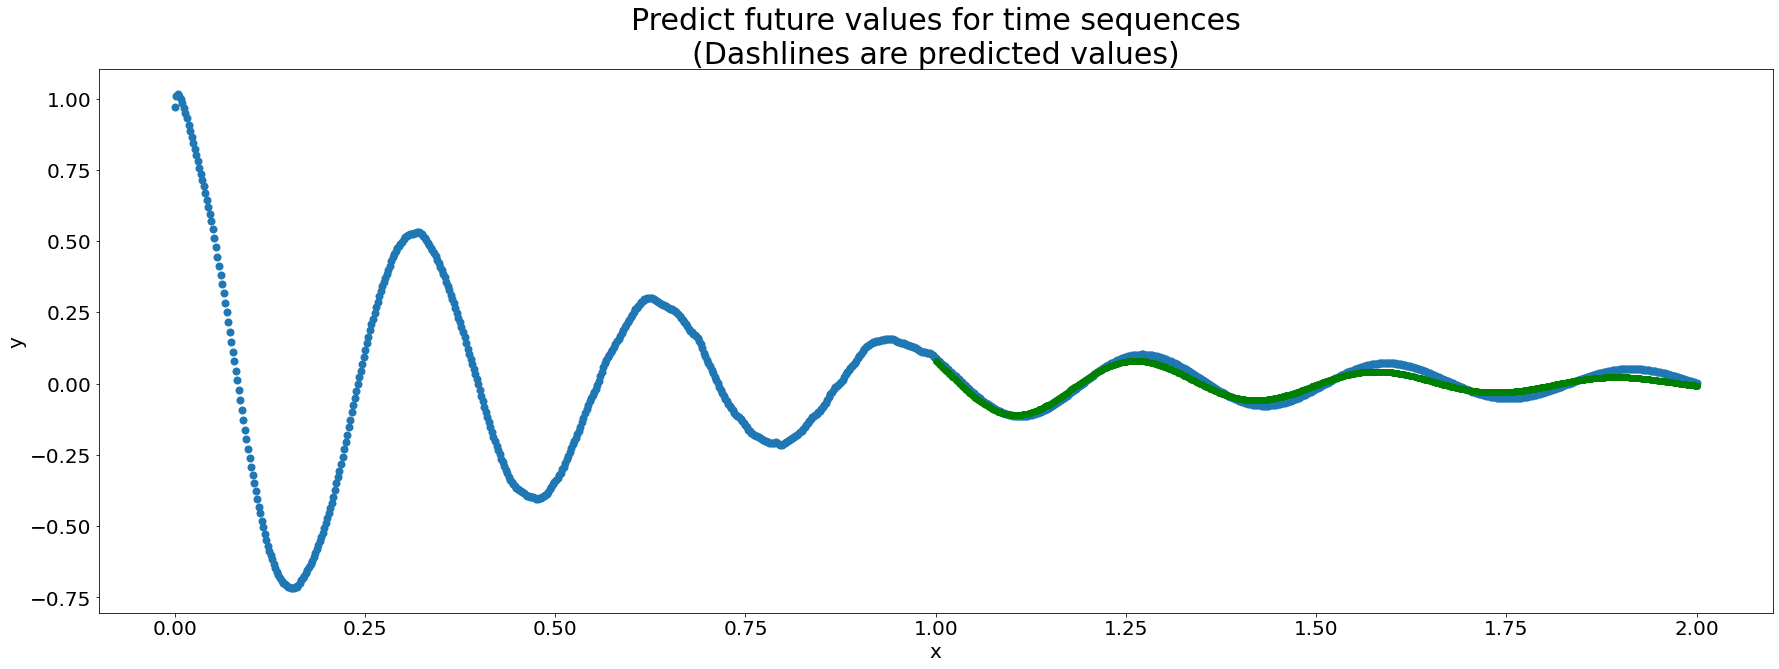

STEP:  16
loss: 0.0014342893846333027
loss: 0.001433563302271068
loss: 0.0014331929851323366
loss: 0.0014328045072034001
loss: 0.001432429300621152
loss: 0.0014320133486762643
loss: 0.001431128242984414
loss: 0.0014305106597021222
loss: 0.0014301041373983026
loss: 0.001428750460036099
loss: 0.0014290630351752043
loss: 0.0014282972551882267
loss: 0.0014282949268817902
loss: 0.0014277619775384665
loss: 0.0014275946887210011
loss: 0.0014273346168920398
loss: 0.0014269050443544984
loss: 0.001426425646059215
loss: 0.0014270507963374257
loss: 0.0014261273900046945
Loss u: 1.398678e-03


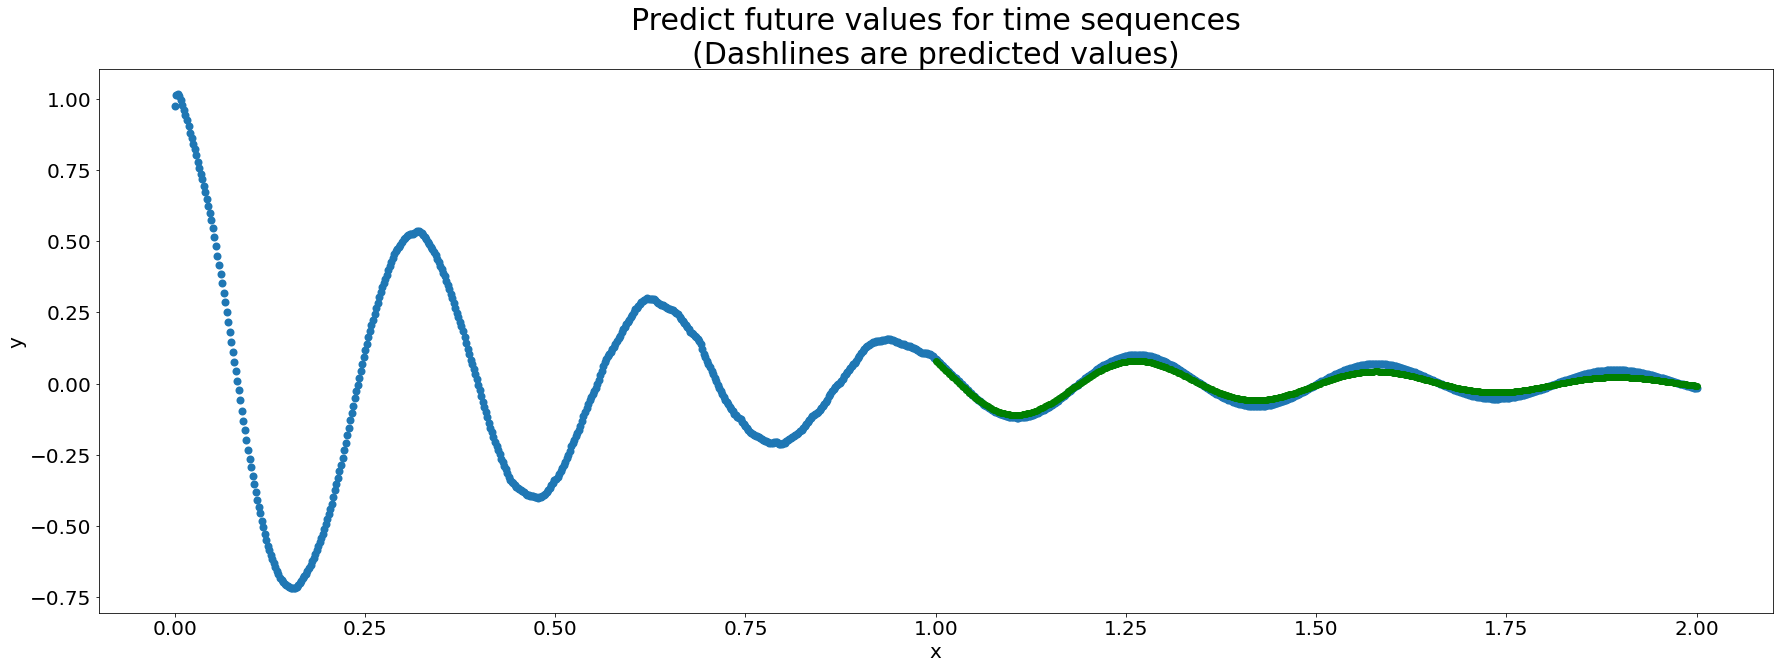

STEP:  17
loss: 0.0014259123709052801
loss: 0.0014257020084187388
loss: 0.0014255582354962826
loss: 0.0014252678956836462
loss: 0.0014246383216232061
loss: 0.0014384243404492736
loss: 0.0014242862816900015
loss: 0.0014240522868931293
loss: 7.149905204772949
loss: 0.0014238923322409391
loss: 0.001423836569301784
loss: 0.0014237127033993602
loss: 0.001423364388756454
loss: 0.001422983012162149
loss: 0.0014222686877474189
loss: 0.0014211410889402032
loss: 0.0014192253584042192
loss: 0.001709546777419746
loss: 0.0014192432863637805
loss: 0.001421081949956715
Loss u: 1.392009e-03


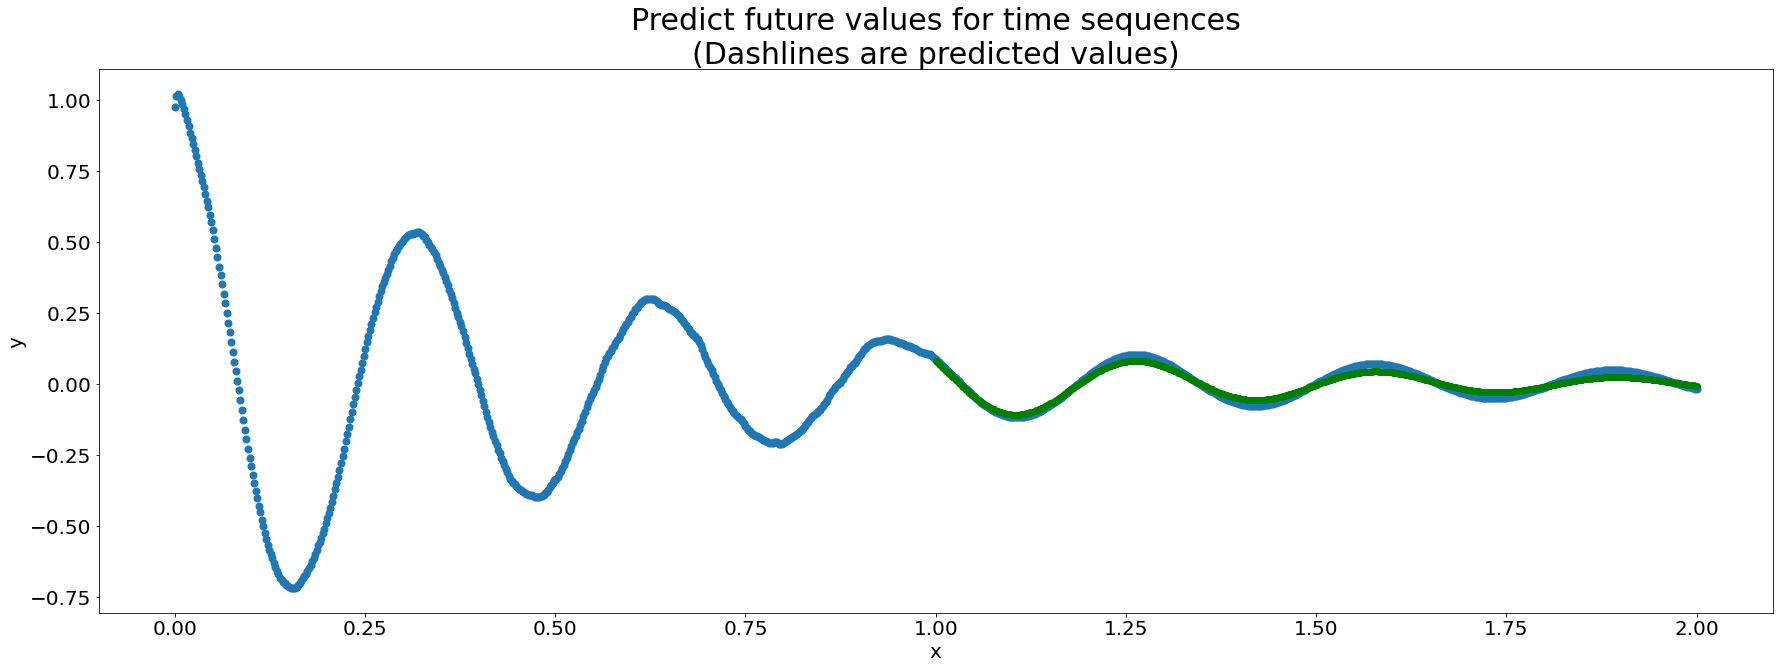

STEP:  18
loss: 0.001419372740201652
loss: 0.0014202776364982128
loss: 0.0014183612074702978
loss: 0.001418211148120463
loss: 0.0014175896067172289
loss: 0.0014168339548632503
loss: 0.0014147215988487005
loss: 0.0014146779431030154
loss: 0.0014175203396007419
loss: 0.0014239957090467215
loss: 0.0014134695520624518
loss: 0.0014163926243782043
loss: 0.001411151373758912
loss: 0.0014101547421887517
loss: 0.0014116645324975252
loss: 0.001408555544912815
loss: 0.0014080432010814548
loss: 0.0014078665990382433
loss: 0.0014075525104999542
loss: 0.0014076480874791741
Loss u: 1.373247e-03


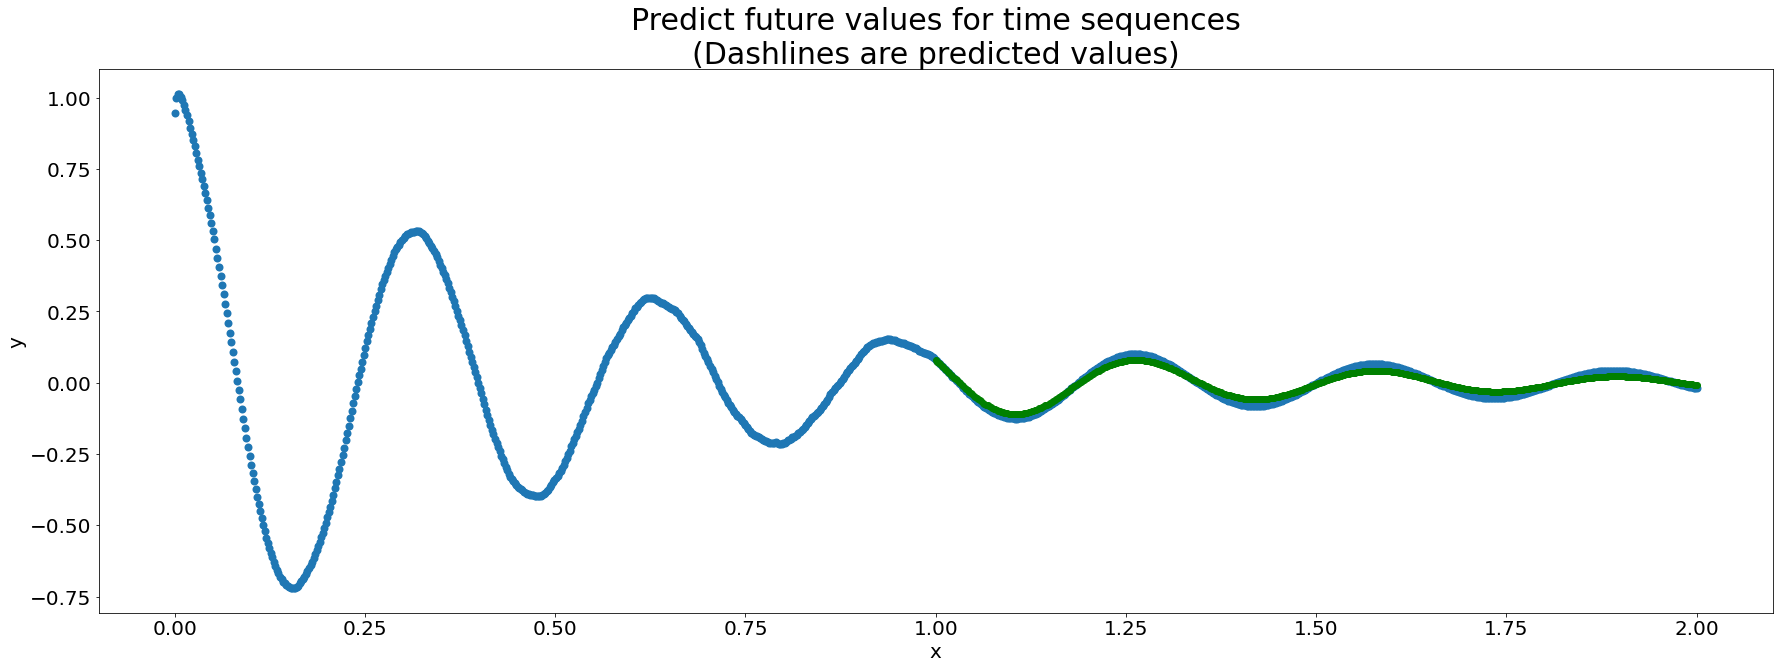

STEP:  19
loss: 0.0014074300415813923
loss: 0.0014073798665776849
loss: 0.001407317933626473
loss: 0.0014070948818698525
loss: 0.0014070363249629736
loss: 0.0014069968601688743
loss: 0.0014069657772779465
loss: 0.0014069530880078673
loss: 0.0014069417957216501
loss: 0.0014069315511733294
loss: 0.0014069033786654472
loss: 0.0014068355085328221
loss: 0.001406670082360506
loss: 0.0014063168782740831
loss: 0.0014086209703236818
loss: 0.00140671047847718
loss: 0.0014142137952148914
loss: 0.0014063528506085277
loss: 0.0014057103544473648
loss: 0.0014053427148610353
Loss u: 1.373846e-03


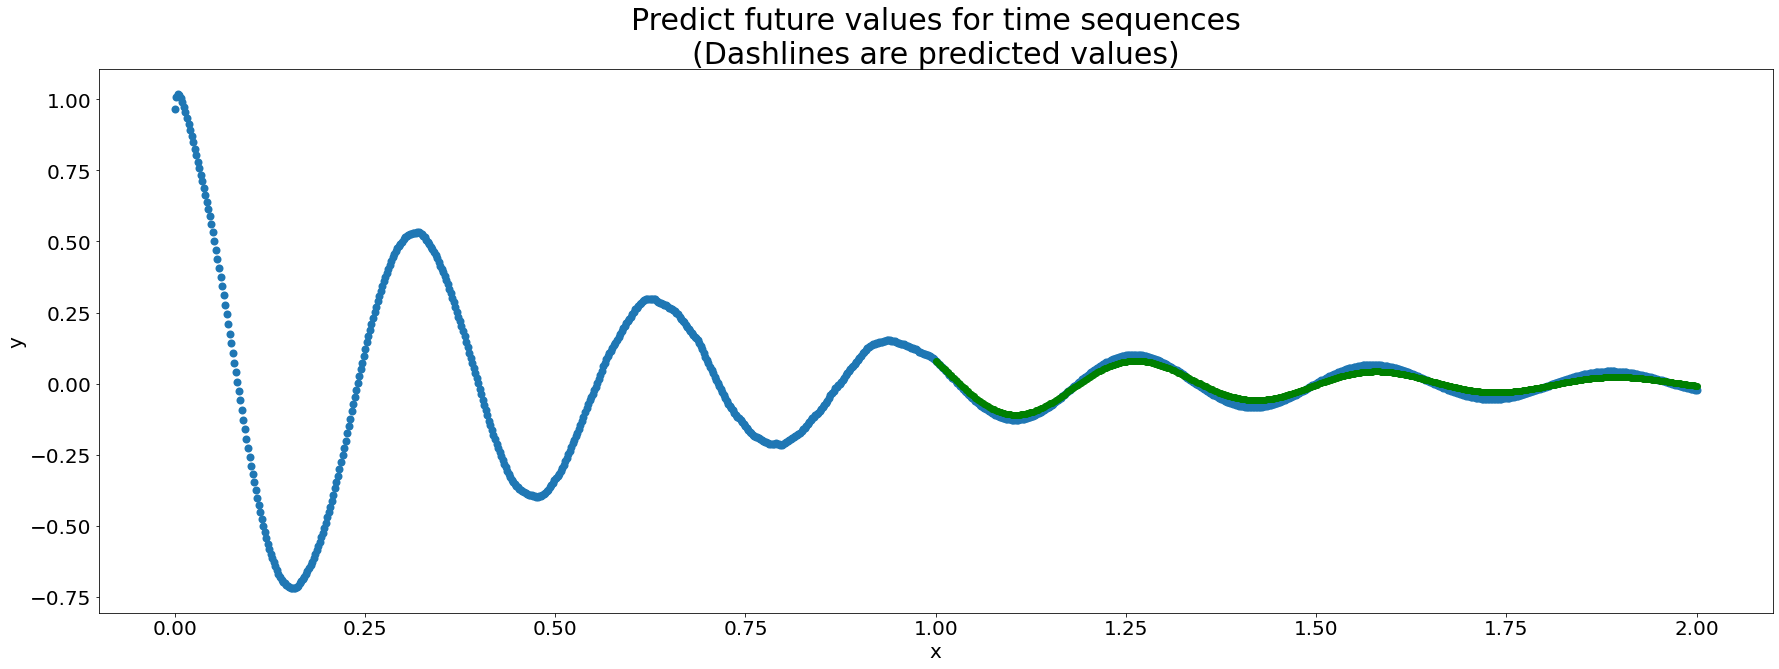

STEP:  20
loss: 0.0014052692567929626
loss: 0.0014052303740754724
loss: 0.0014052101178094745
loss: 0.001405206392519176
loss: 0.0014051940524950624
loss: 0.0014051777543500066
loss: 0.0014051487669348717
loss: 0.0014050741447135806
loss: 0.0014049194287508726
loss: 0.0014047421282157302
loss: 0.0014131574425846338
loss: 0.0014045414282009006
loss: 0.001404490671120584
loss: 0.0014043474802747369
loss: 0.0014041636604815722
loss: 0.0014039701782166958
loss: 0.0014036577194929123
loss: 0.0014033911284059286
loss: 0.0014034719206392765
loss: 0.0014024338452145457
Loss u: 1.369950e-03


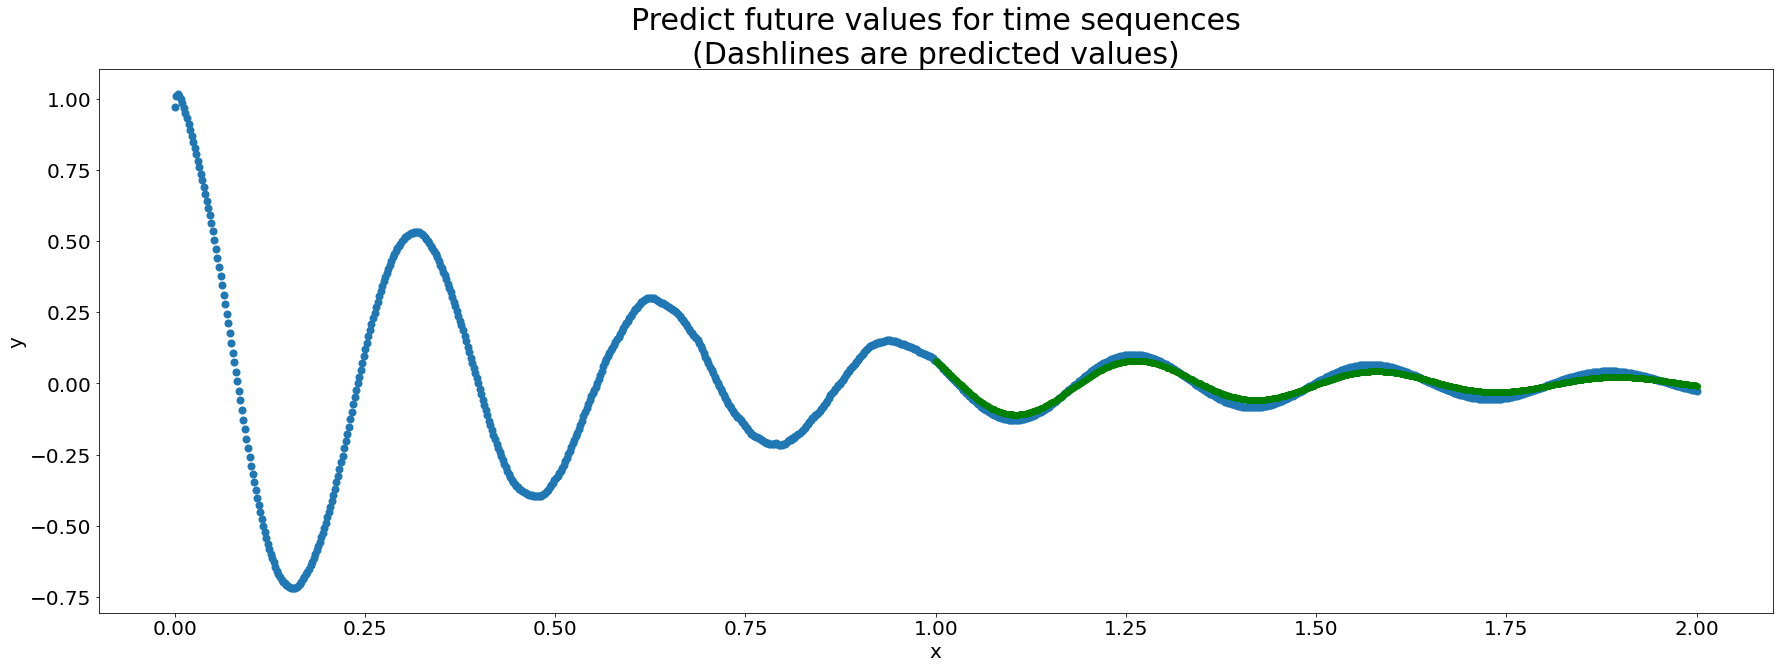

STEP:  21
loss: 0.0014018897200003266
loss: 0.0014056628569960594
loss: 0.0014154808595776558
loss: 0.003228135174140334
loss: 0.0014088122406974435
loss: 0.0014036822831258178
loss: 0.0014005074044689536
loss: 0.0014001610688865185
loss: 0.0013998507056385279
loss: 0.0013991632731631398
loss: 0.0013990362640470266
loss: 0.0013987829443067312
loss: 0.0013986630365252495
loss: 0.0013984562829136848
loss: 0.0013982255477458239
loss: 0.001397973275743425
loss: 0.0013972680317237973
loss: 0.0013967560371384025
loss: 0.0013955634785816073
loss: 0.0014416900230571628
Loss u: 1.364092e-03


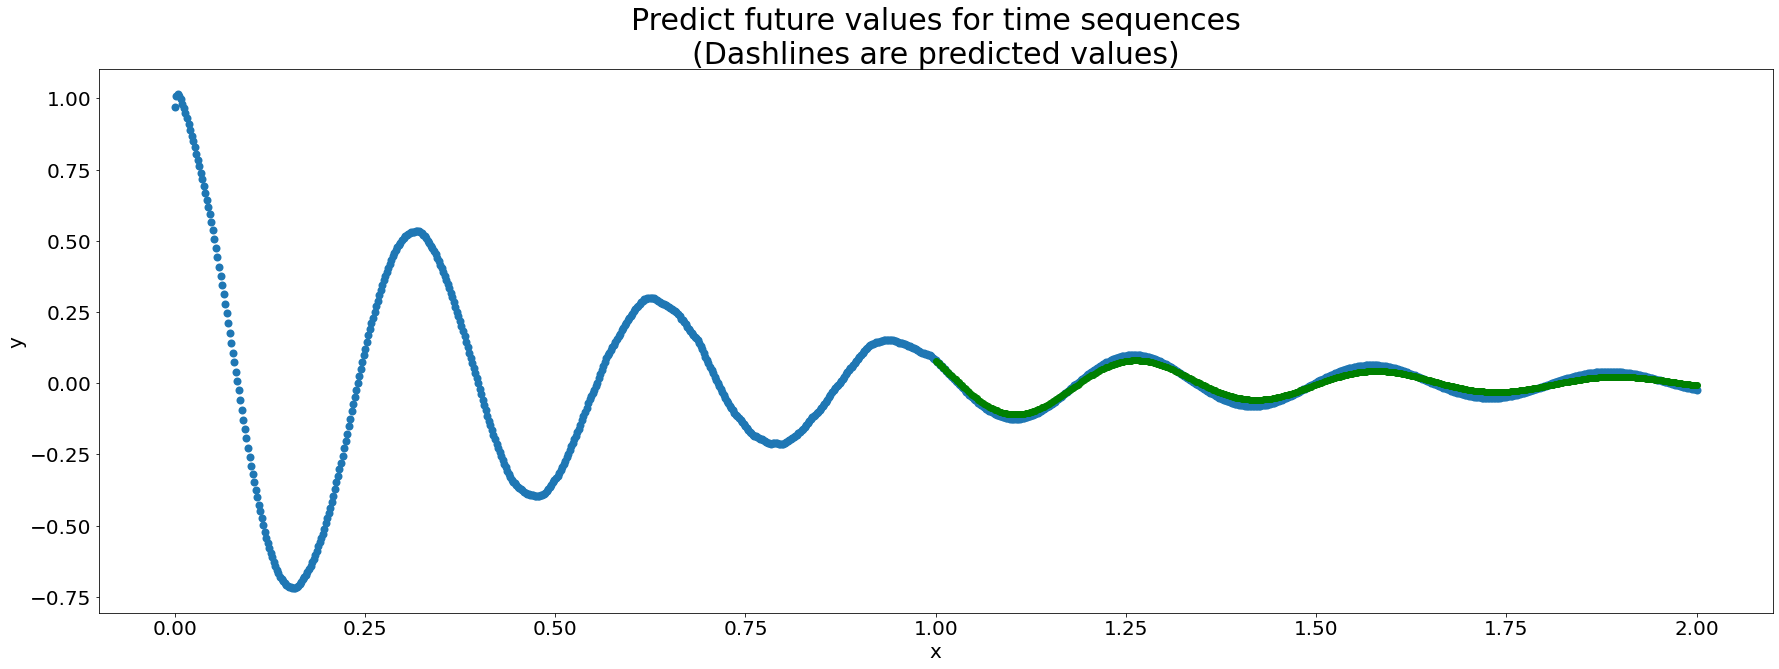

STEP:  22
loss: 0.001394905848428607
loss: 0.0013946046819910407
loss: 0.001394439022988081
loss: 0.0013936489121988416
loss: 0.001393187209032476
loss: 0.0014096956001594663
loss: 0.0013929057167842984
loss: 0.0013927500694990158
loss: 0.0013924016384407878
loss: 0.001400252804160118
loss: 0.0013921087374910712
loss: 0.0013918852200731635
loss: 0.002779570873826742
loss: 0.0013918242184445262
loss: 0.0013917861506342888
loss: 0.001391522353515029
loss: 0.0013913882430642843
loss: 0.0013910483103245497
loss: 0.0013907867250964046
loss: 0.0013905852101743221
Loss u: 1.360295e-03


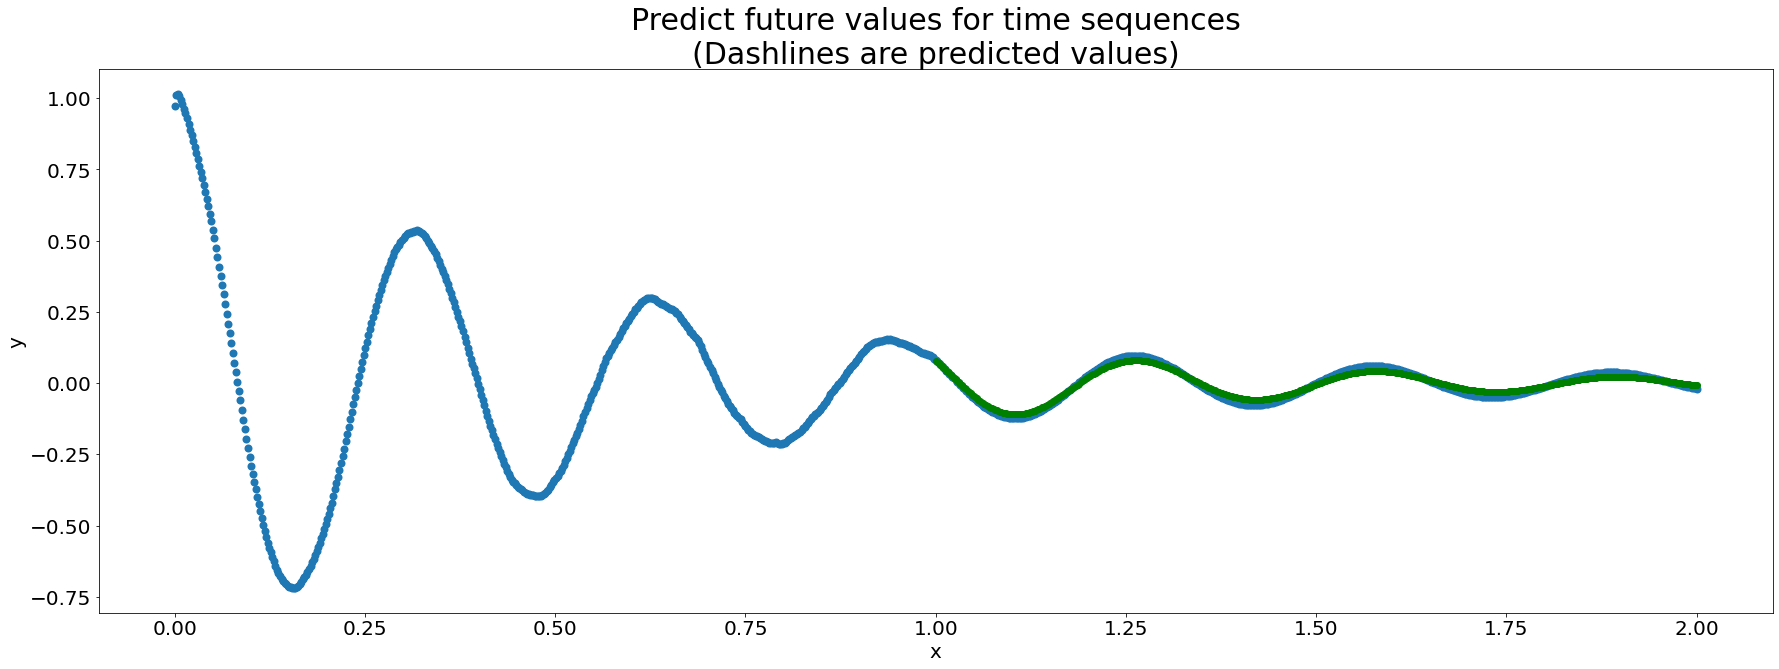

STEP:  23
loss: 0.0013903031358495355
loss: 0.0013901799684390426
loss: 0.0013900591293349862
loss: 0.0013899124460294843
loss: 0.0013894751900807023
loss: 0.0013893209397792816
loss: 0.0013889336260035634
loss: 0.001388801378197968
loss: 0.0013887444511055946
loss: 0.0013886919477954507
loss: 0.0013886390952393413
loss: 0.0013885922962799668
loss: 0.0013885077787563205
loss: 0.001388467731885612
loss: 0.001388420583680272
loss: 0.001388372271321714
loss: 0.0013883422361686826
loss: 0.0013882922939956188
loss: 0.0013882581843063235
loss: 0.0013882111525163054
Loss u: 1.360217e-03


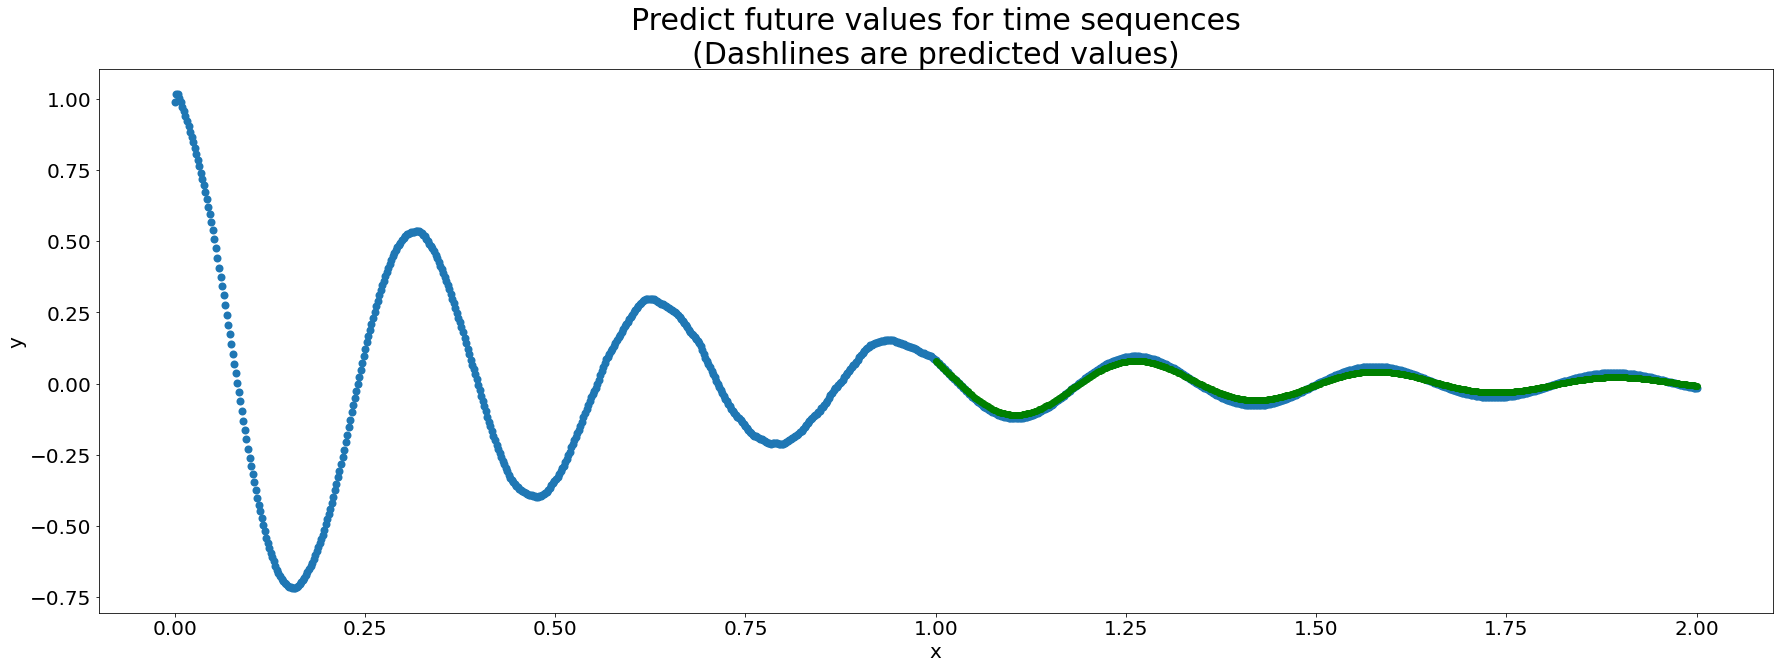

STEP:  24
loss: 0.0013881289632990956
loss: 0.0013880792539566755
loss: 0.0013882810017094016
loss: 0.0013880152255296707
loss: 0.0013879871694371104
loss: 0.0013879871694371104
Loss u: 1.359788e-03


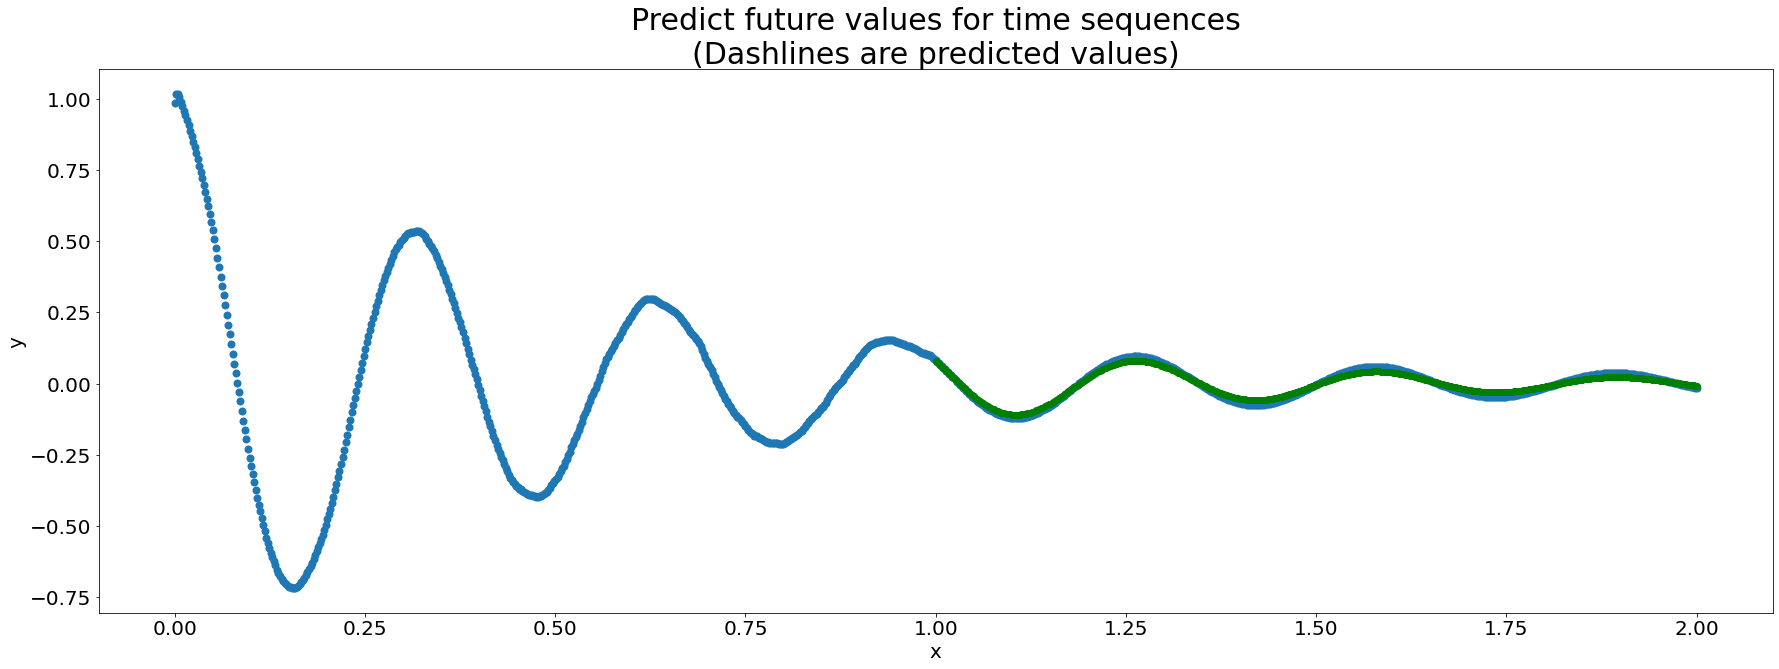

STEP:  25
loss: 0.0013879871694371104
loss: 0.0013879649341106415
loss: 0.0013879606267437339
loss: 0.001387949800118804
loss: 0.001387939671985805
loss: 0.0013879165053367615
loss: 0.001387887867167592
loss: 0.0013878365280106664
loss: 0.0013877477031201124
loss: 0.0013875114964321256
loss: 0.0013890250120311975
loss: 0.0013873963616788387
loss: 0.001387374009937048
loss: 0.0013869758695363998
loss: 0.0013869724934920669
loss: 0.0013866524677723646
loss: 0.0013864767970517278
loss: 0.0014164946042001247
loss: 0.0013862552586942911
loss: 0.0013861351180821657
Loss u: 1.357407e-03


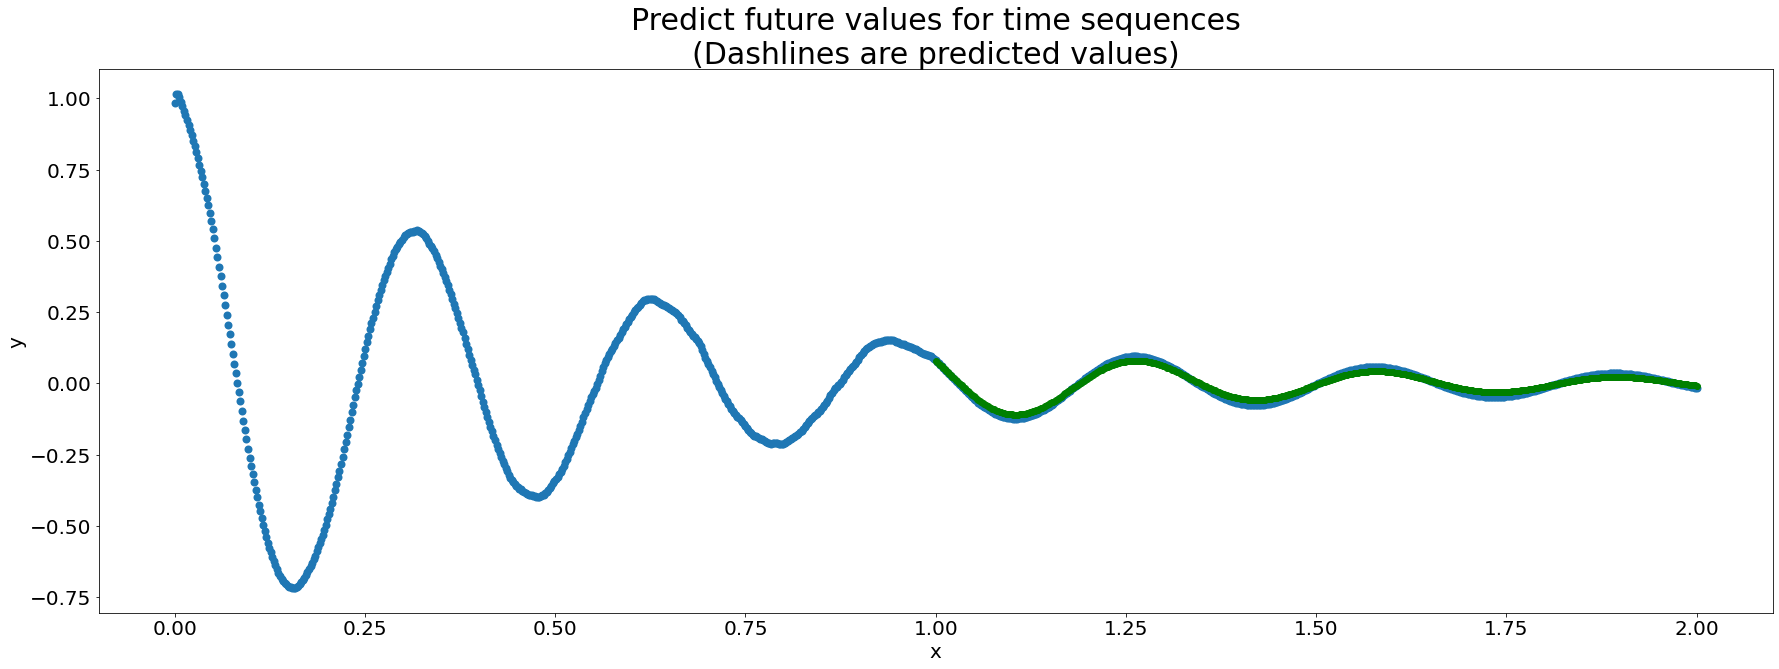

STEP:  26
loss: 0.0013861758634448051
loss: 0.001386251300573349
loss: 0.0013891867129132152
loss: 0.0013869929825887084
loss: 0.0013856666628271341
loss: 0.0013973865425214171
loss: 0.00138528598472476
loss: 0.001384993433021009
loss: 0.004318189807236195
loss: 0.0013849405804648995
loss: 0.0013848968083038926
loss: 0.001384344999678433
loss: 0.00138379679992795
loss: 0.0013832926051691175
loss: 0.0015136151341721416
loss: 0.0013828831724822521
loss: 0.001383233699016273
loss: 0.0013823650078848004
loss: 0.0013820132007822394
loss: 0.0013812106335535645
Loss u: 1.354801e-03


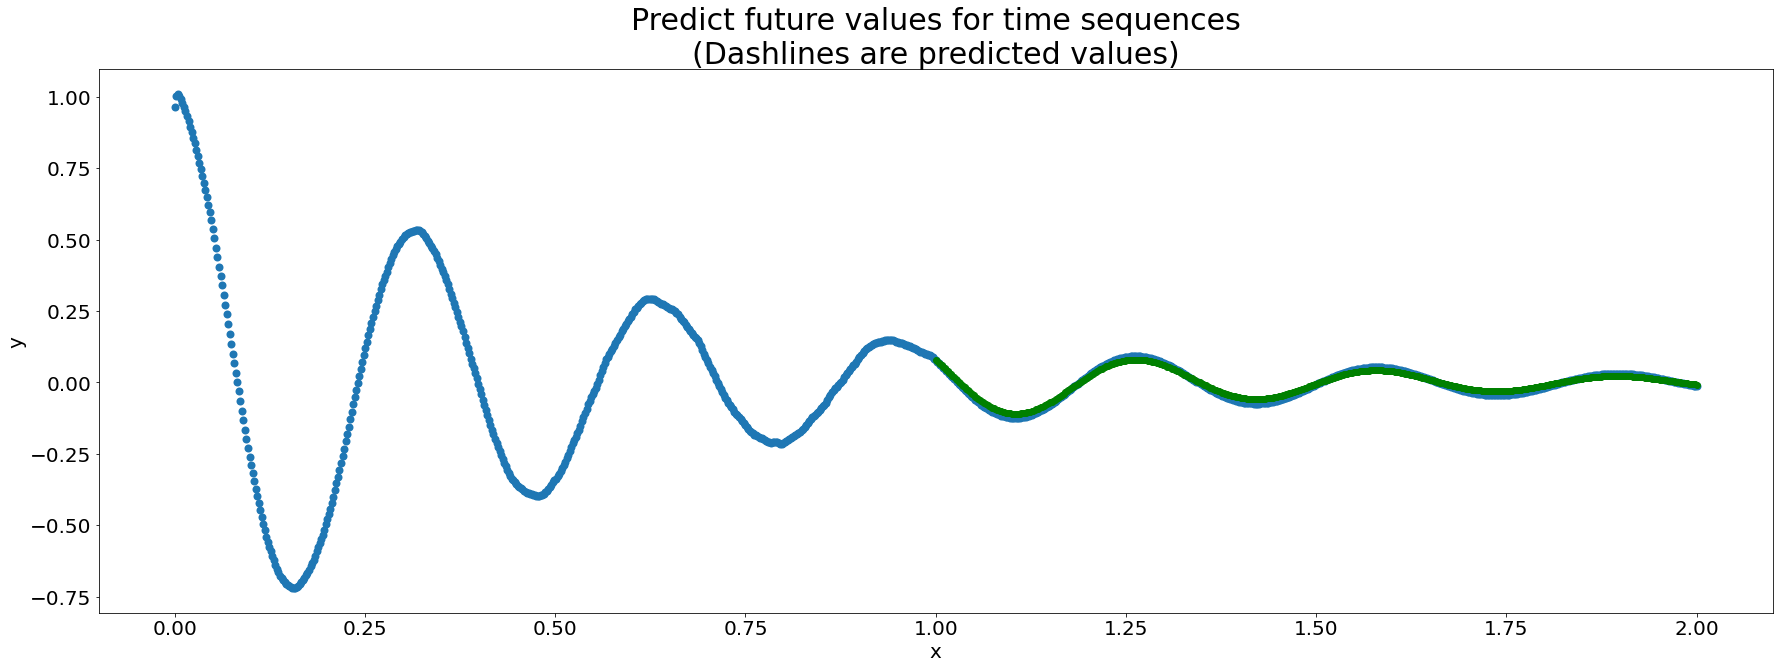

STEP:  27
loss: 0.0013857715530321002
loss: 0.0013807050418108702
loss: 0.0013804159825667739
loss: 0.0013798103900626302
loss: 0.0013793251710012555
loss: 0.0013790668454021215
loss: 0.0013788709184154868
loss: 0.001378705957904458
loss: 0.0013785585761070251
loss: 0.0013840339379385114
loss: 0.0013784363400191069
loss: 0.0013783586909994483
loss: 0.0013951007276773453
loss: 0.0013783089816570282
loss: 0.0013782645110040903
loss: 0.0014028721489012241
loss: 0.0013782159658148885
loss: 0.001378171844407916
loss: 0.0013875412987545133
loss: 0.0013780704466626048
Loss u: 1.342800e-03


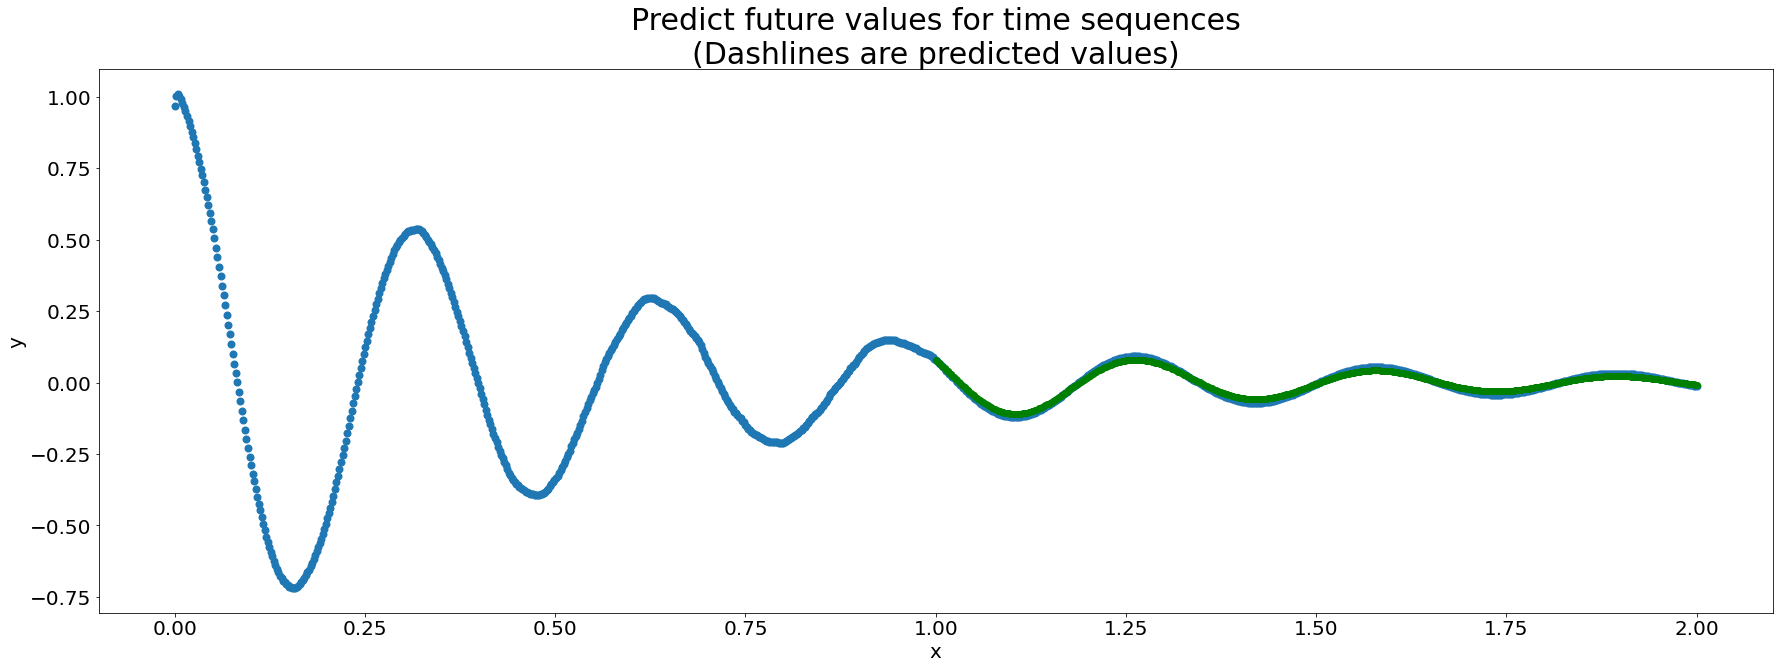

STEP:  28
loss: 0.0013779893051832914
loss: 0.0013790548546239734
loss: 0.0013777886051684618
loss: 0.0013776797568425536
loss: 0.0013777401763945818
loss: 0.0013775468105450273
loss: 0.0013775078114122152
loss: 0.0013774560065940022
loss: 0.0013774195685982704
loss: 0.001377291395328939
loss: 0.0013772138627246022
loss: 0.0013771322555840015
loss: 0.0013769997749477625
loss: 0.0013770387740805745
loss: 0.0013768549542874098
loss: 0.0013767883647233248
loss: 0.0013774607796221972
loss: 0.0013767466880381107
loss: 0.0013767144409939647
loss: 0.001382689457386732
Loss u: 1.341713e-03


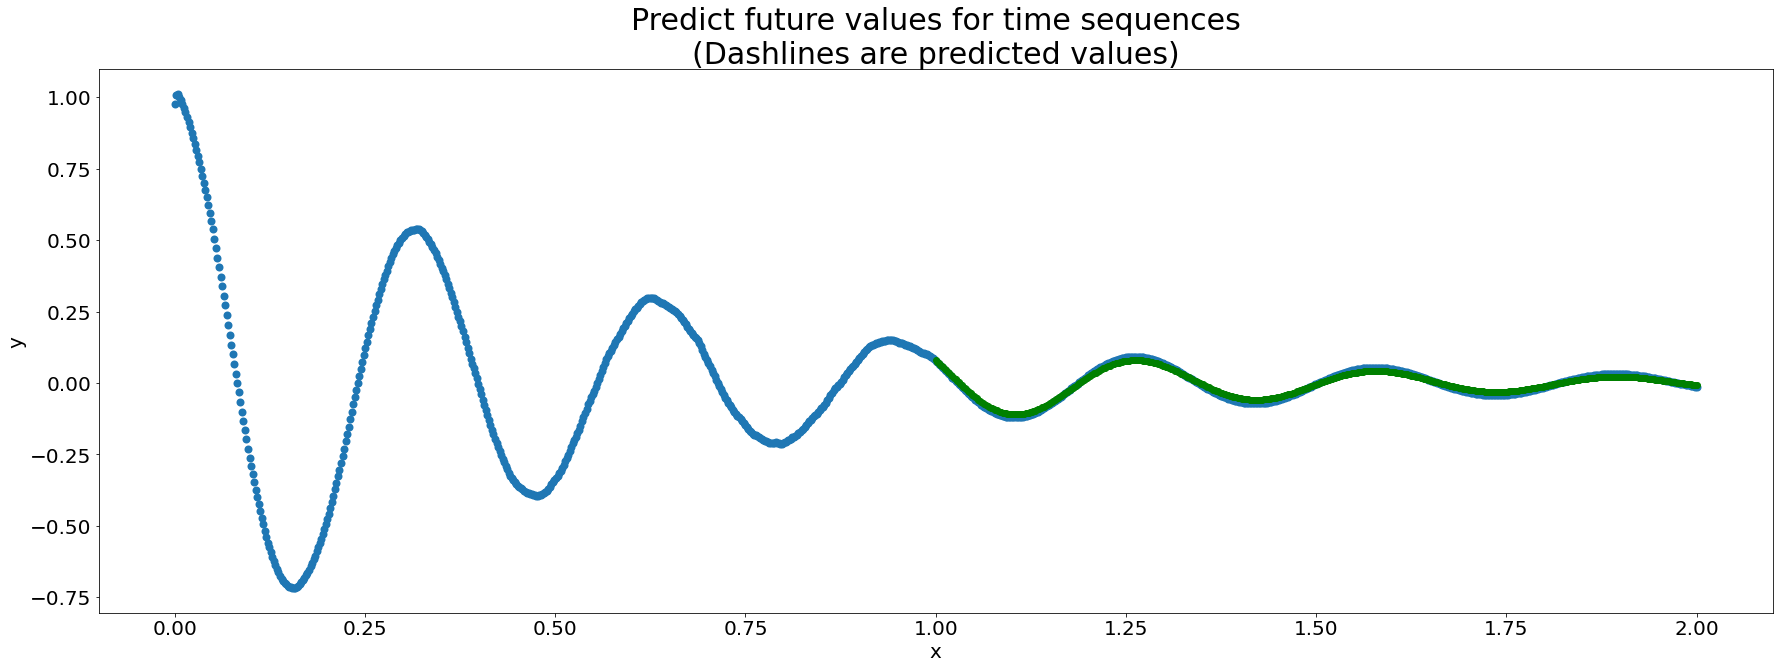

STEP:  29
loss: 0.0013766632182523608
loss: 0.0013766140909865499
loss: 0.0013765649637207389
loss: 0.001376515720039606
loss: 0.14276601374149323
loss: 0.0013824424240738153
loss: 0.9947721362113953
loss: 0.3989650011062622
loss: 587885.375
loss: inf
loss: inf
loss: inf
loss: inf
loss: inf
loss: inf
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


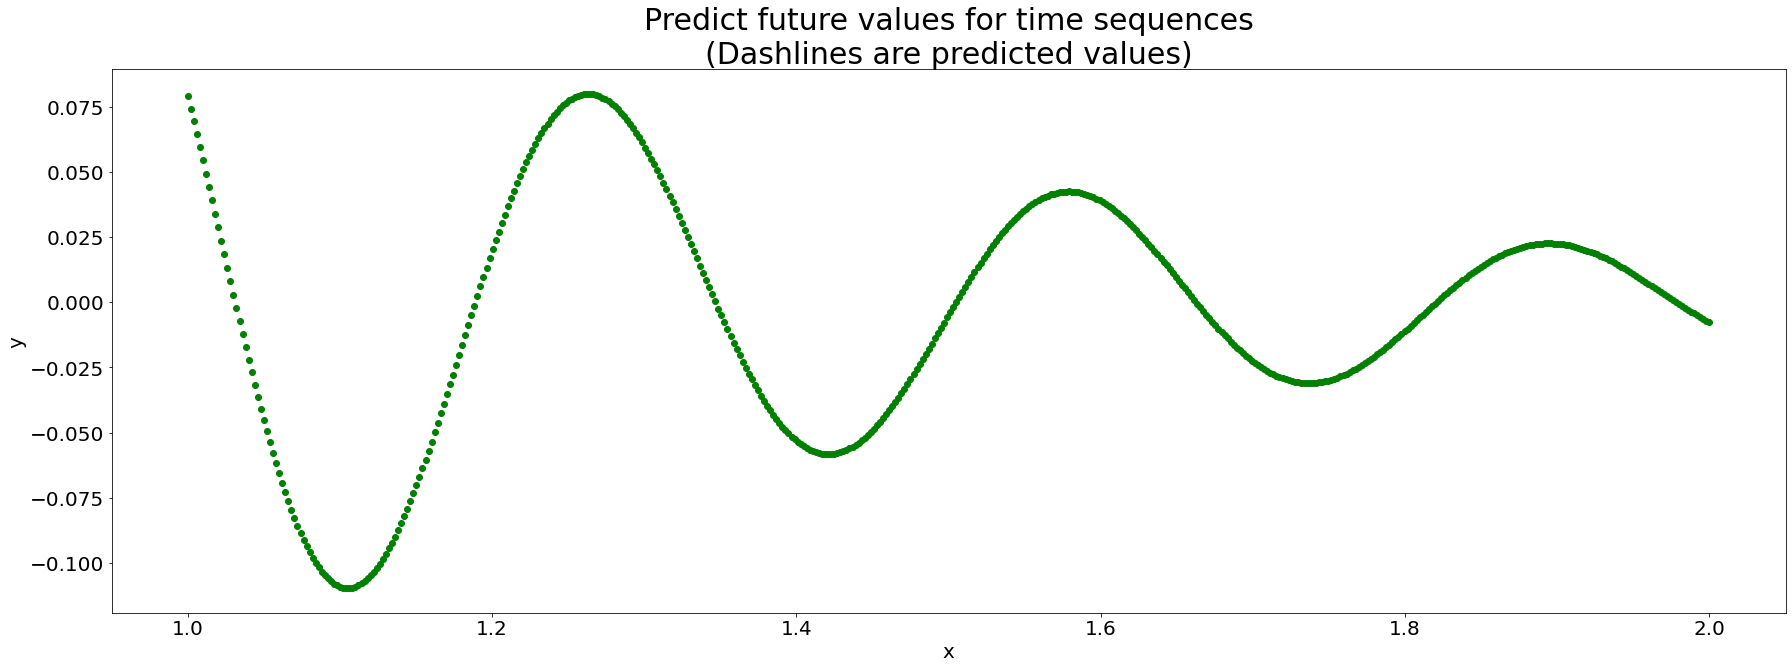

STEP:  30
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


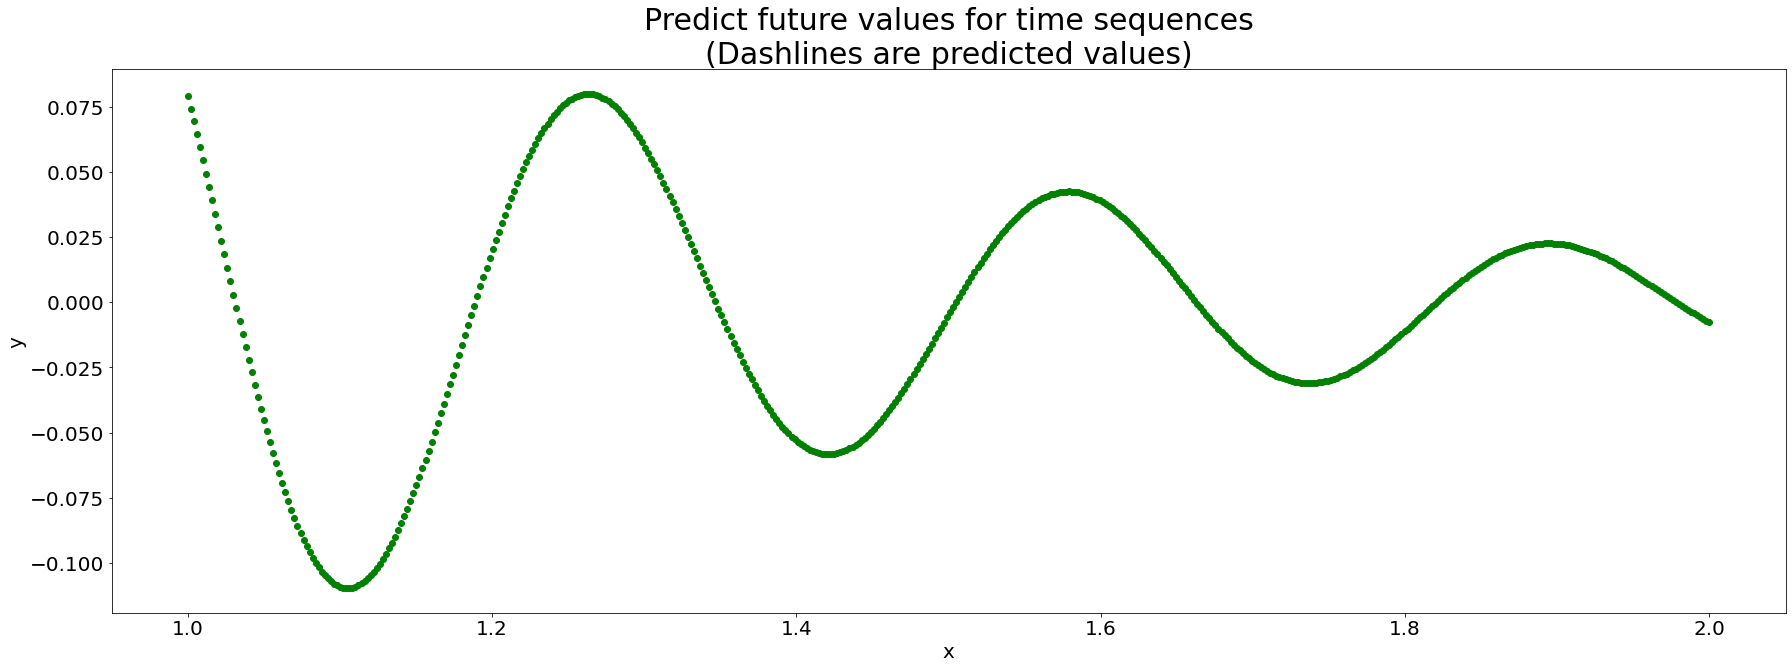

STEP:  31
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


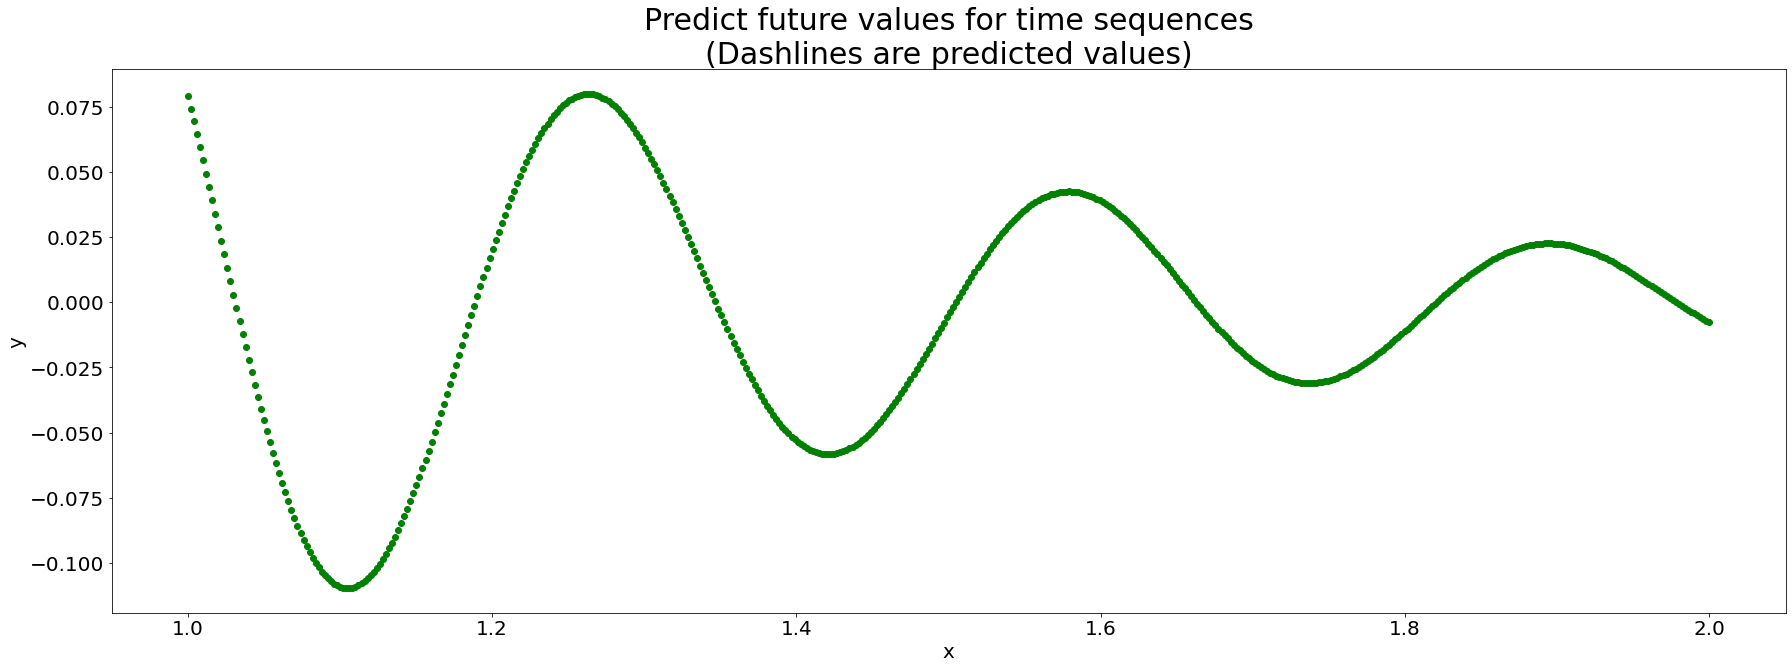

STEP:  32
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


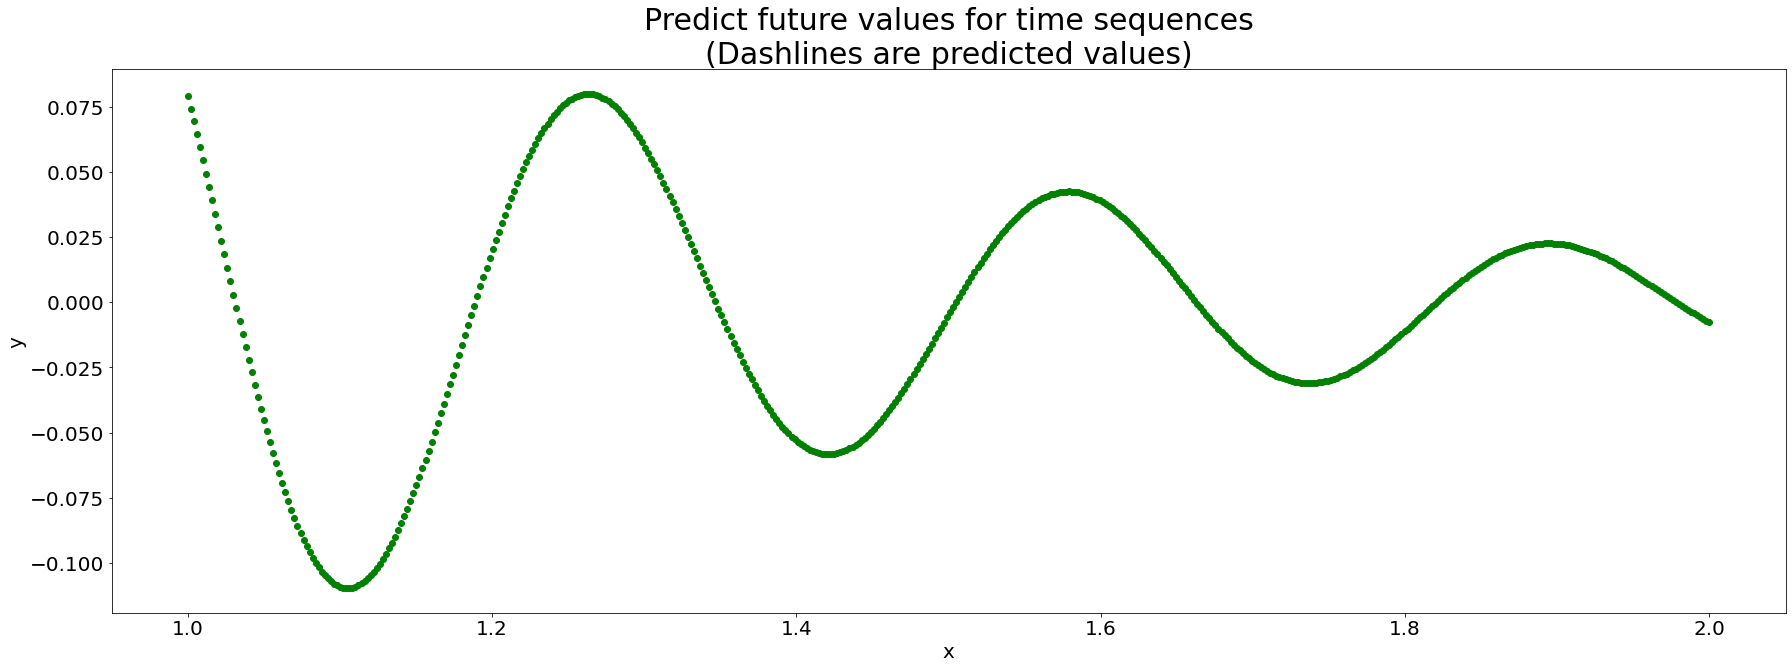

STEP:  33
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


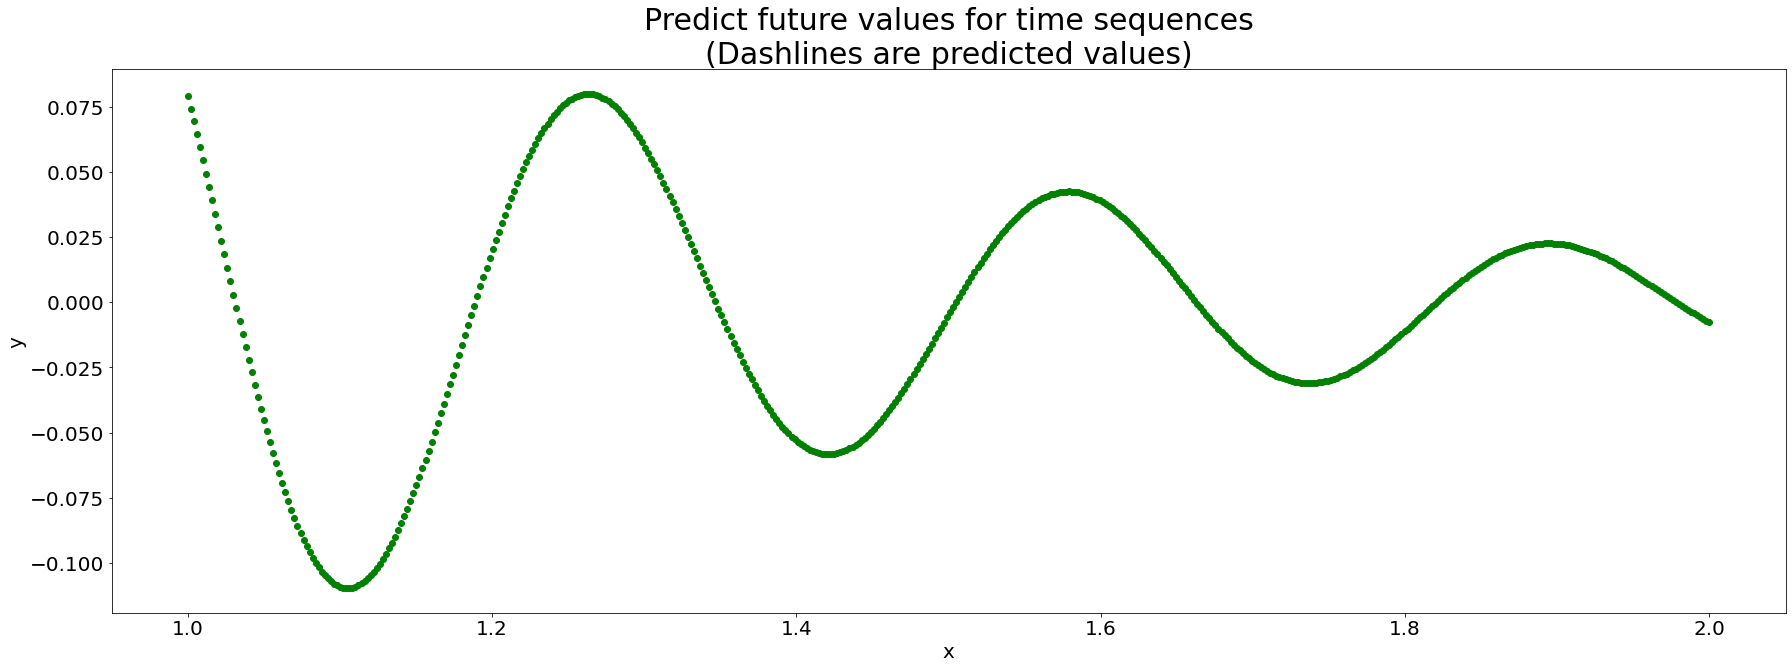

STEP:  34
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


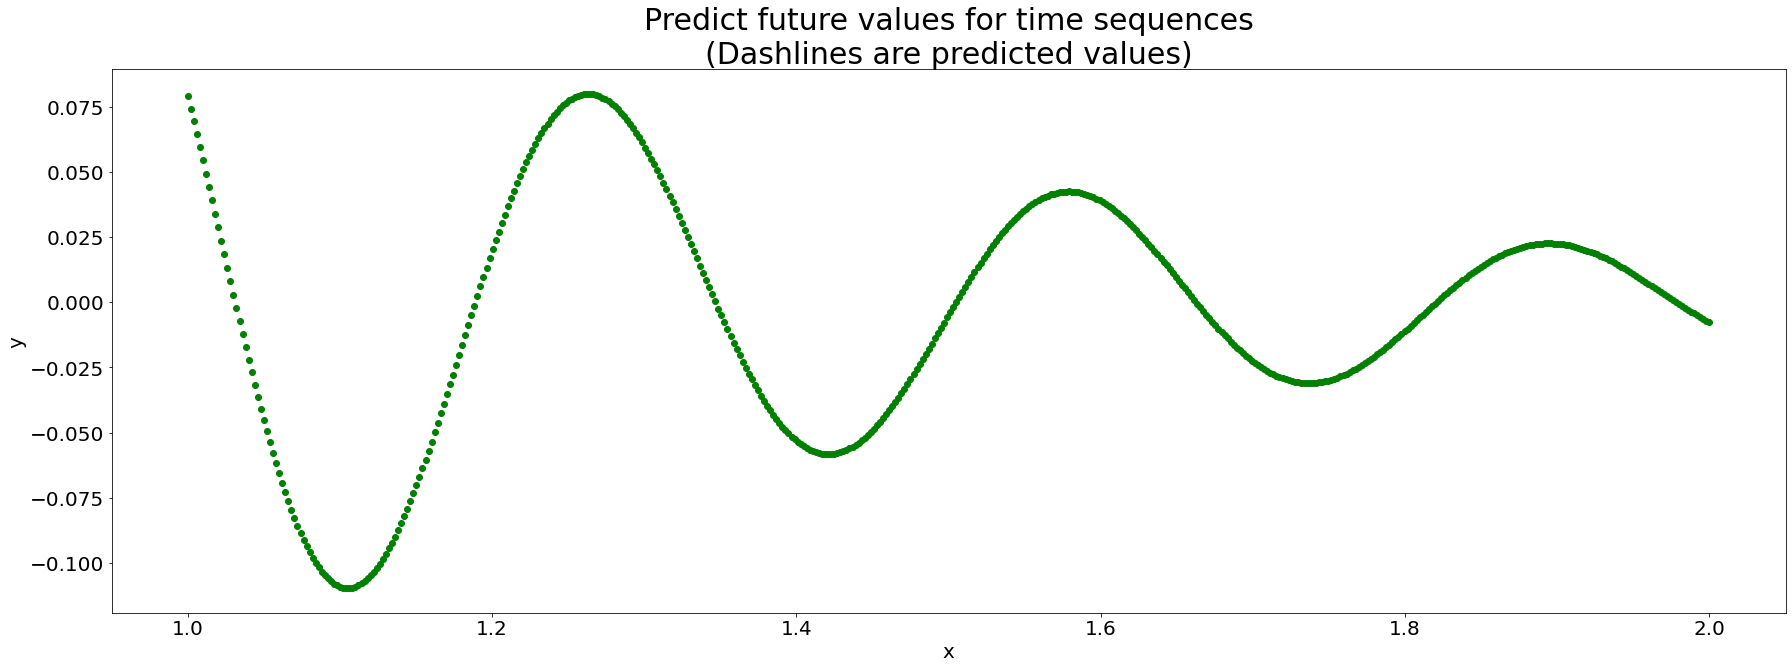

STEP:  35
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


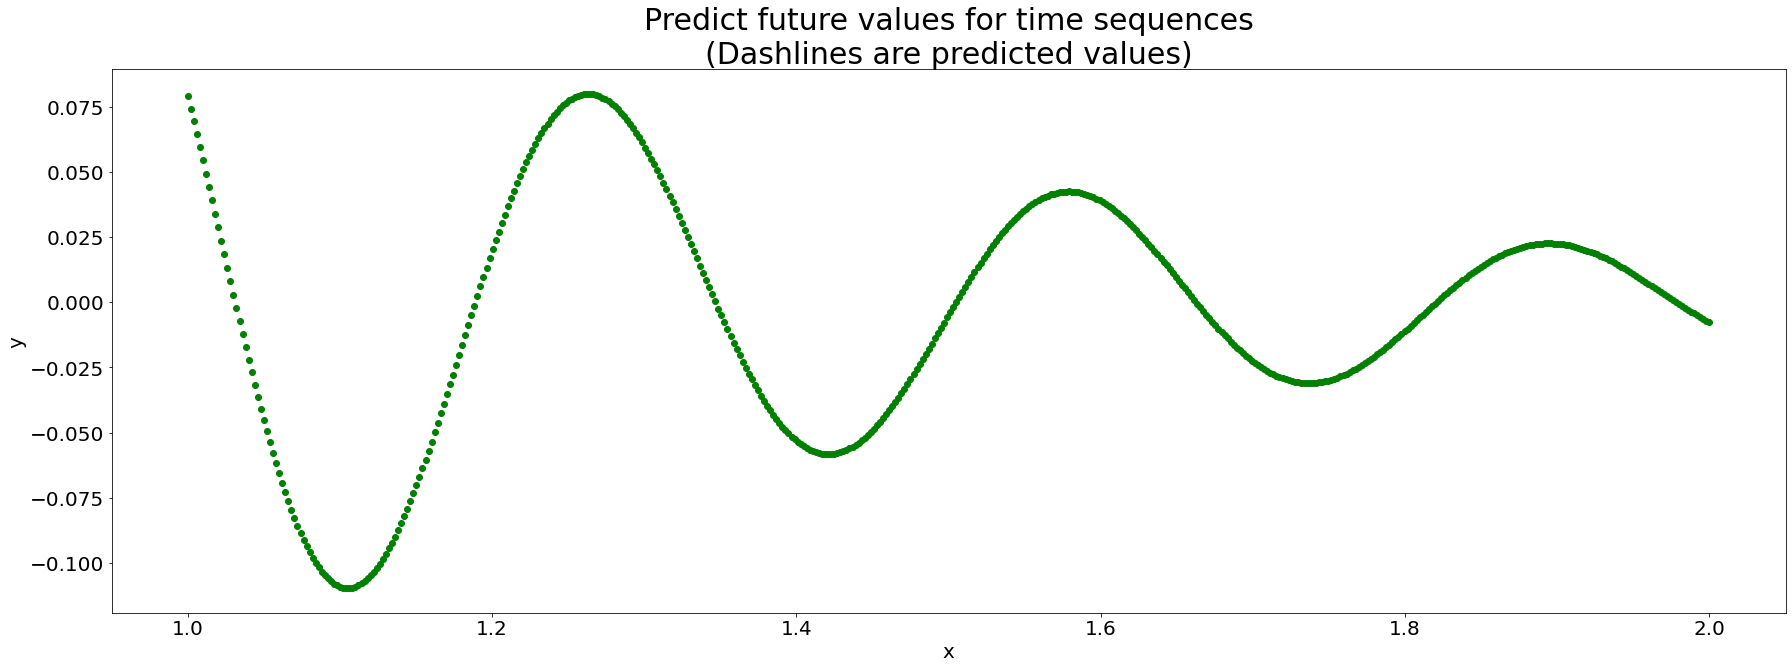

STEP:  36
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


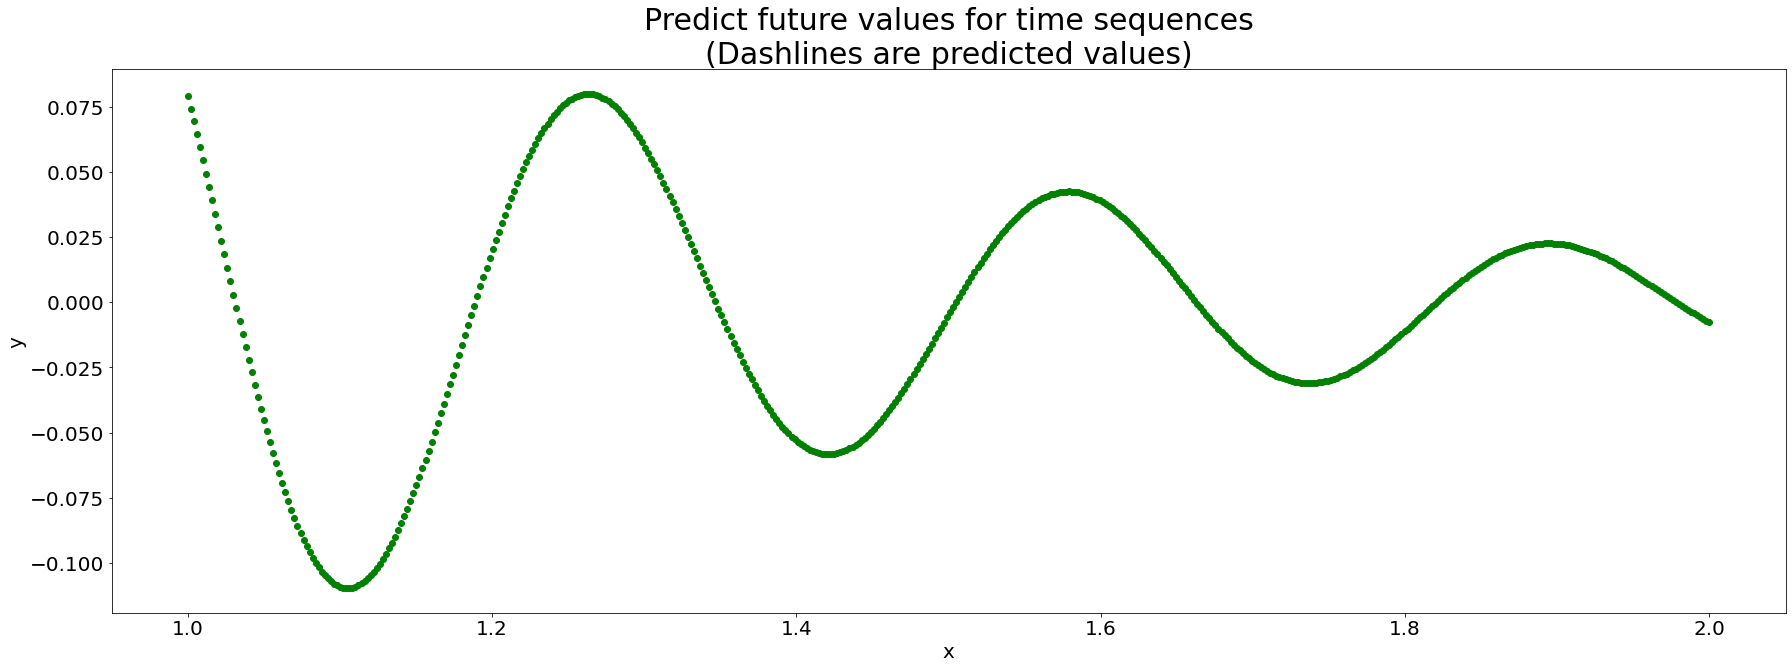

STEP:  37
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


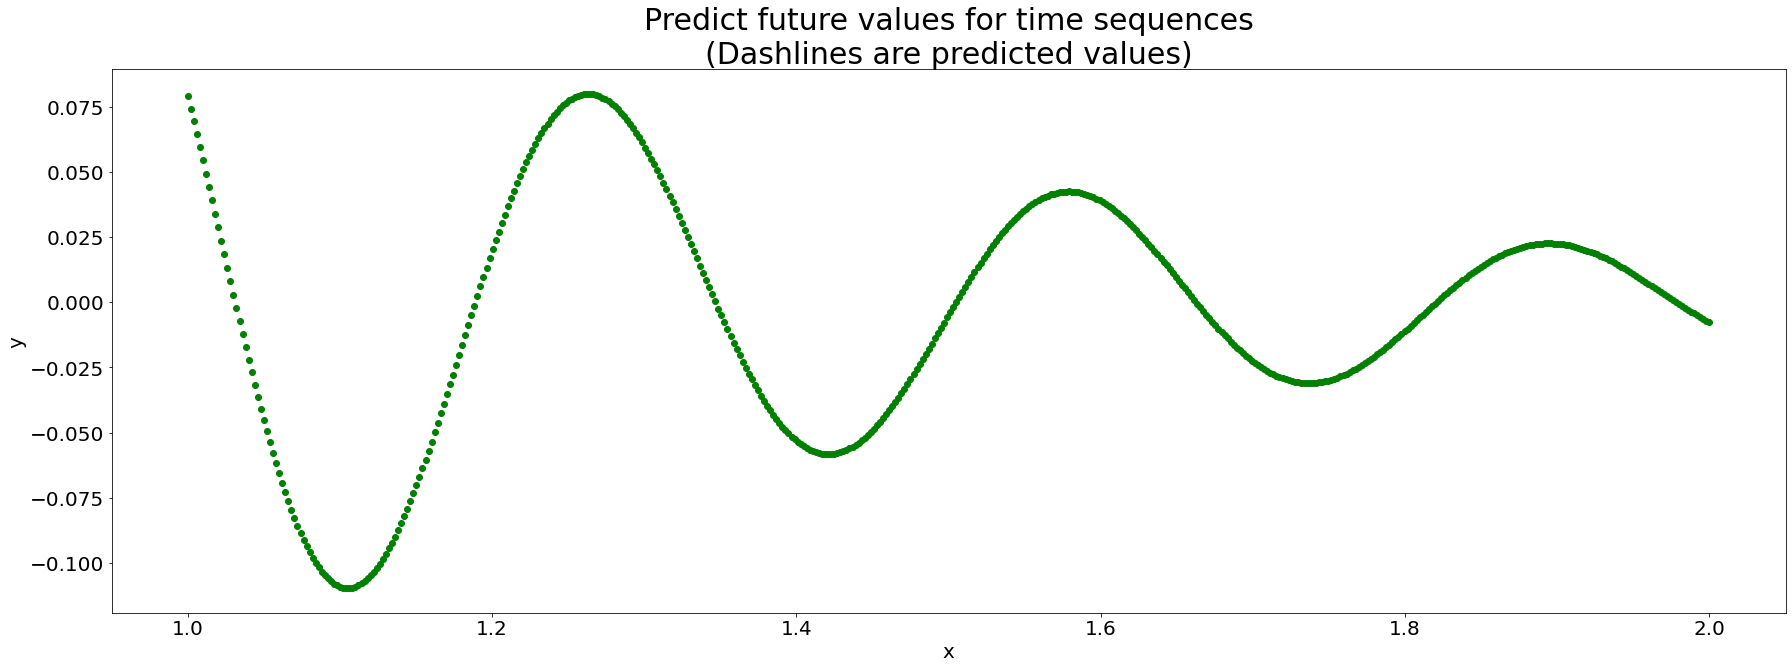

STEP:  38
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


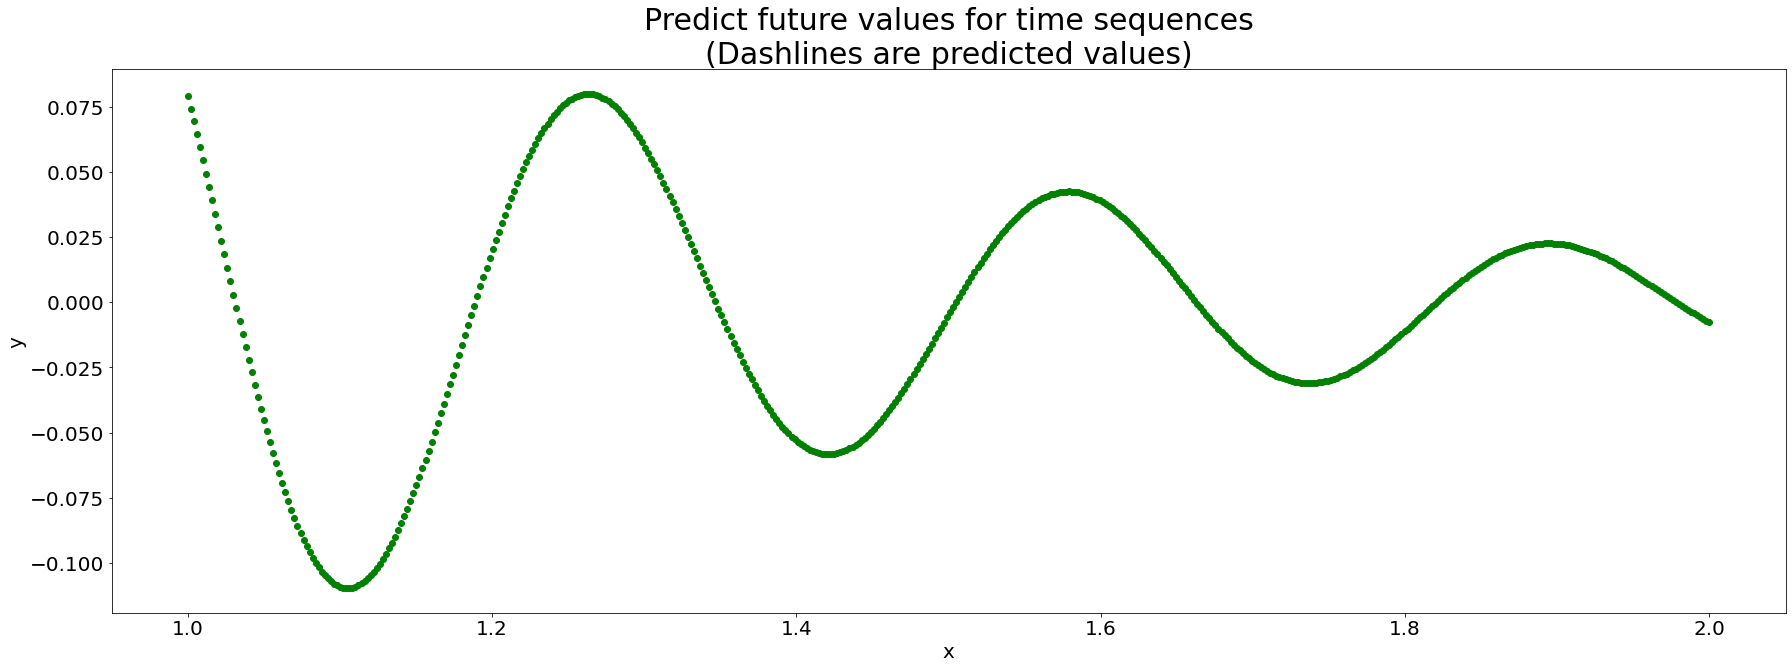

STEP:  39
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


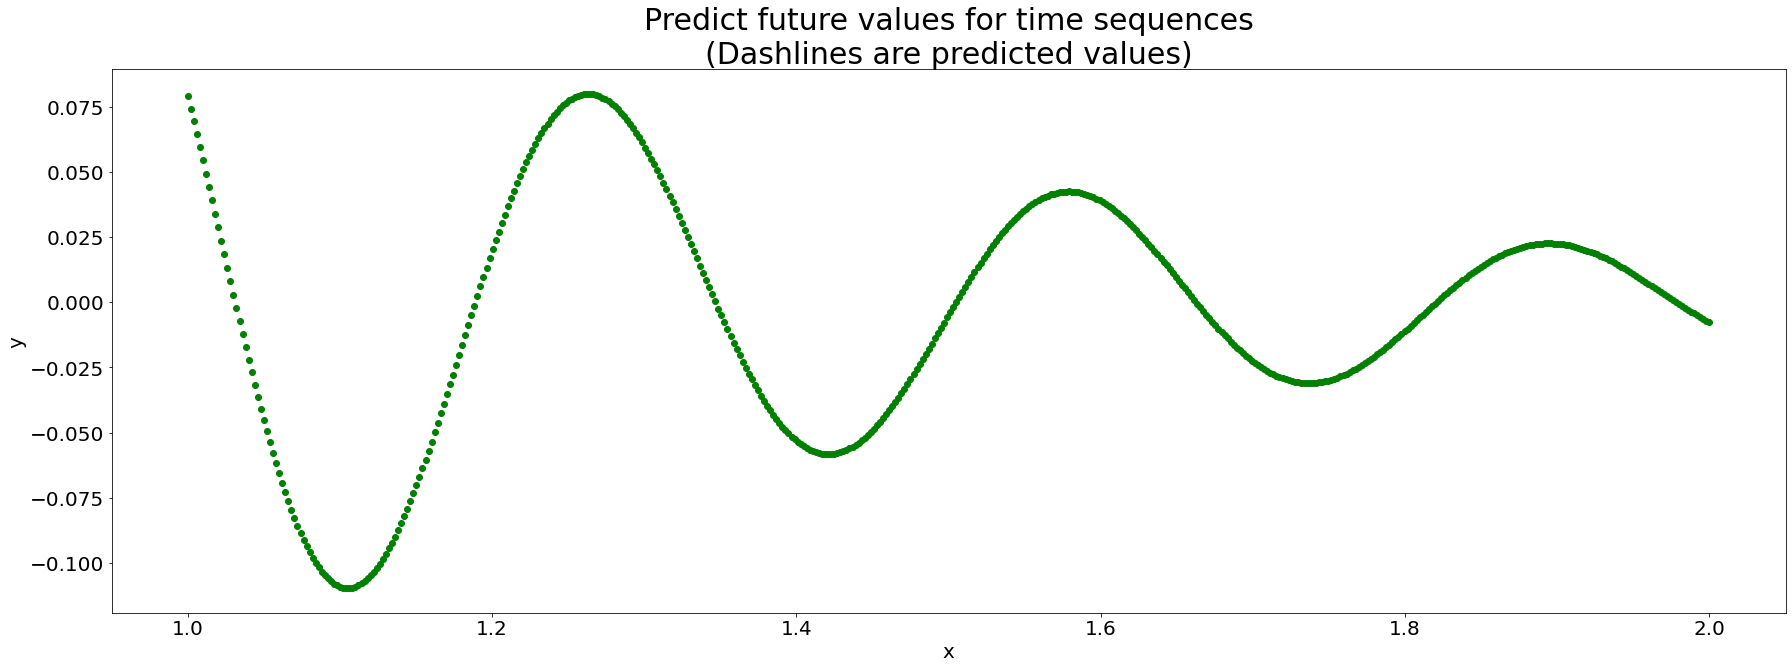

STEP:  40
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


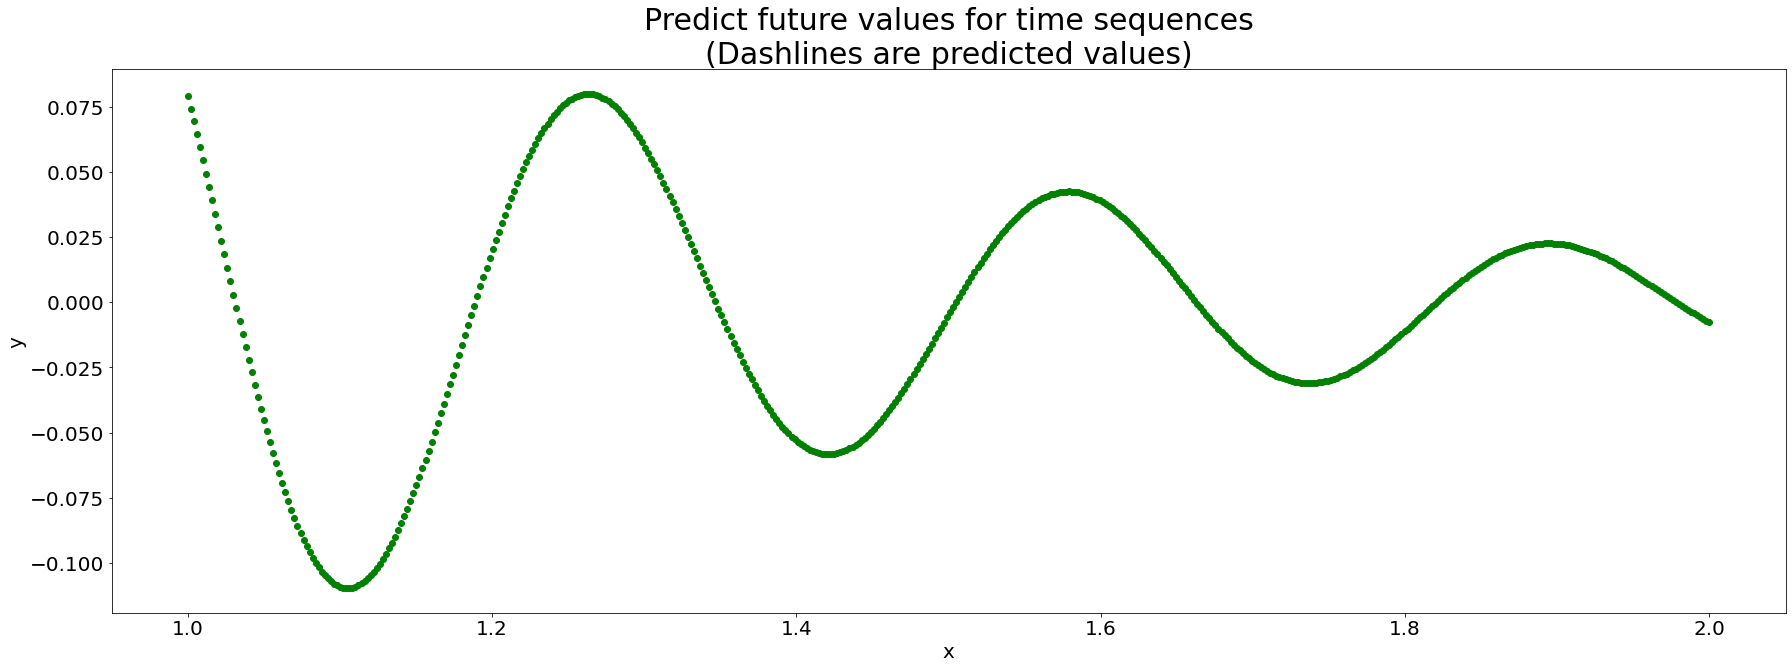

STEP:  41
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


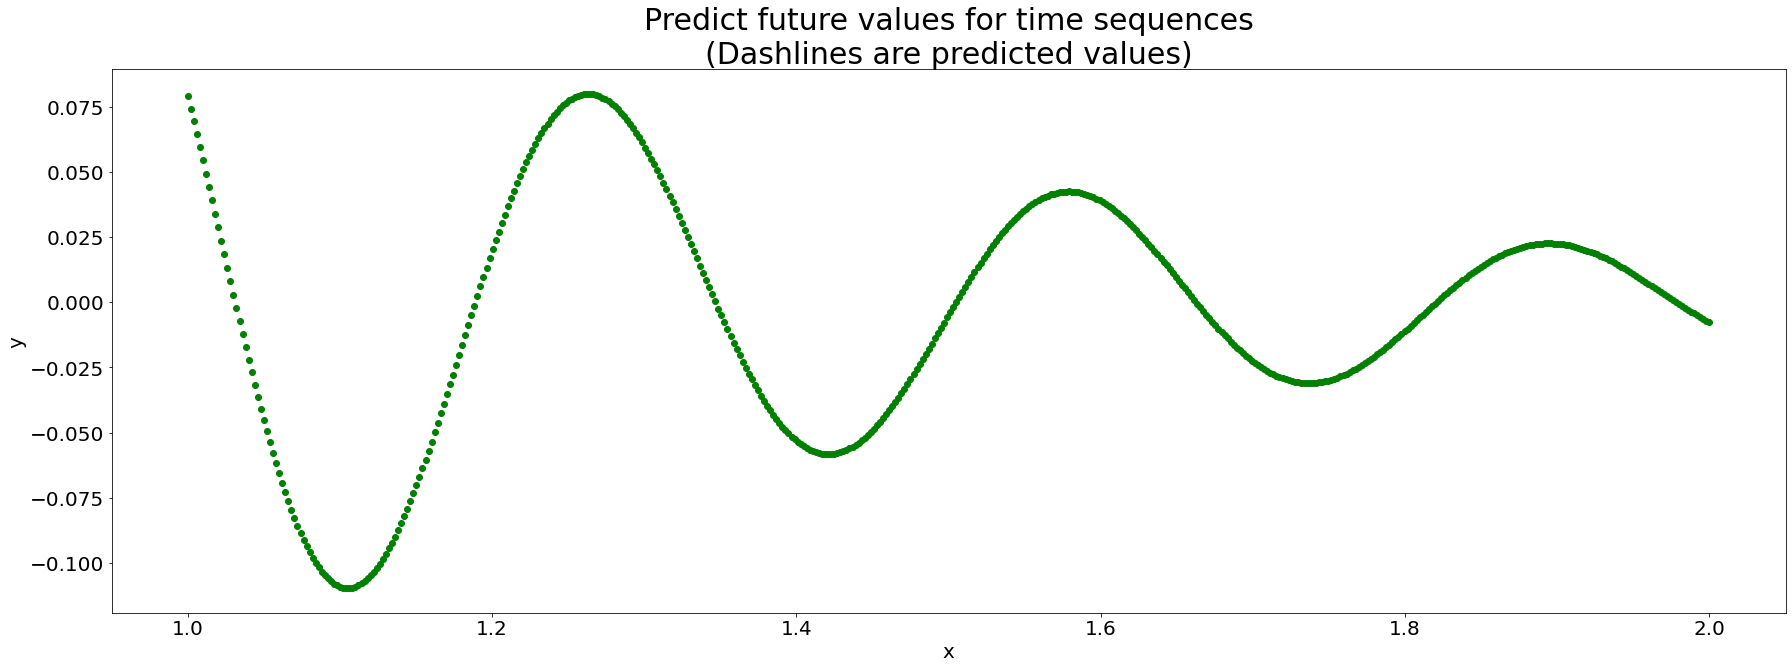

STEP:  42
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


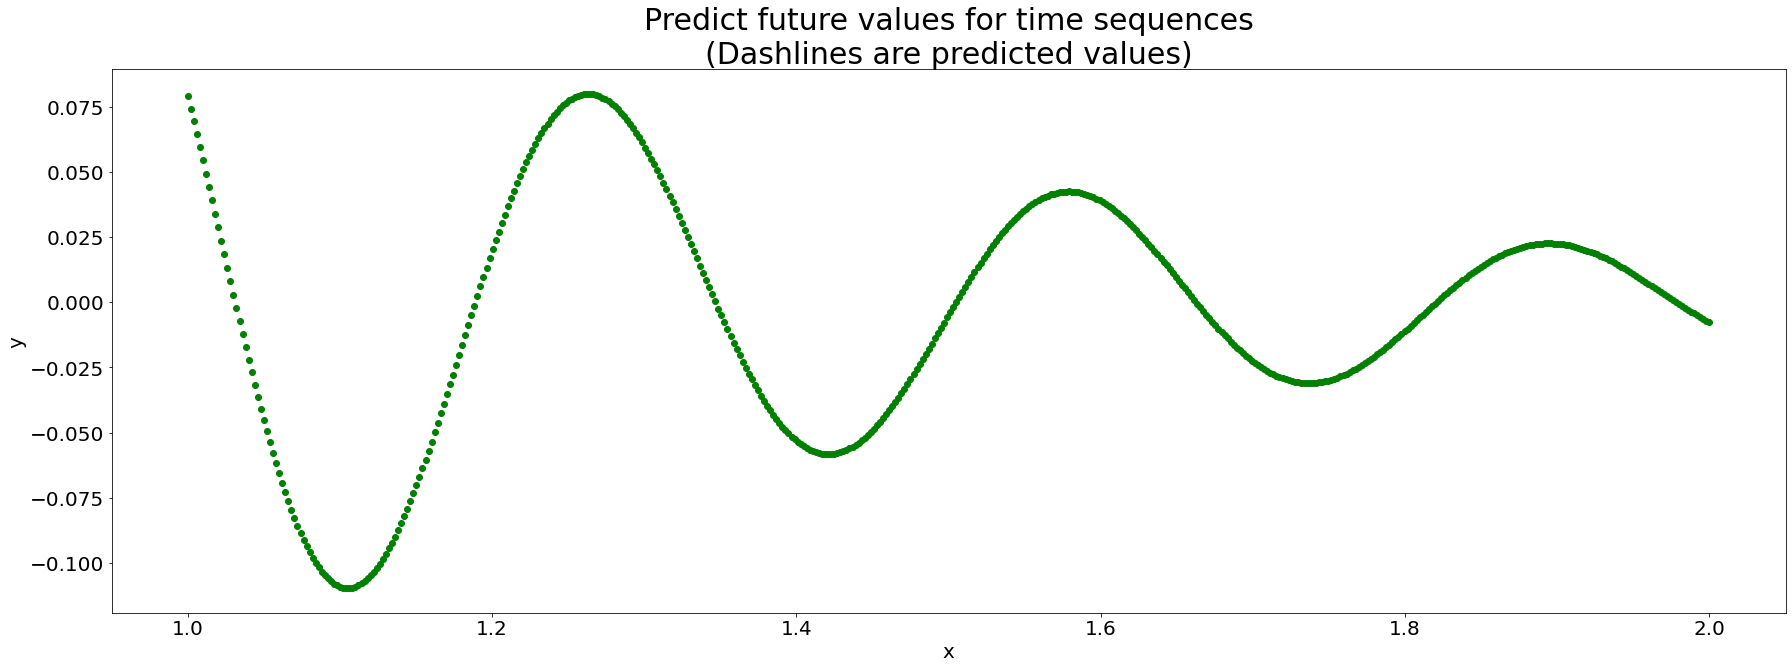

STEP:  43
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


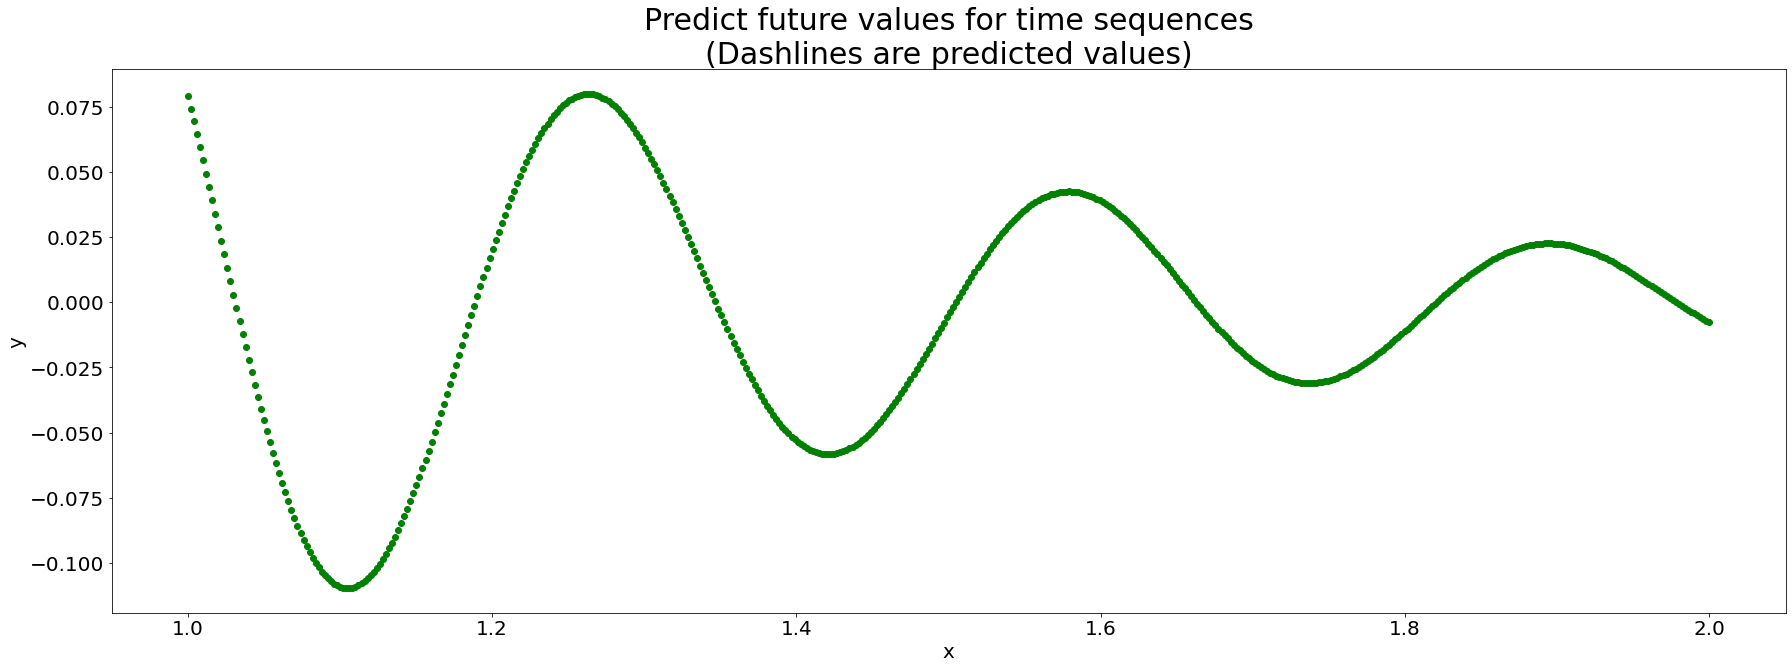

STEP:  44
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


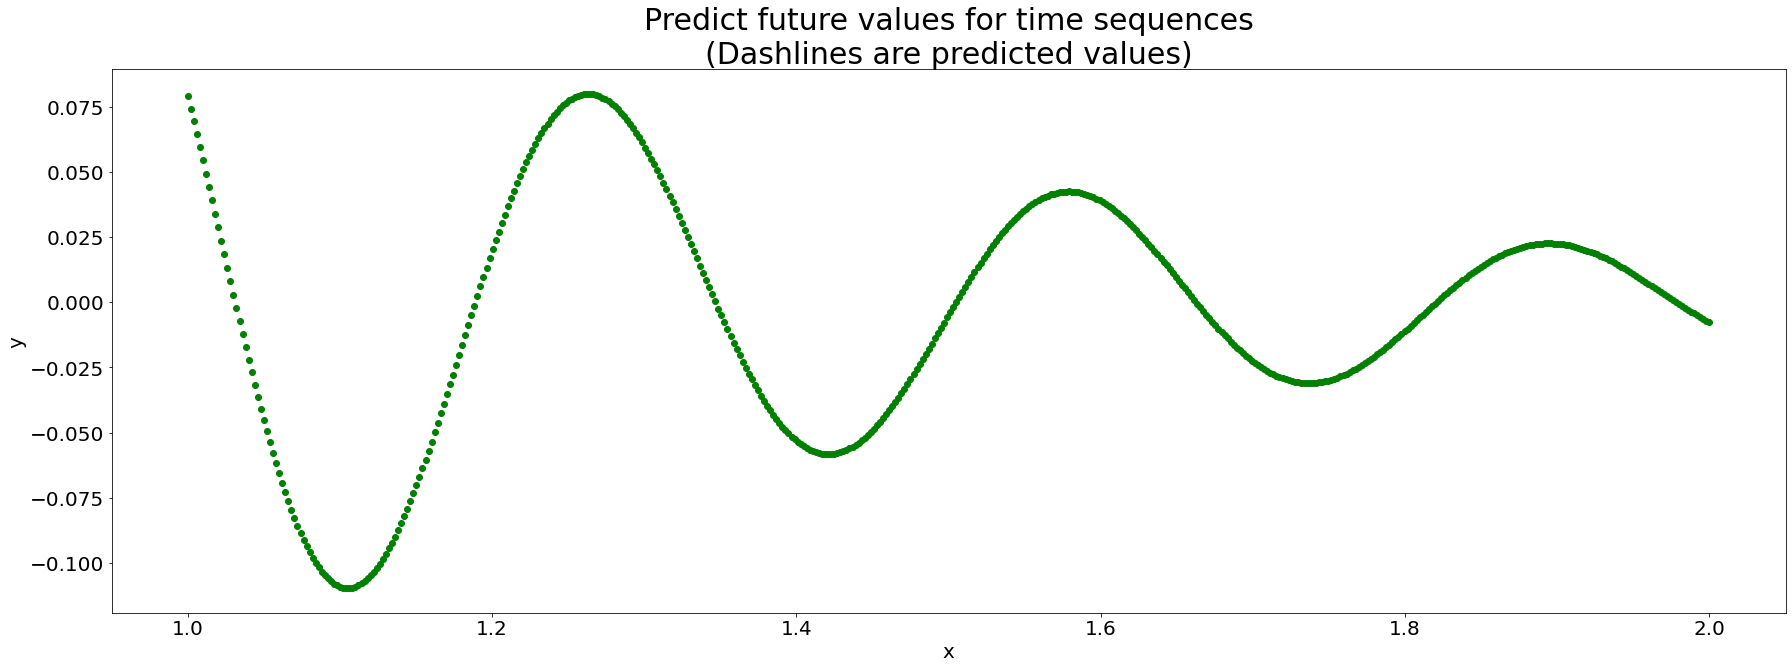

STEP:  45
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


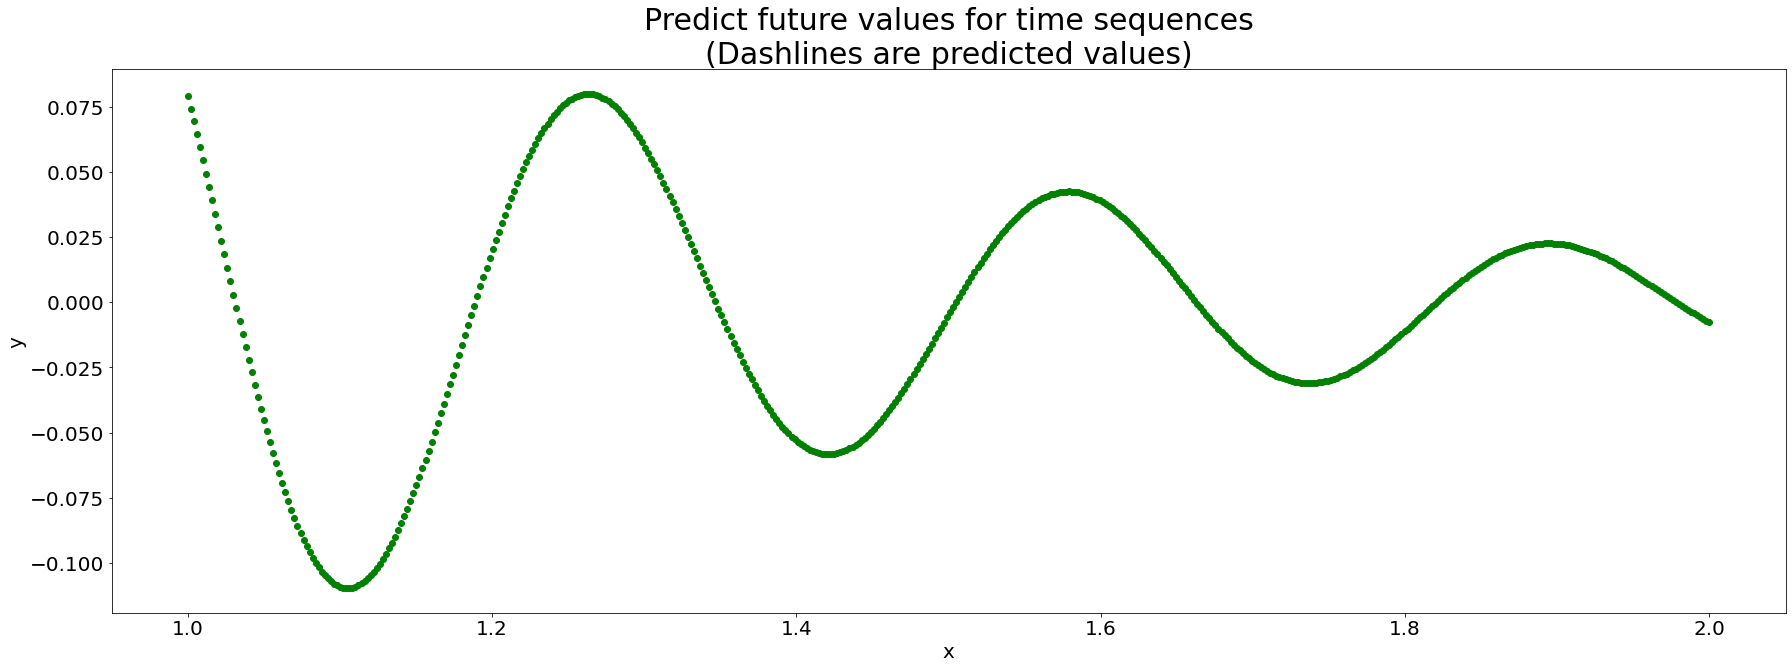

STEP:  46
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


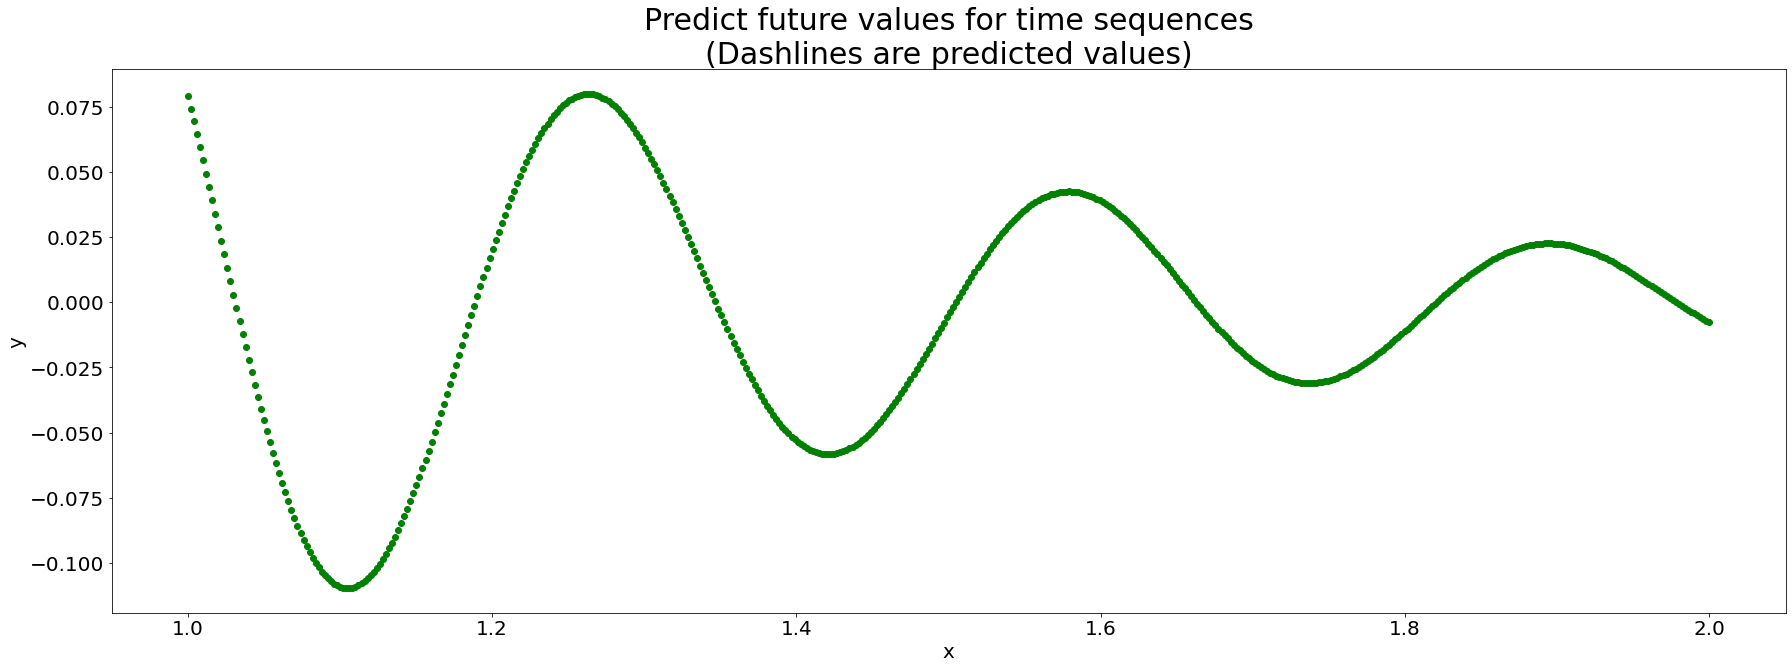

STEP:  47
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


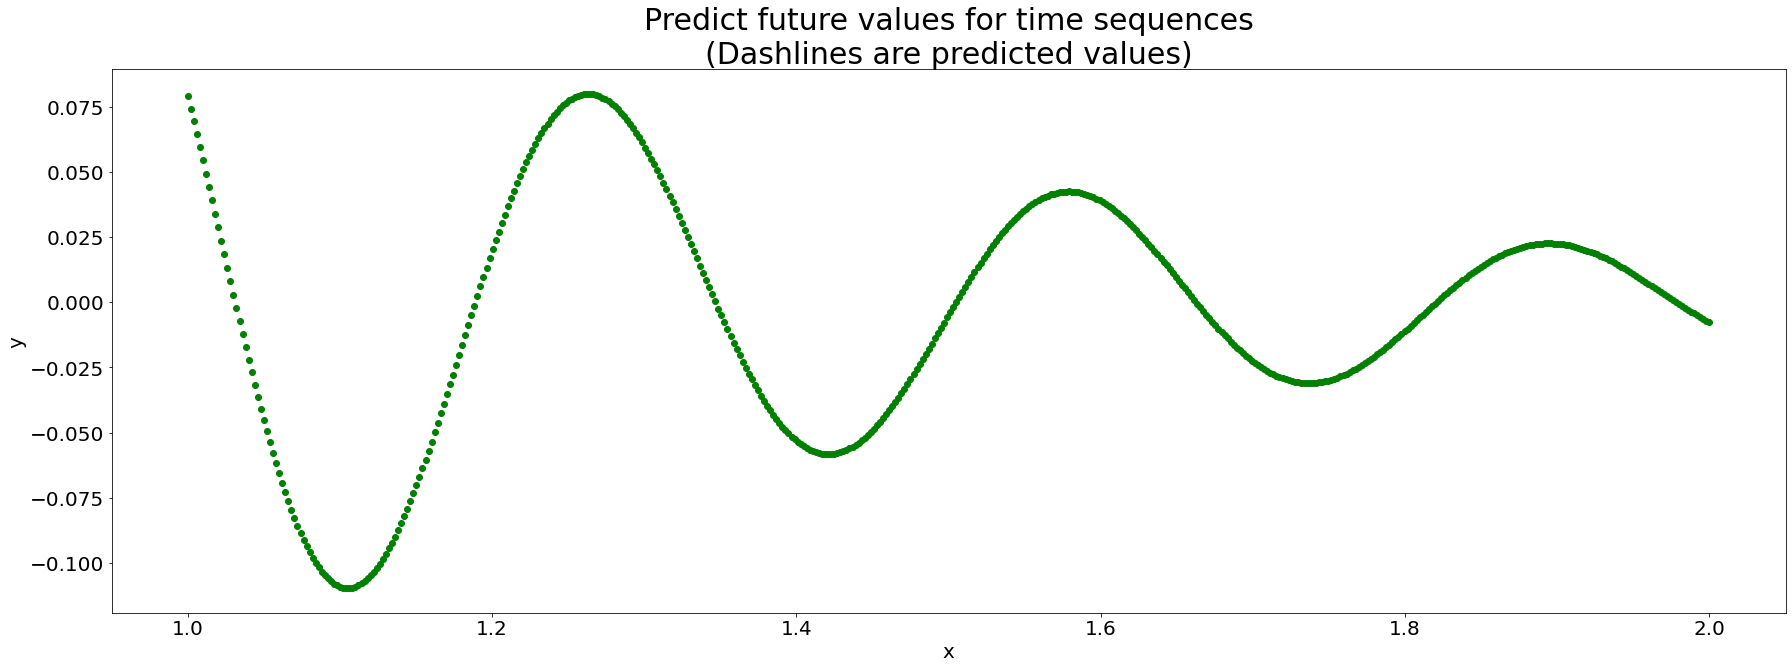

STEP:  48
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


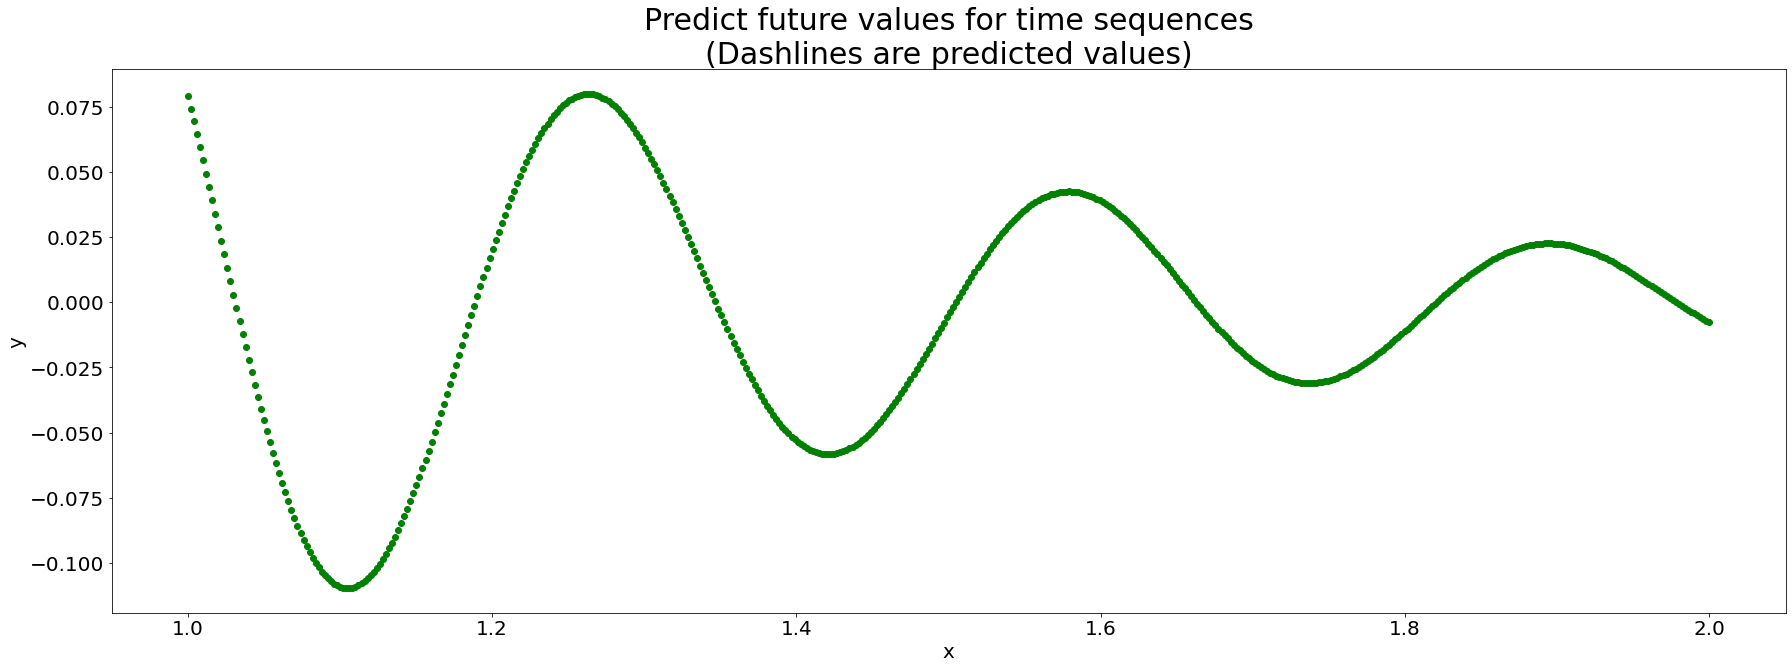

STEP:  49
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


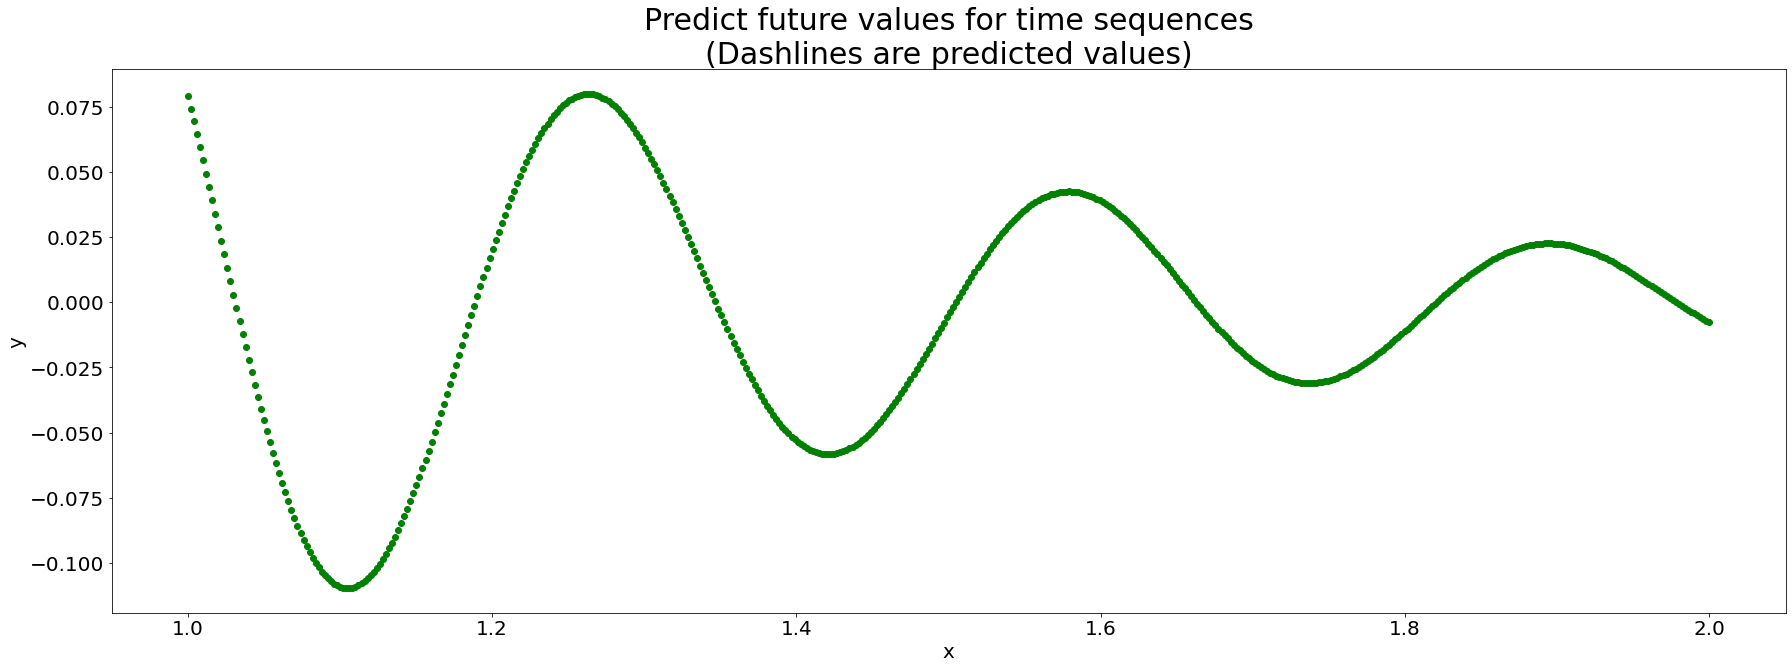

STEP:  50
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


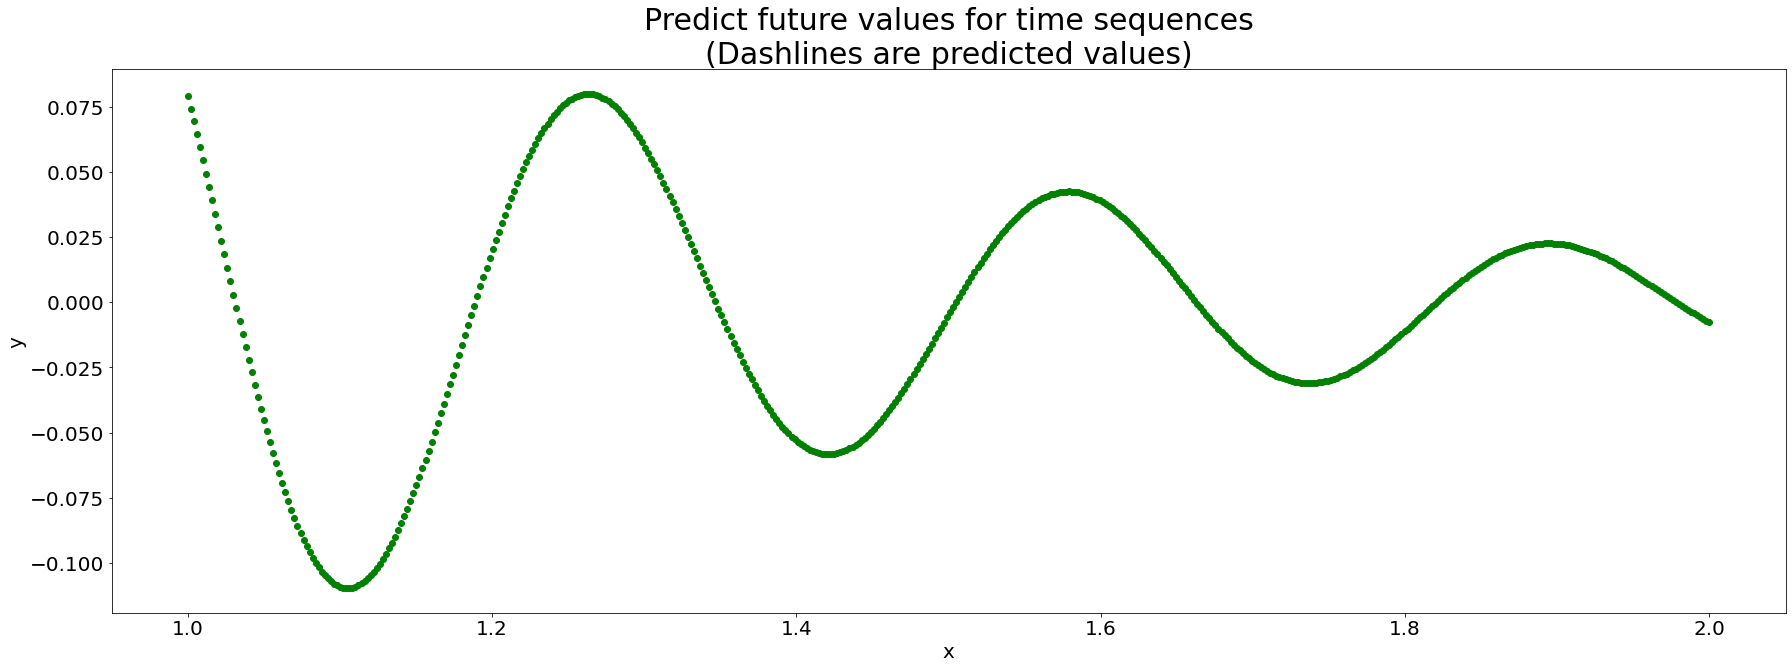

STEP:  51
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


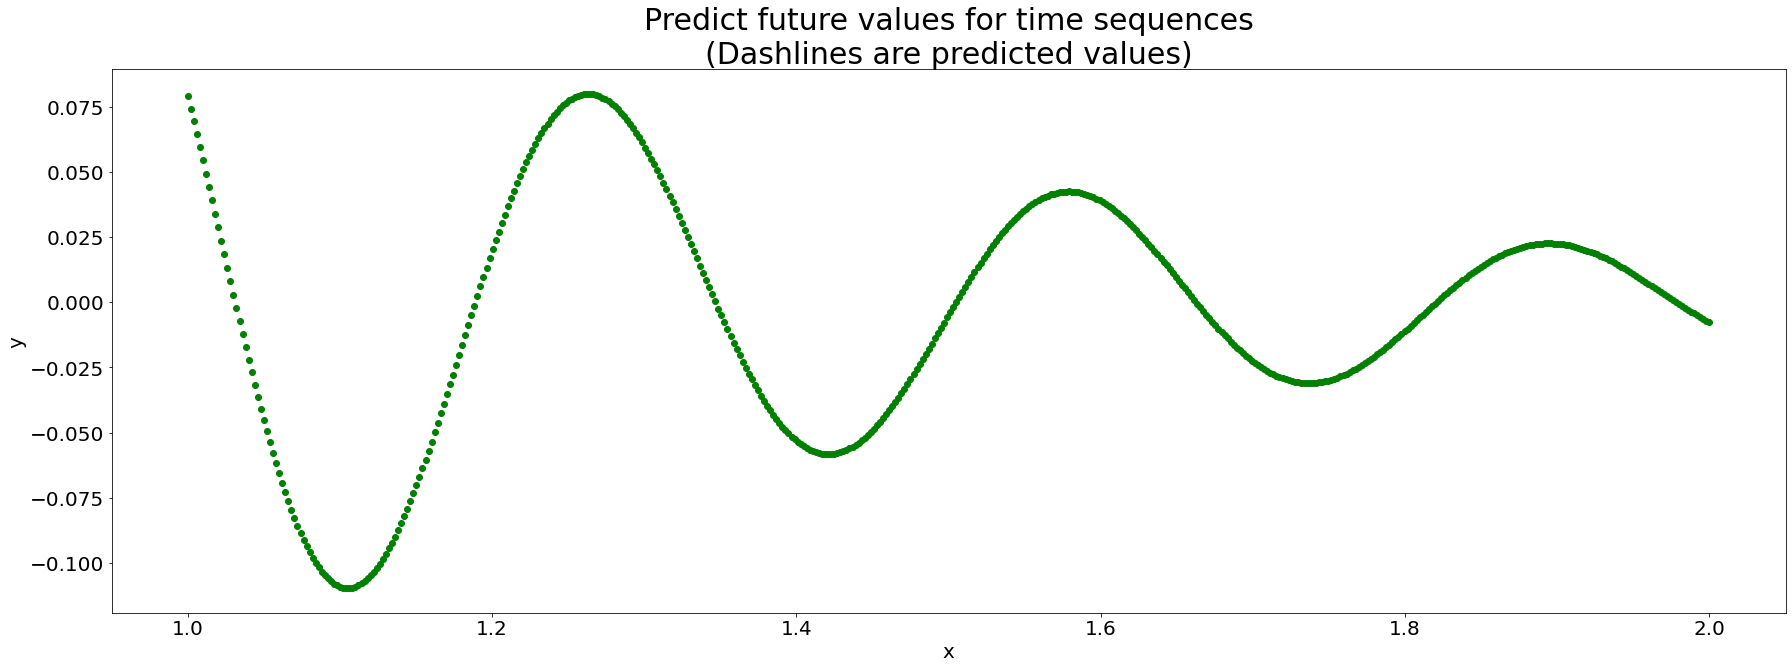

STEP:  52
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


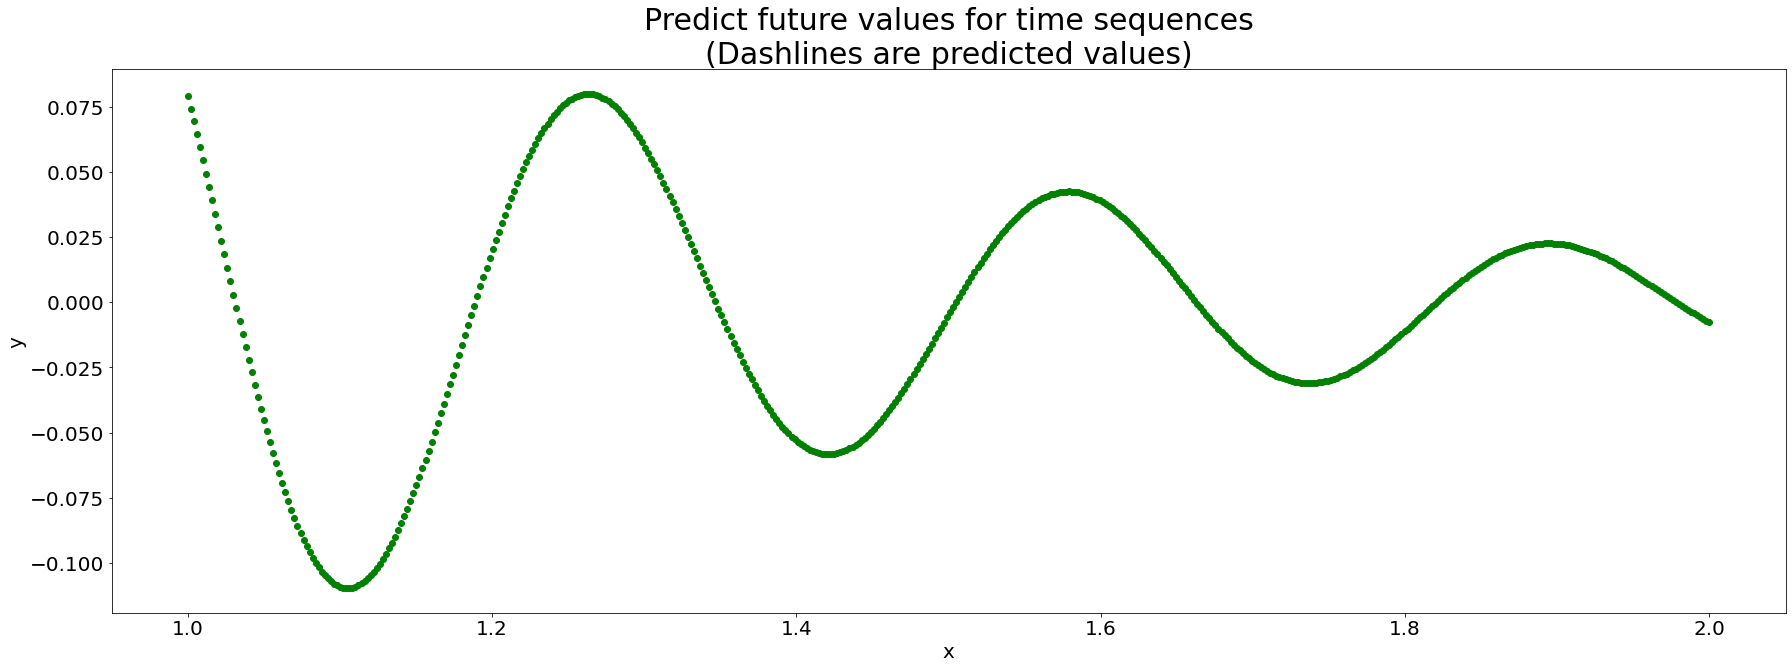

STEP:  53
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


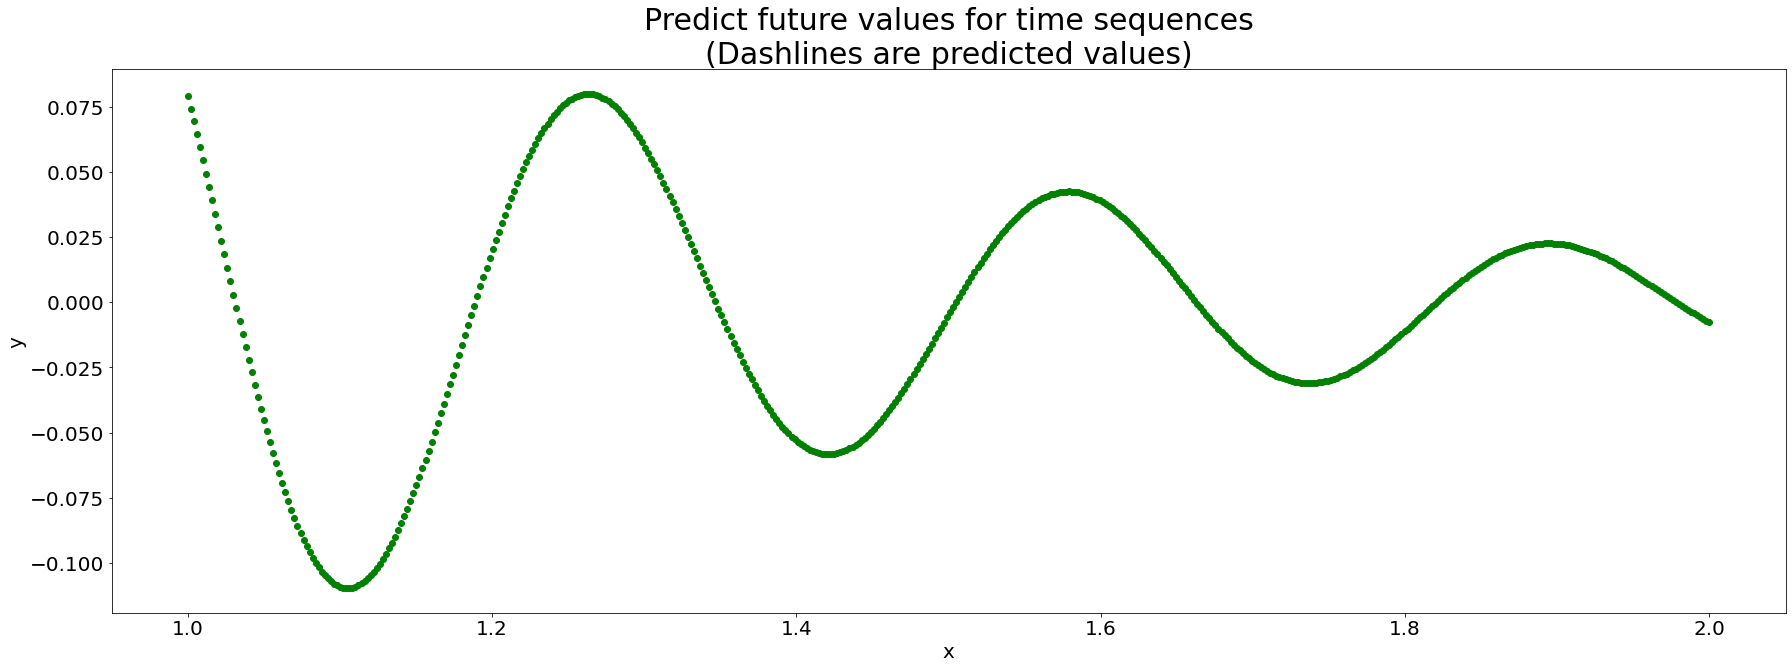

STEP:  54
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


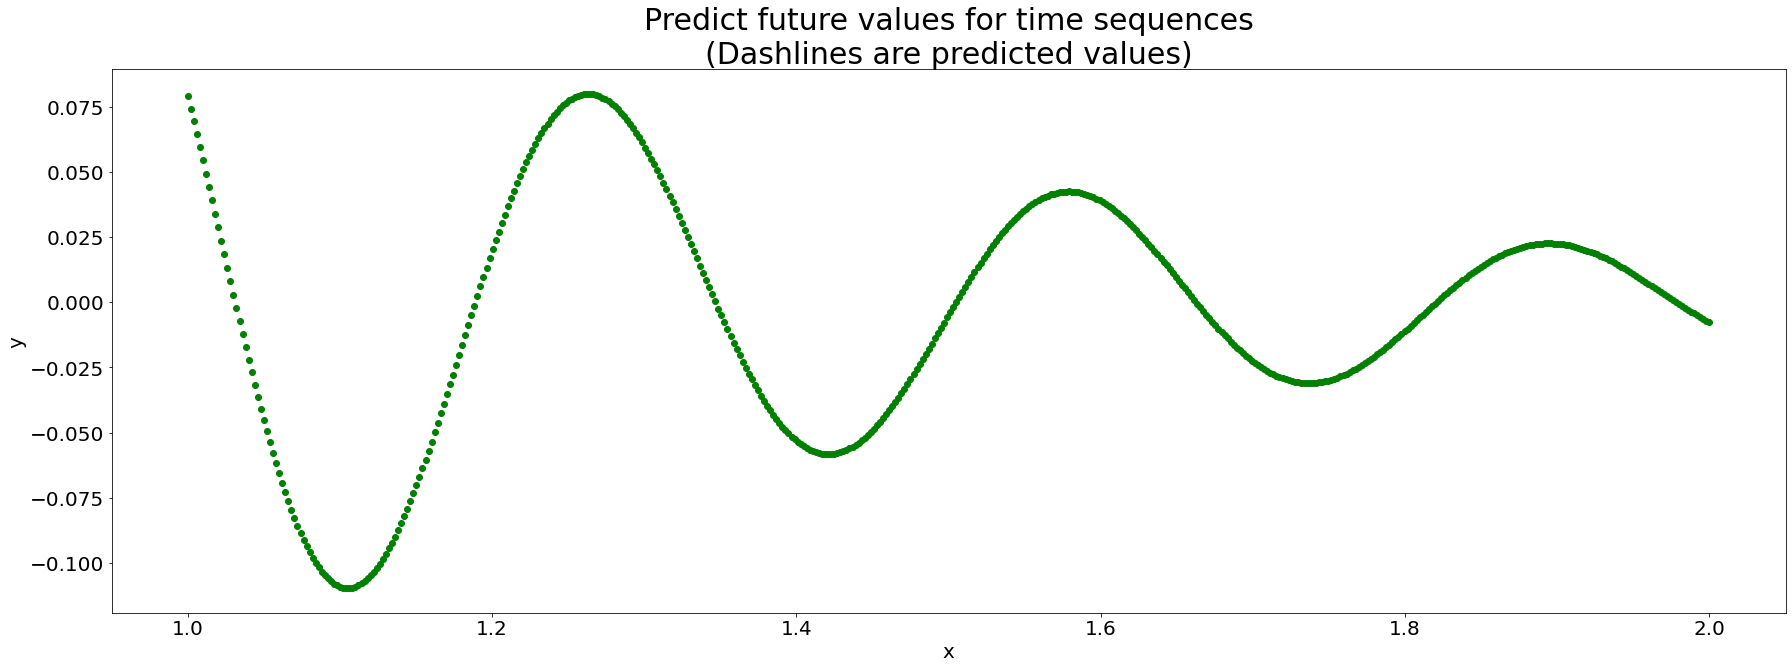

STEP:  55
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


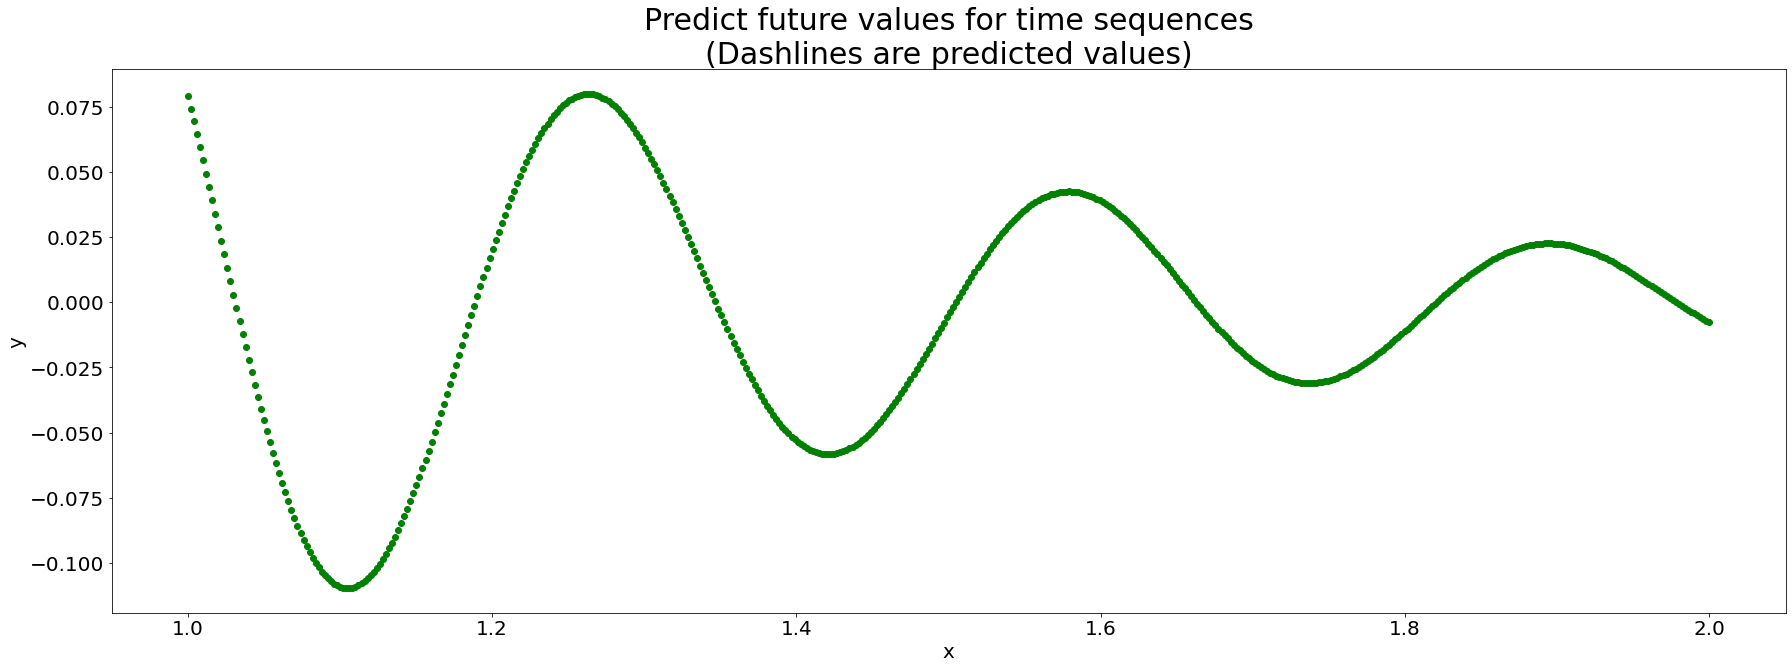

STEP:  56
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


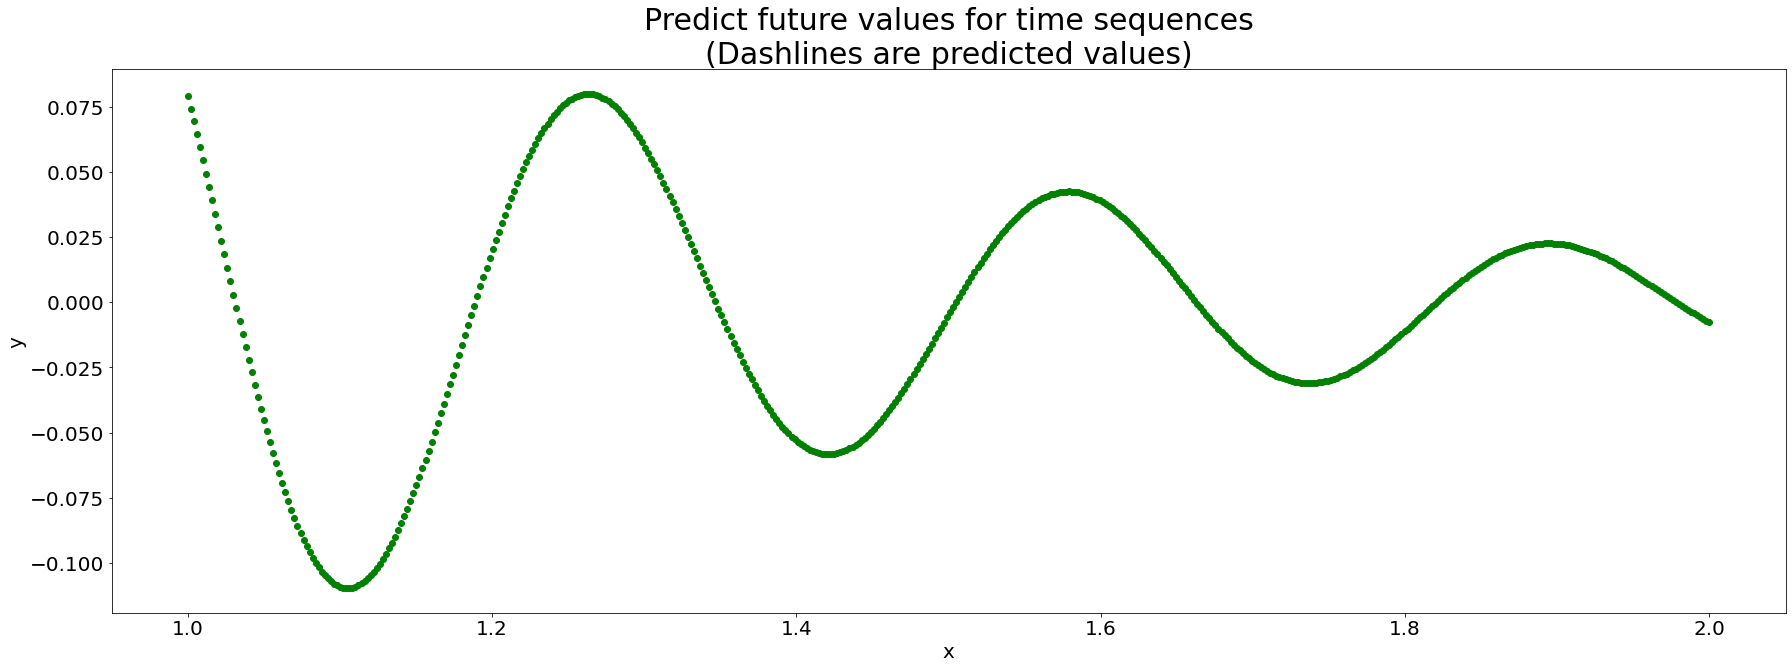

STEP:  57
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


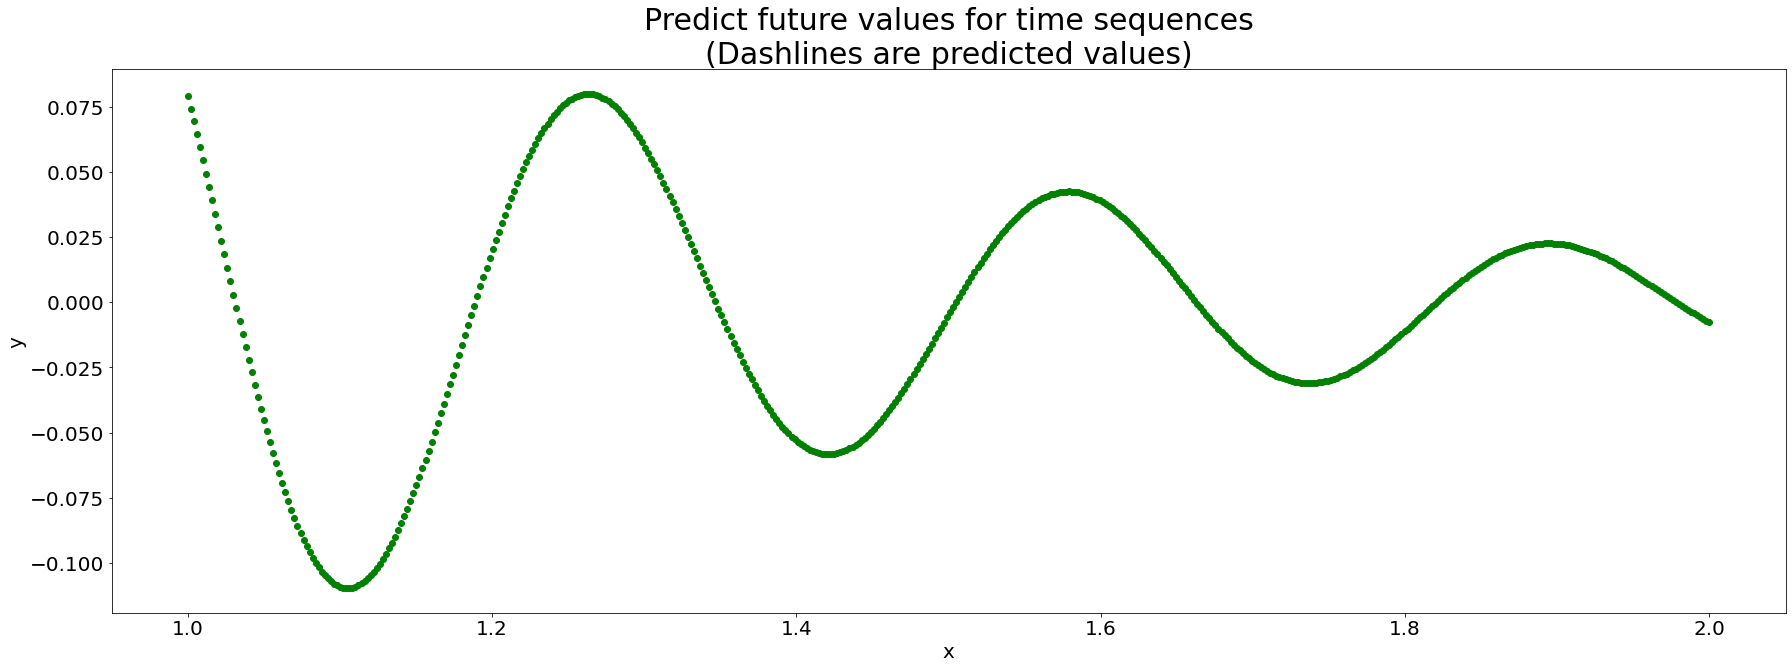

STEP:  58
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


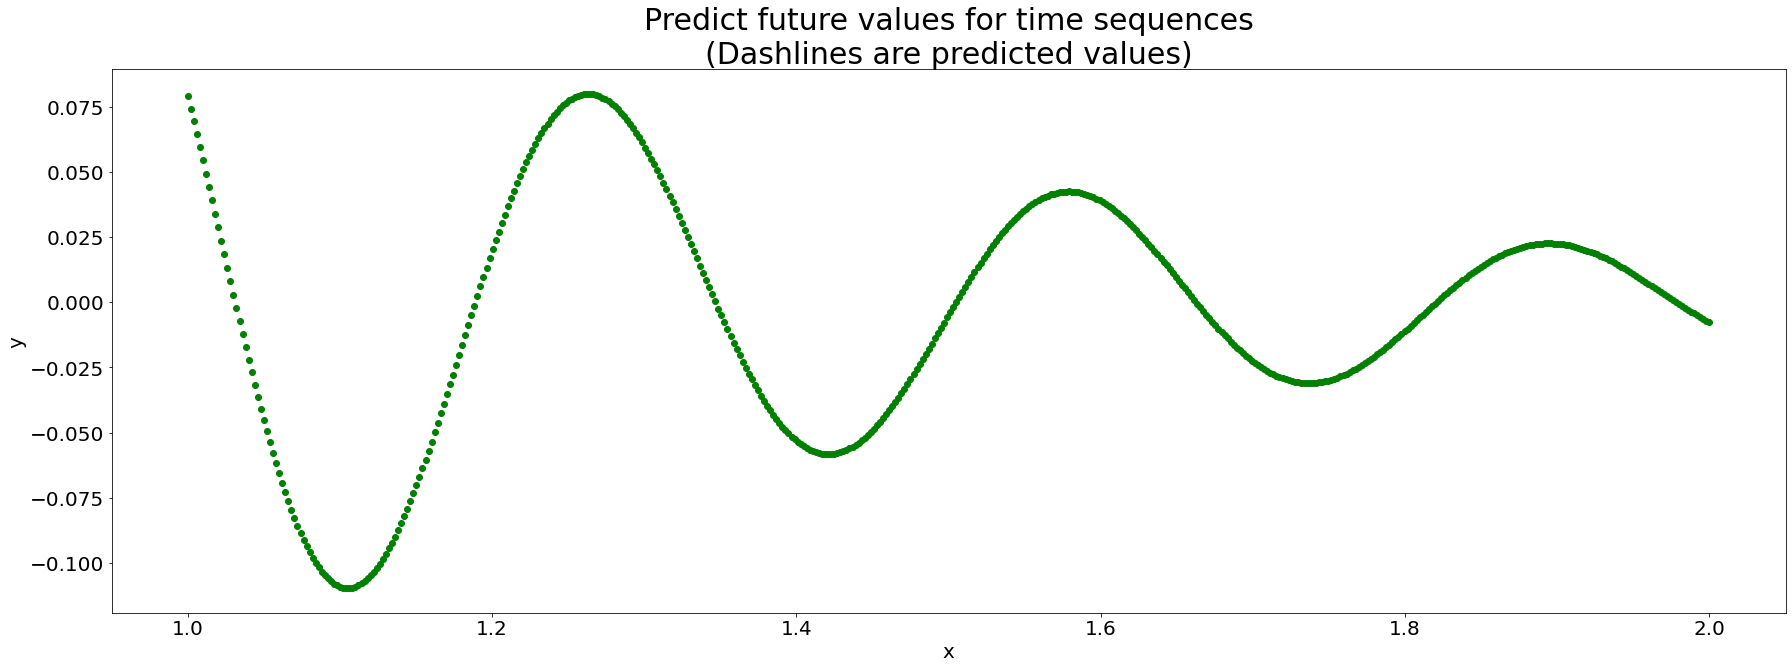

STEP:  59
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


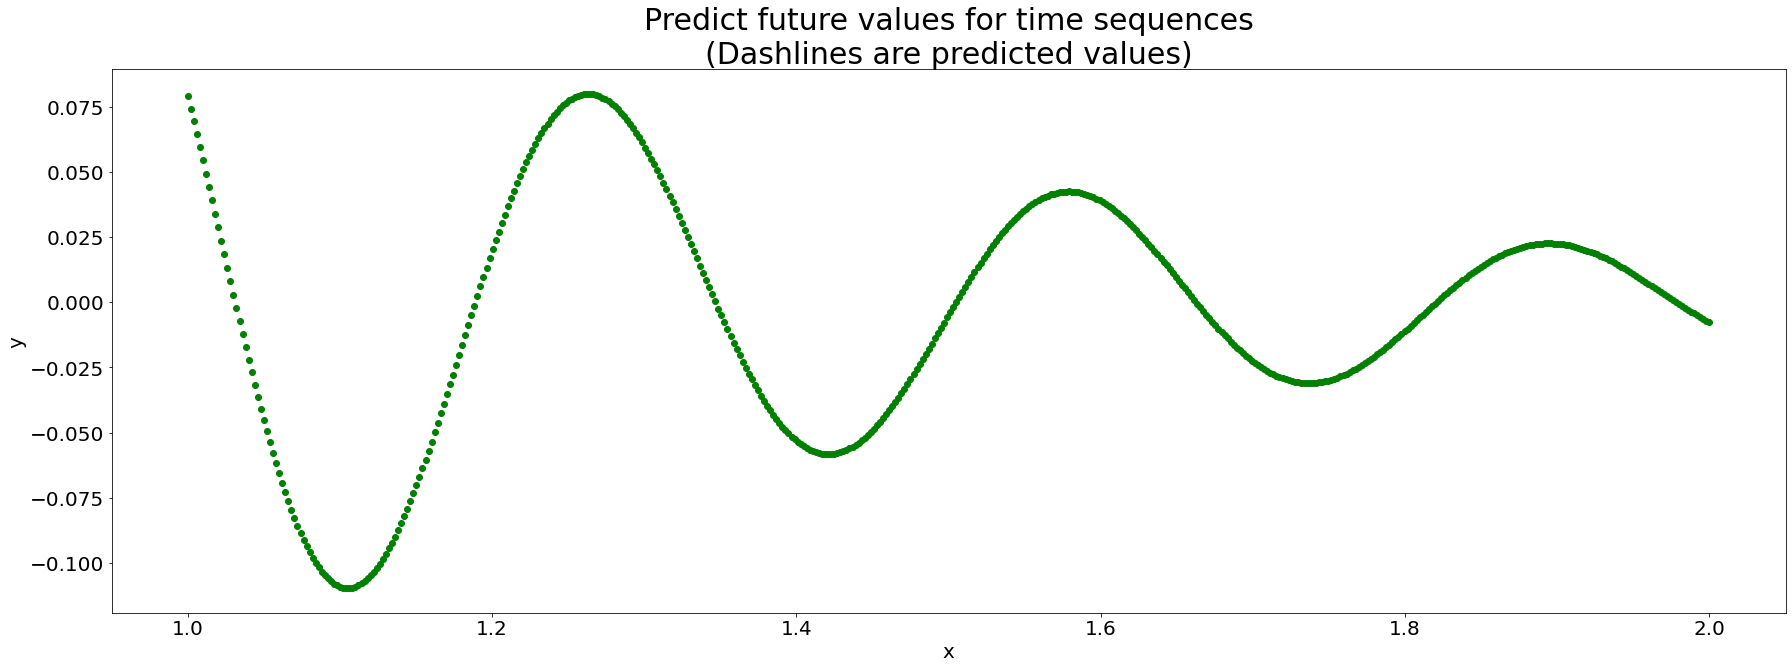

STEP:  60
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


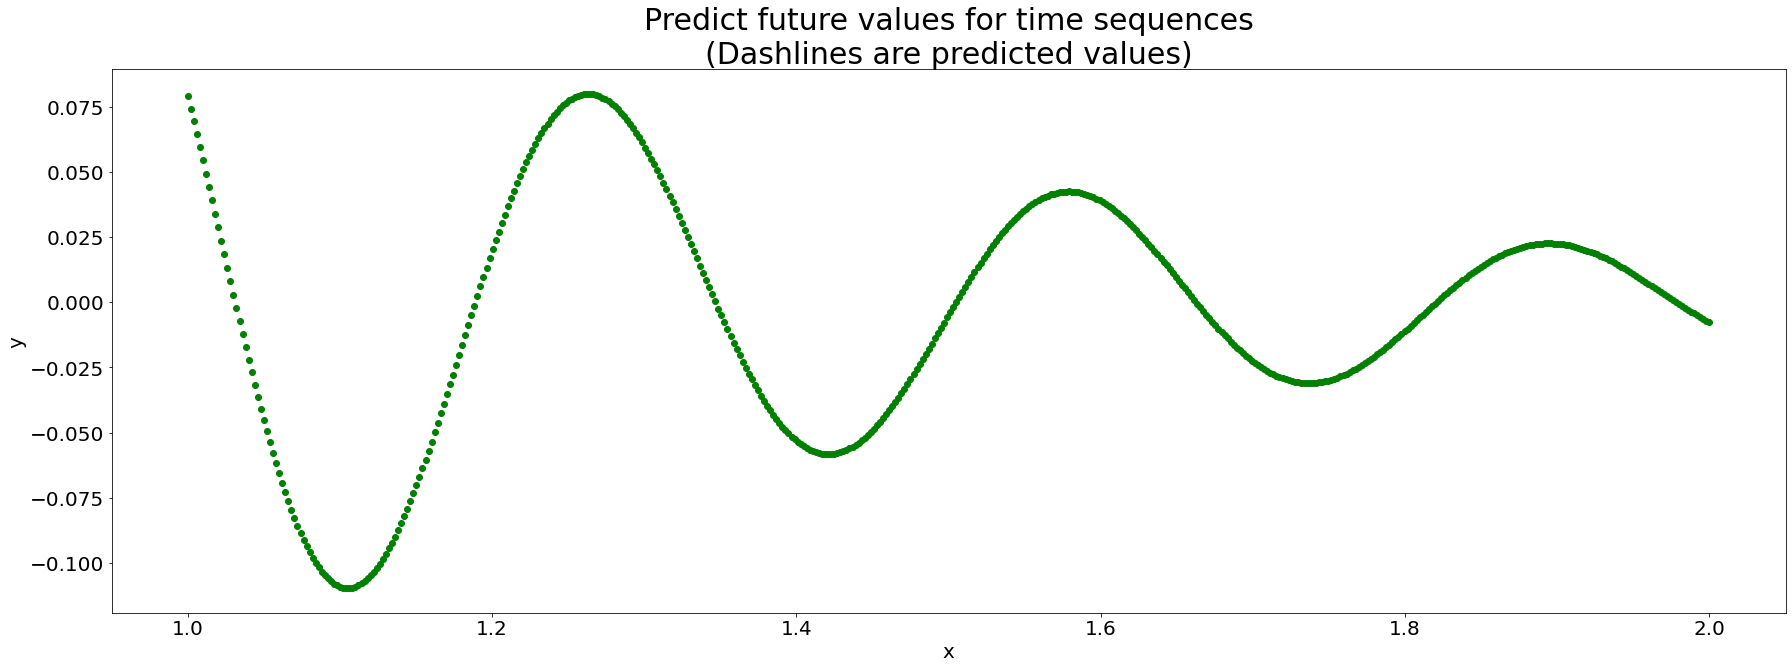

STEP:  61
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


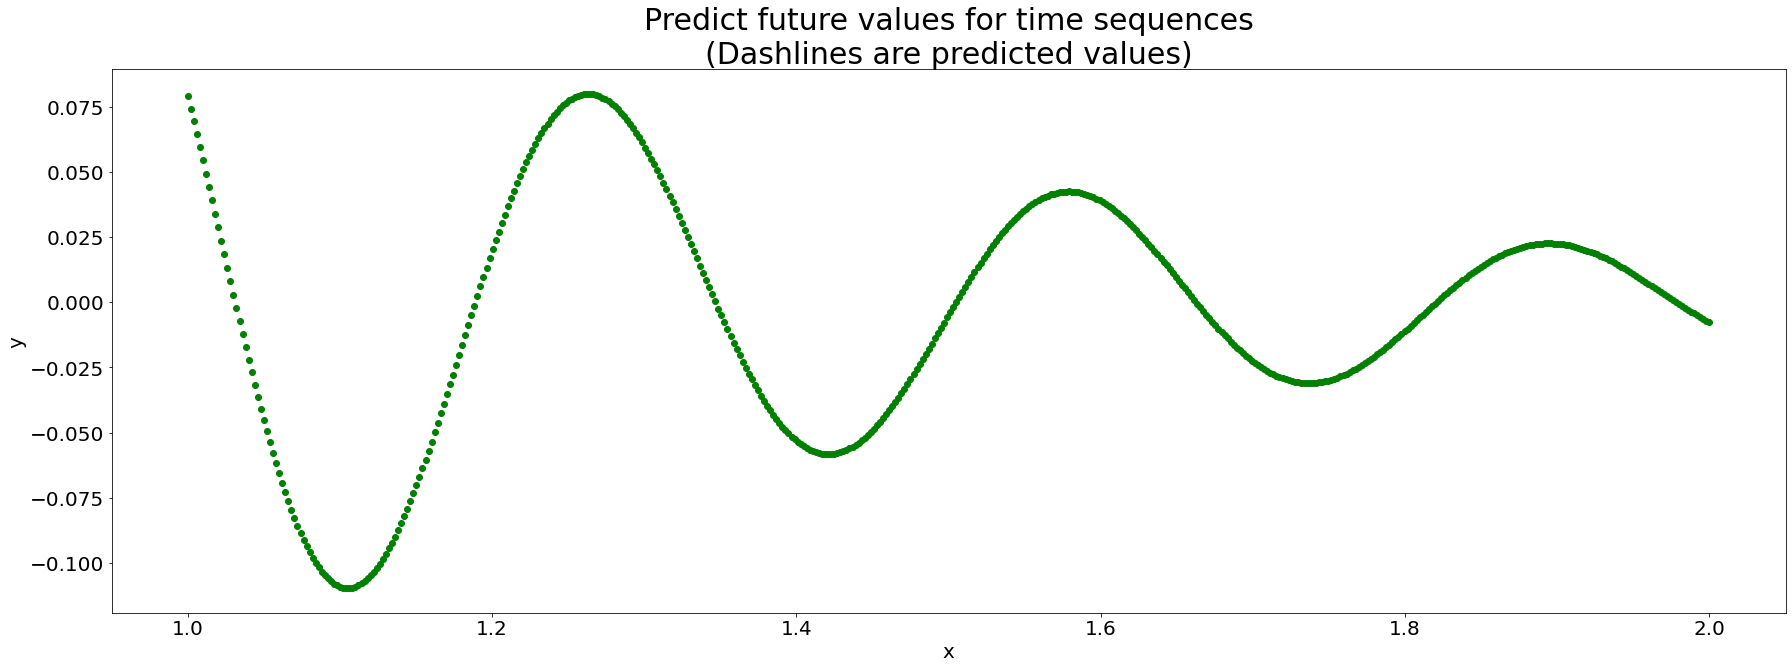

STEP:  62
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


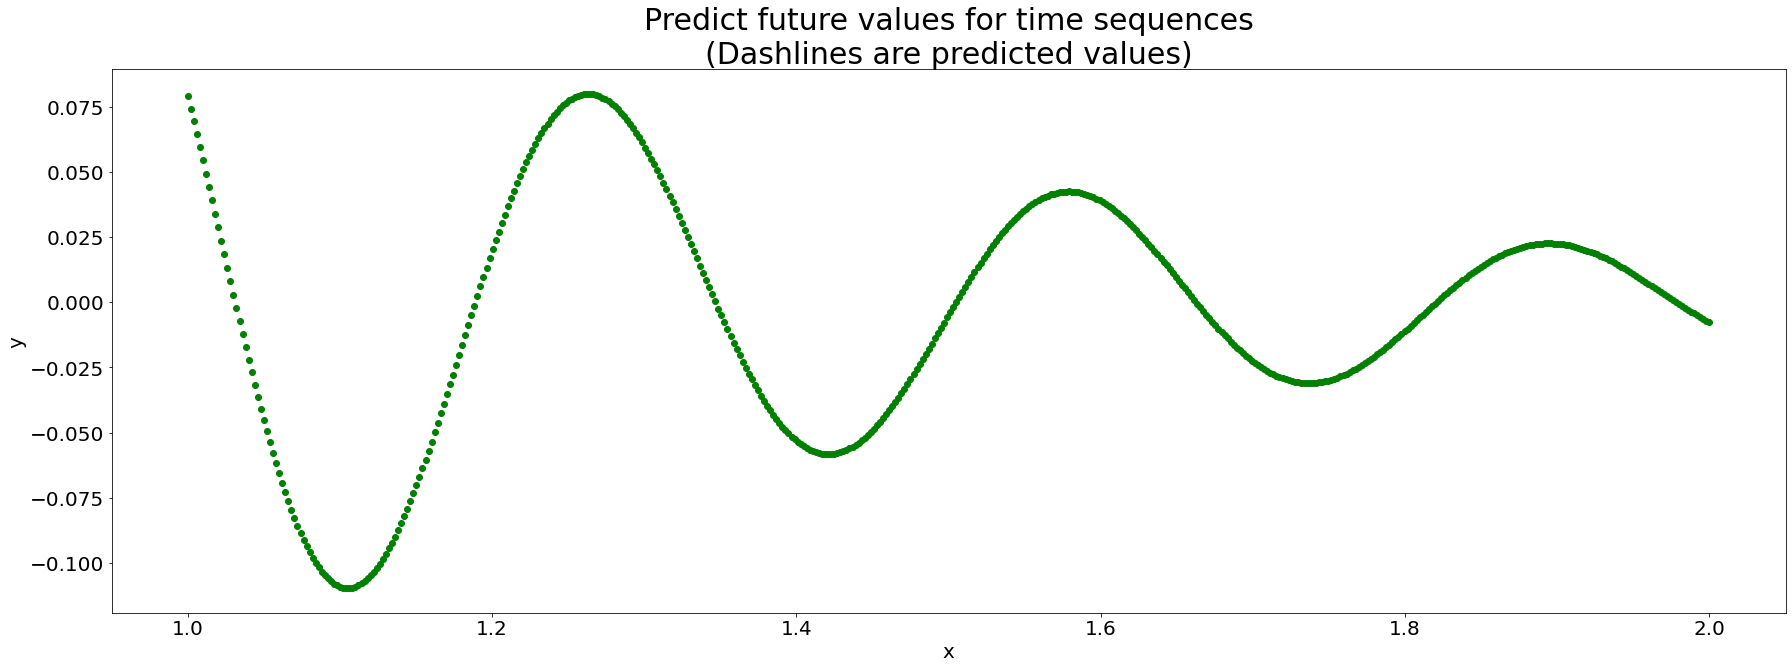

STEP:  63
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


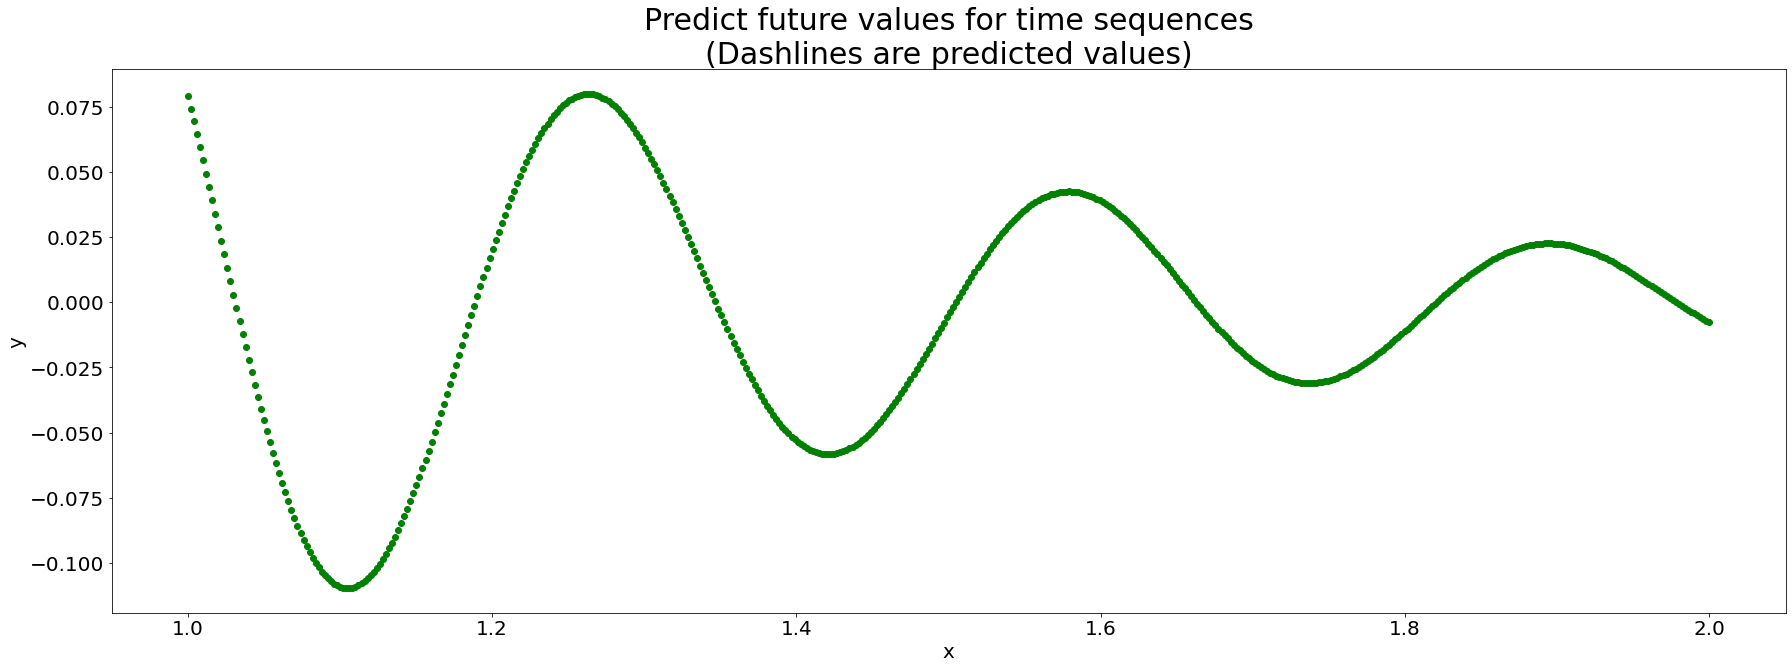

STEP:  64
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


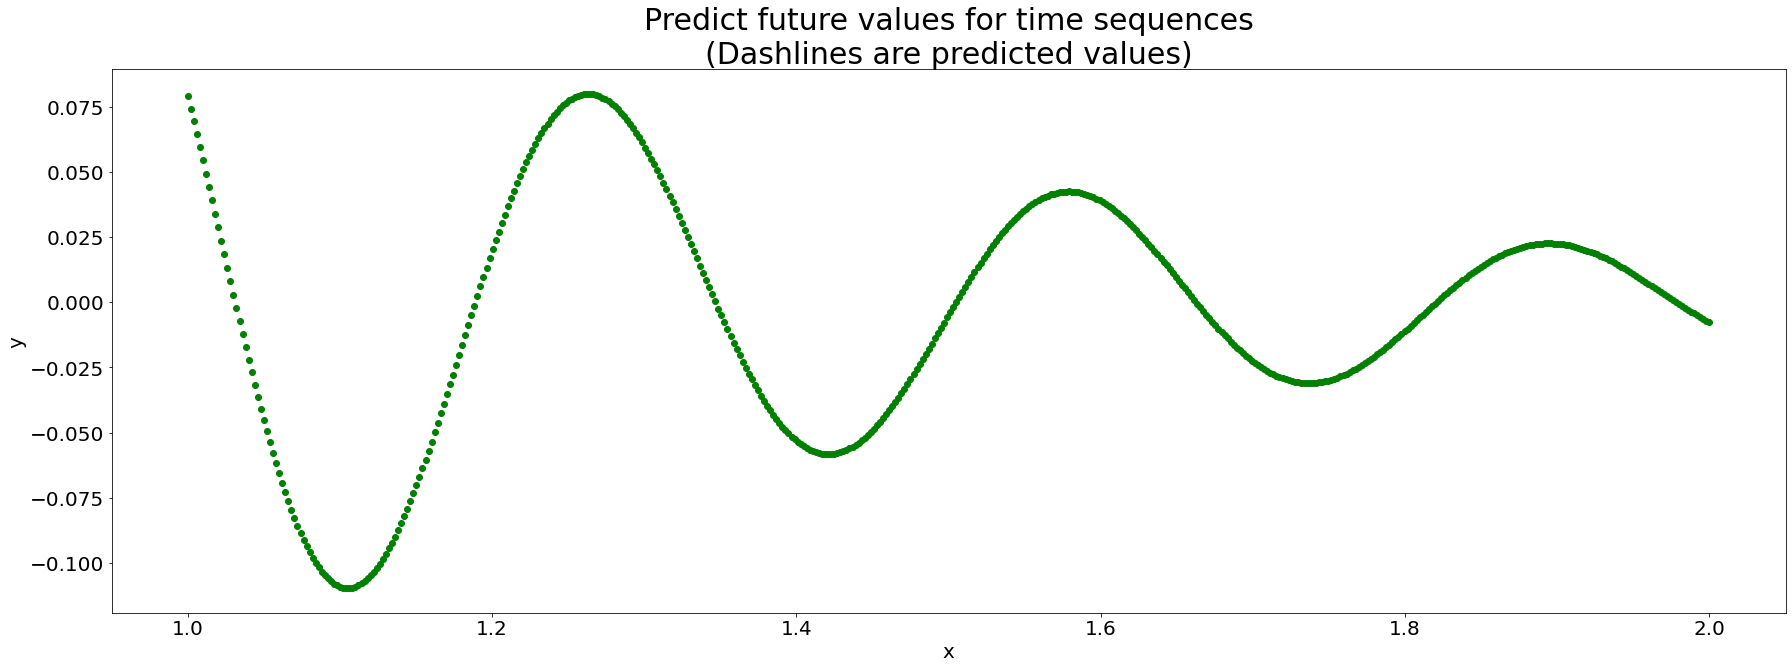

STEP:  65
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


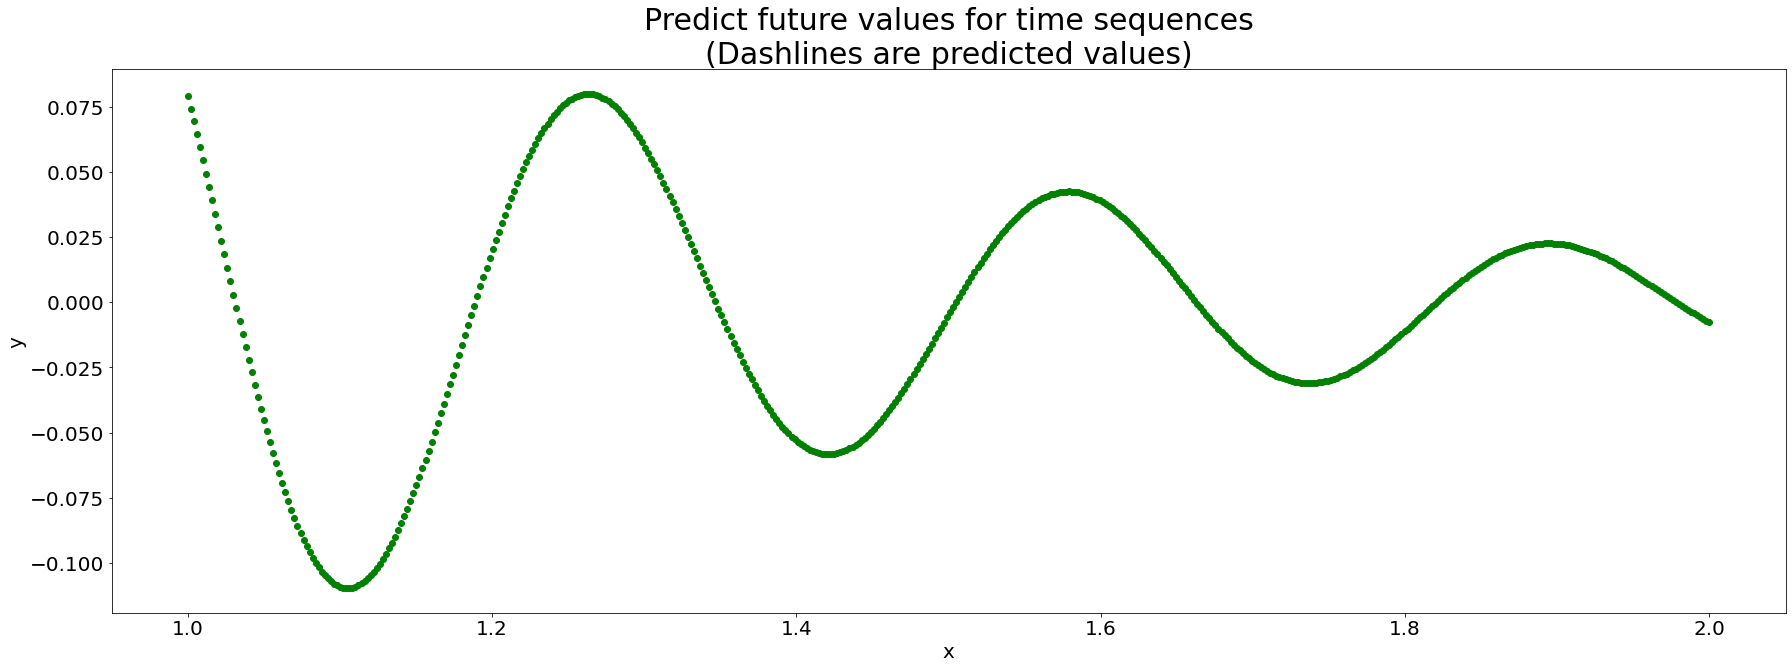

STEP:  66
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


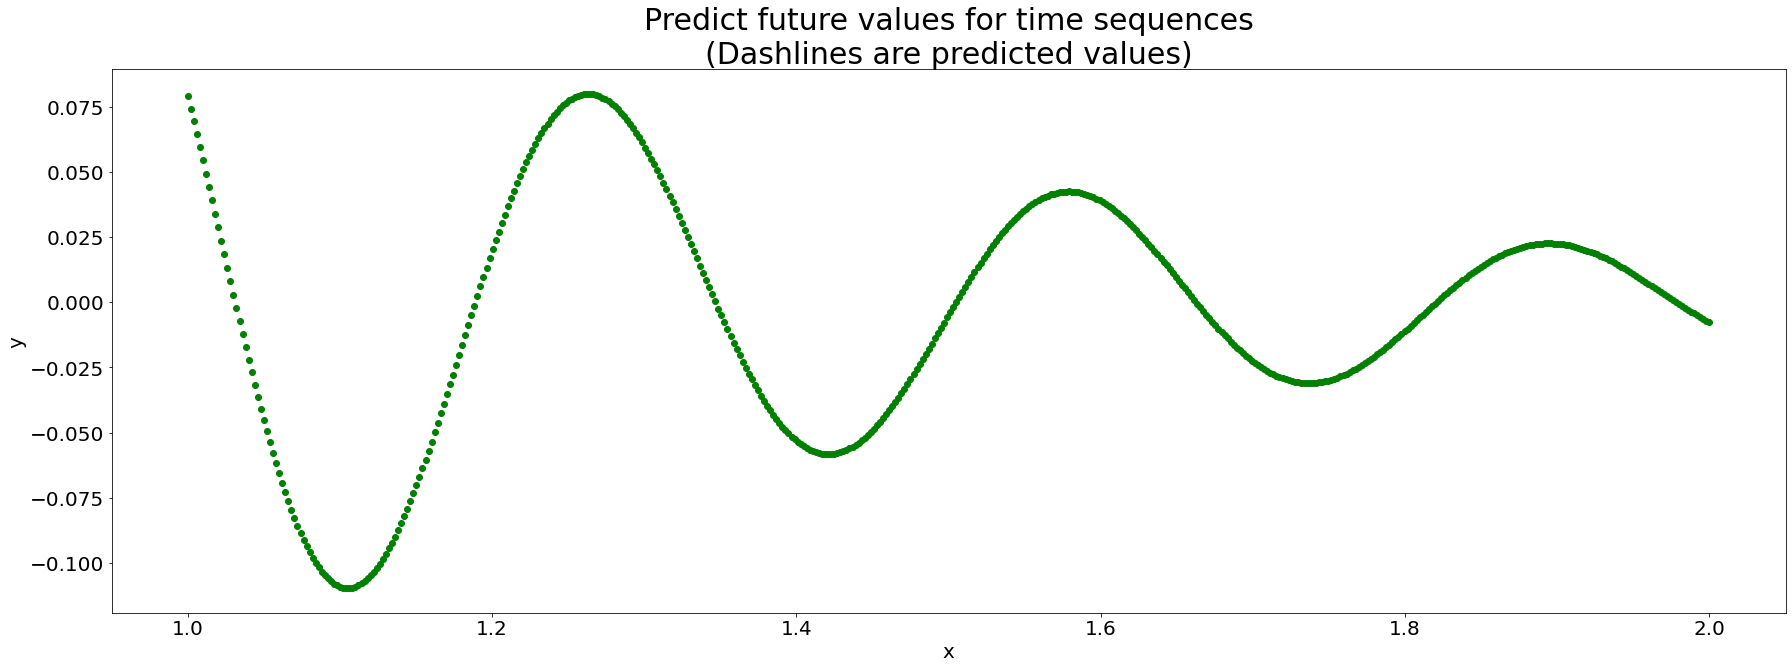

STEP:  67
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


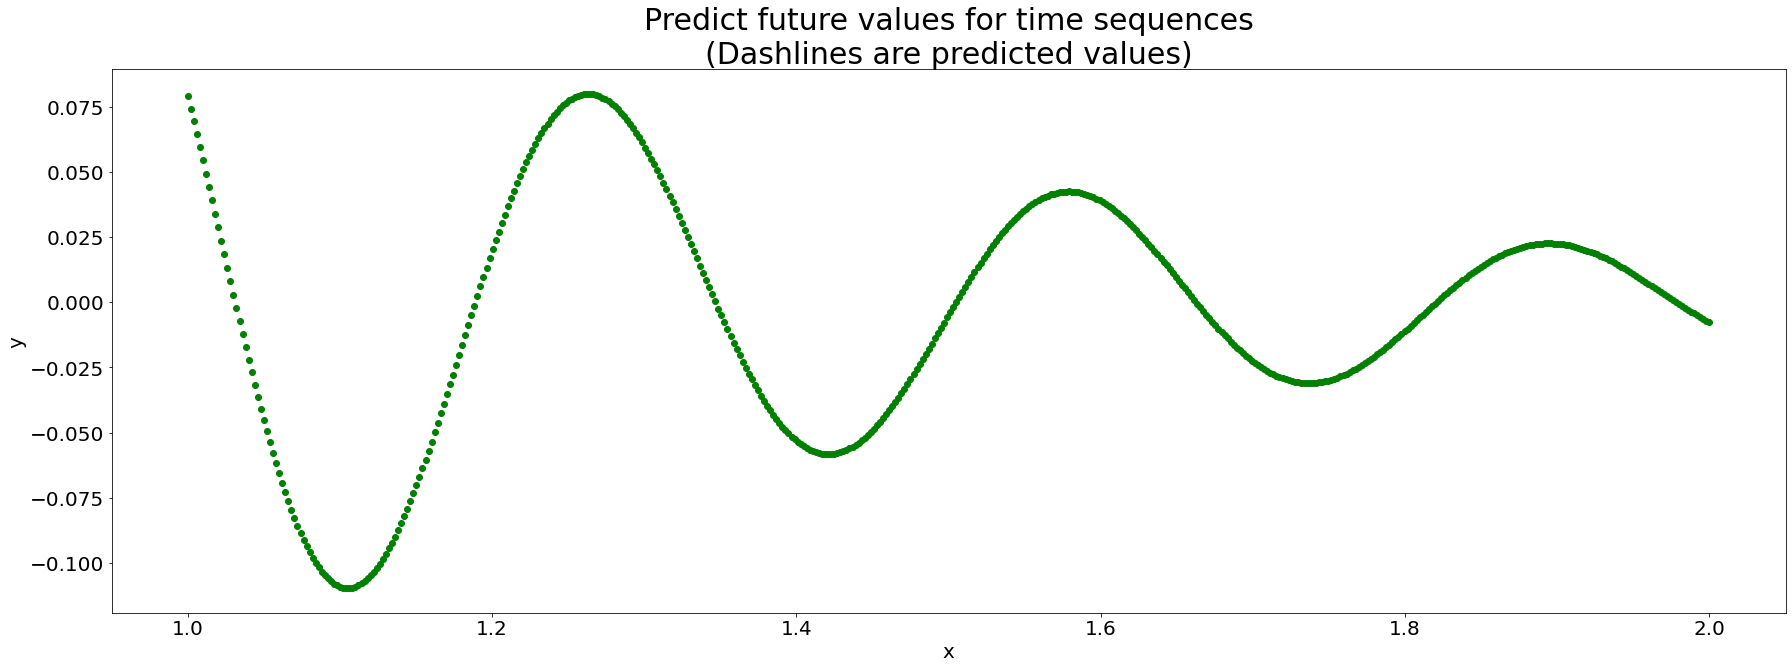

STEP:  68
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


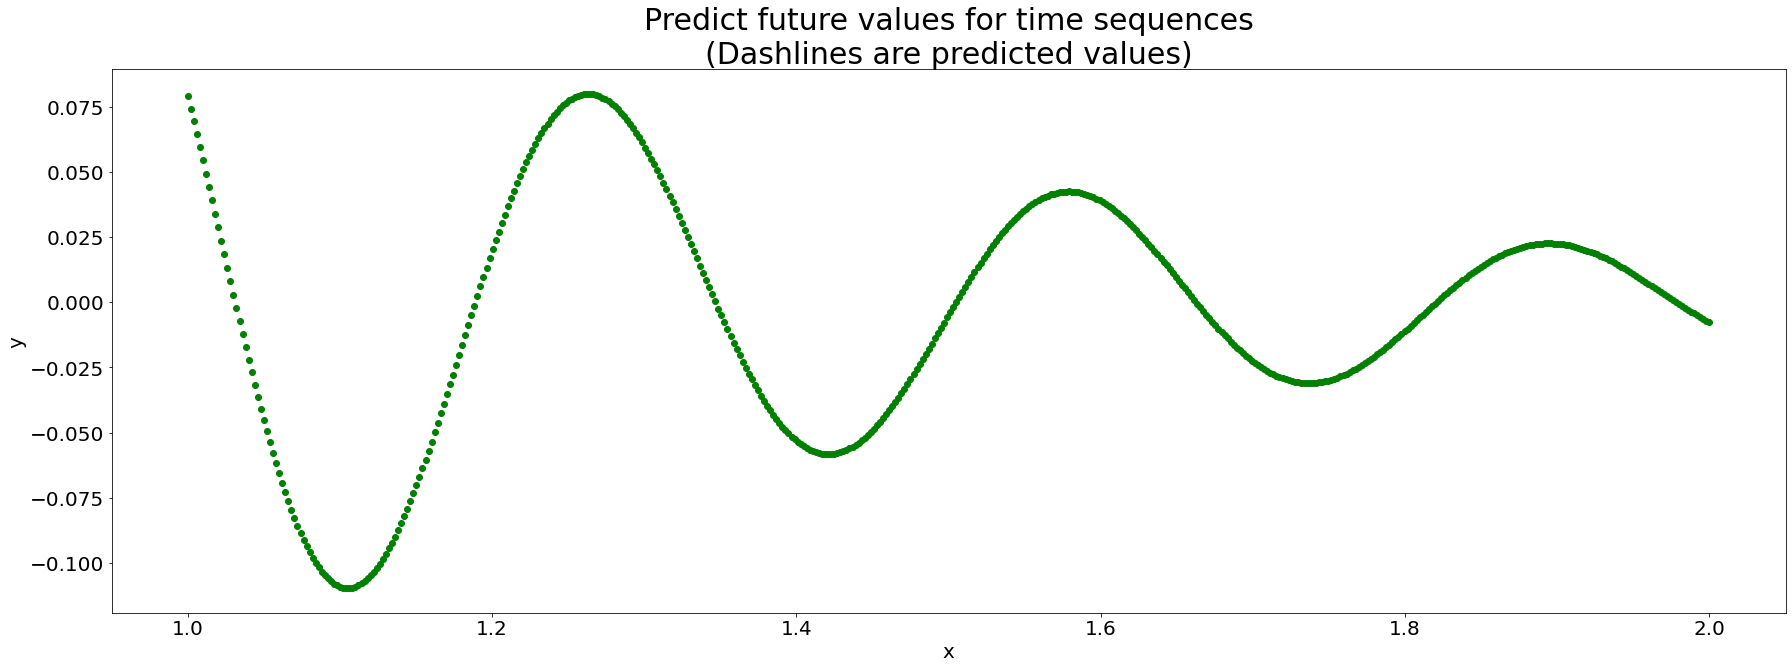

STEP:  69
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


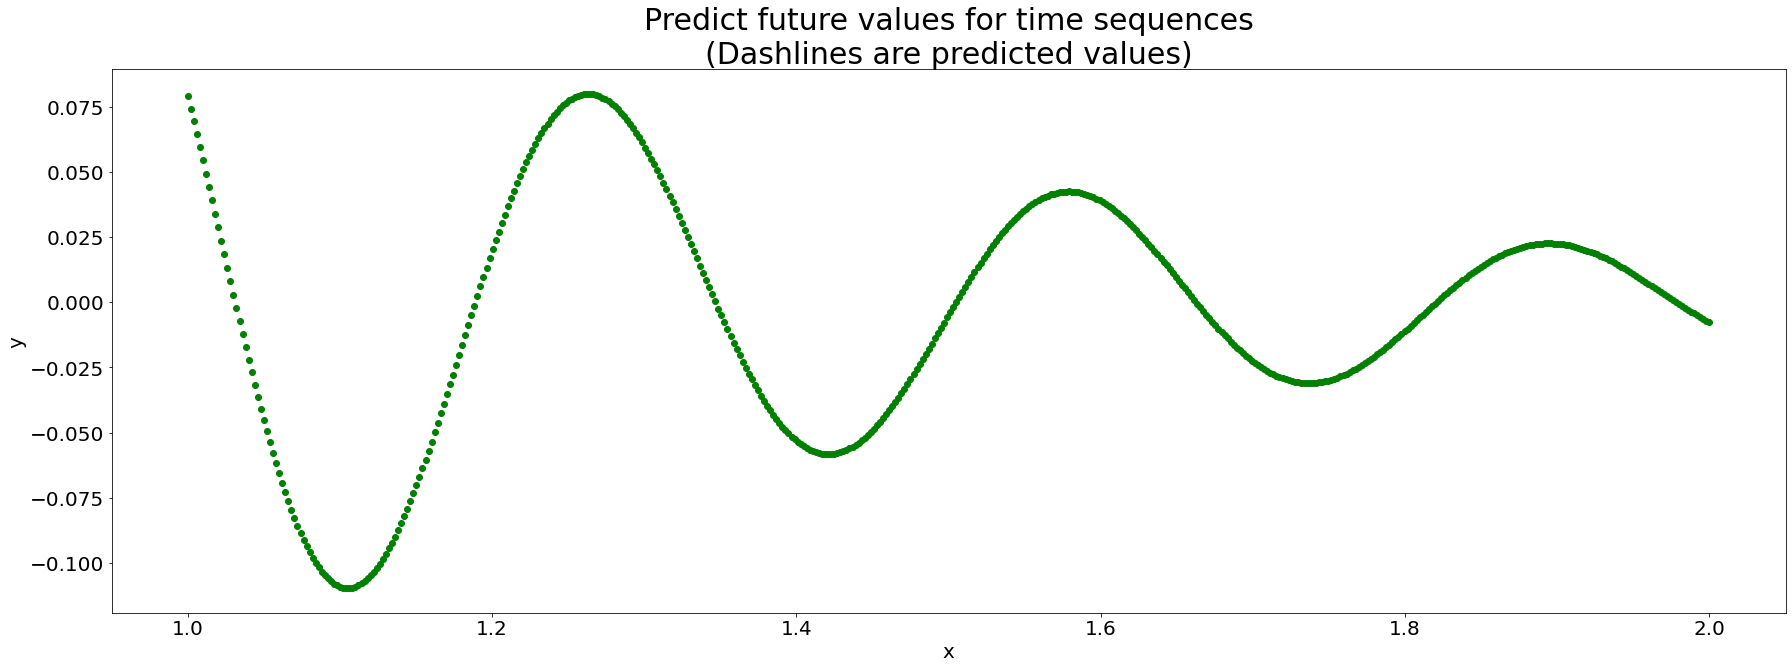

STEP:  70
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


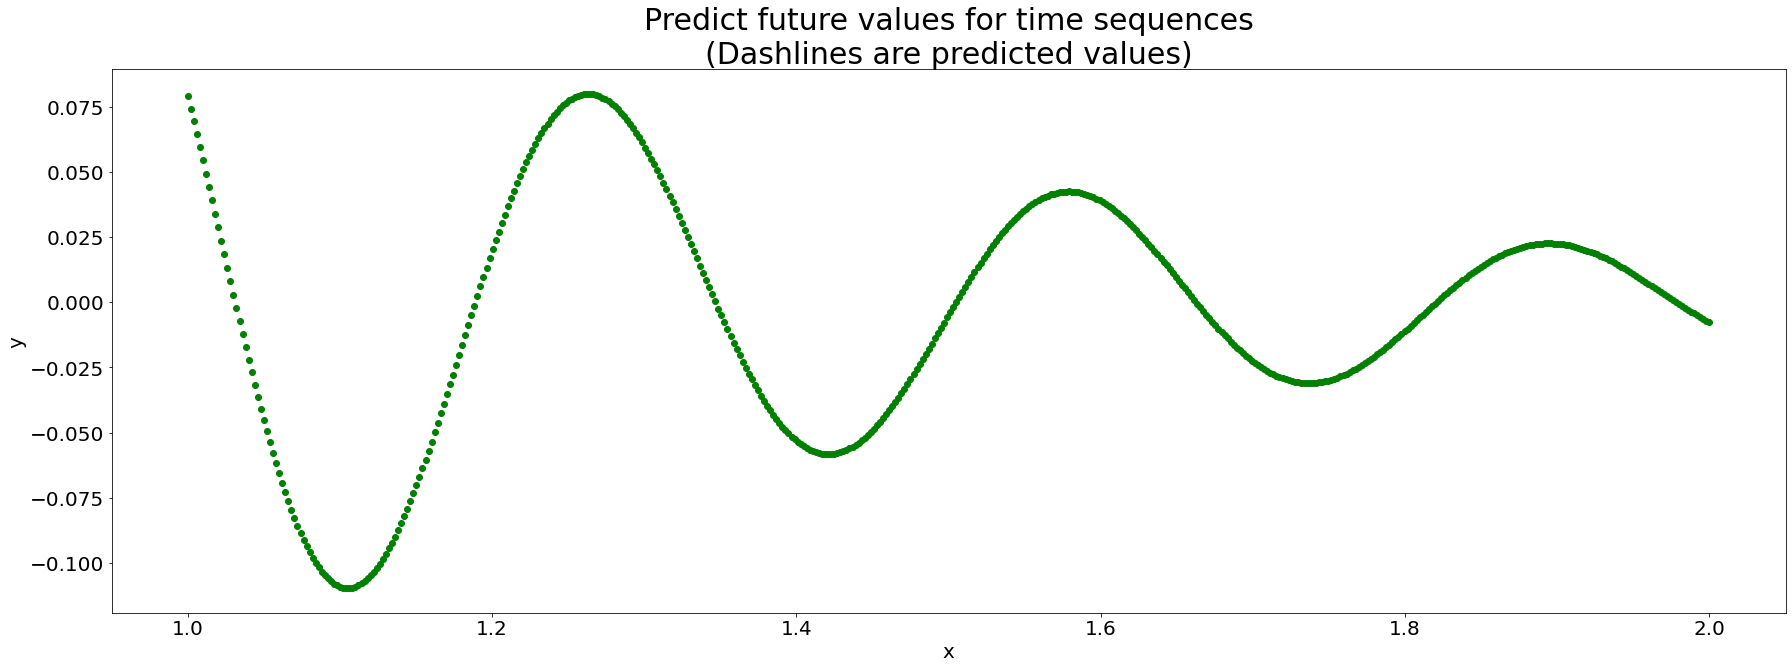

STEP:  71
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


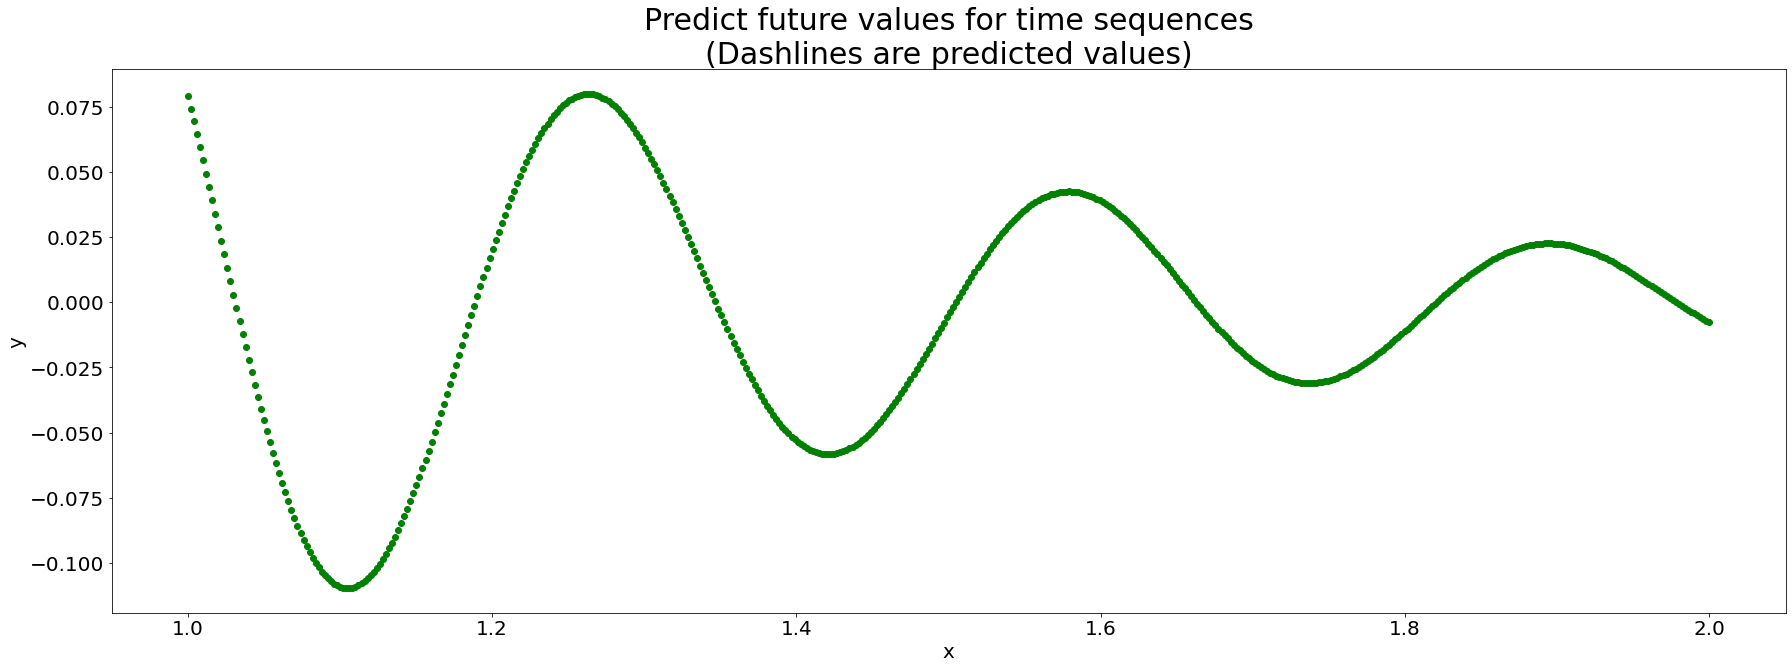

STEP:  72
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


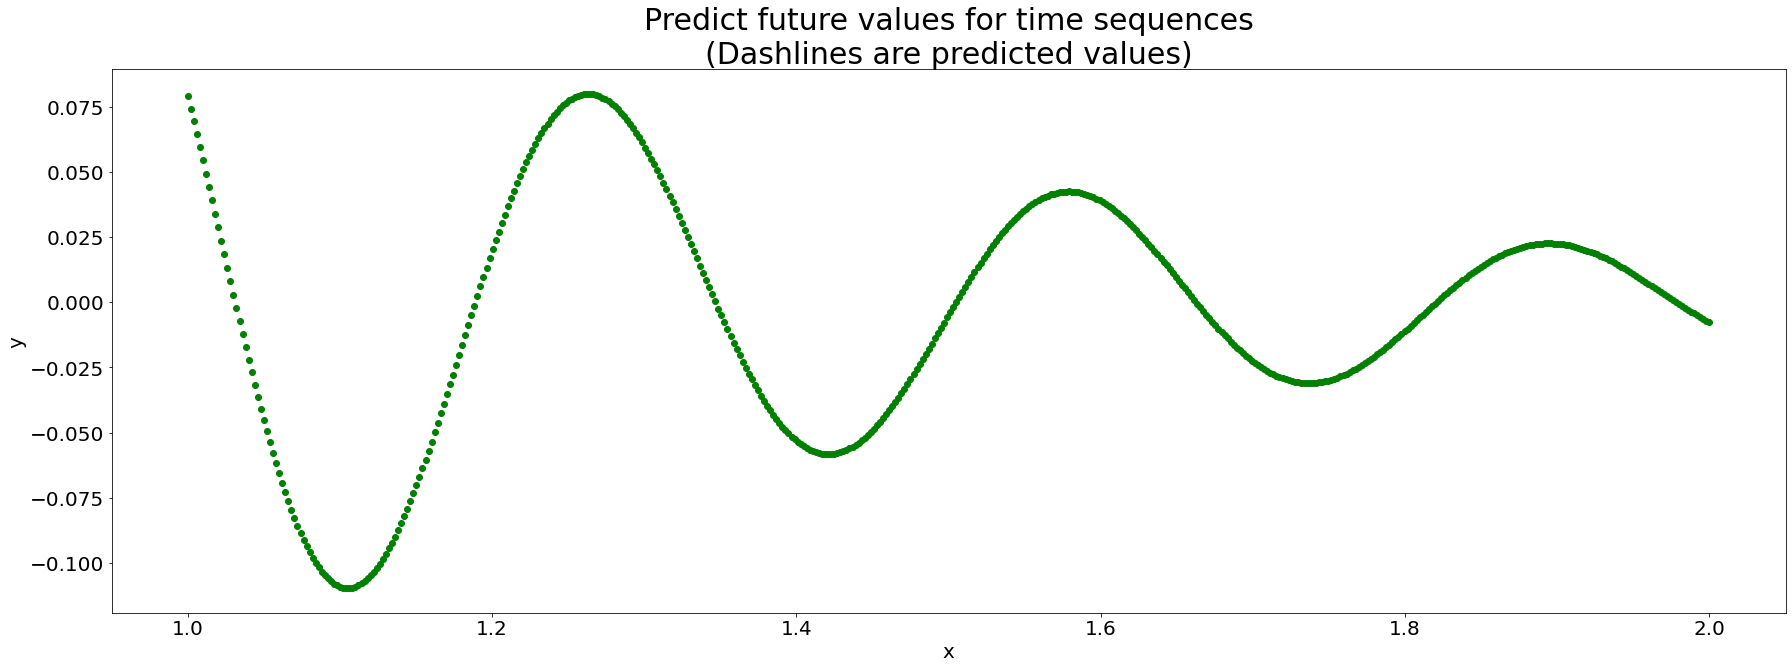

STEP:  73
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


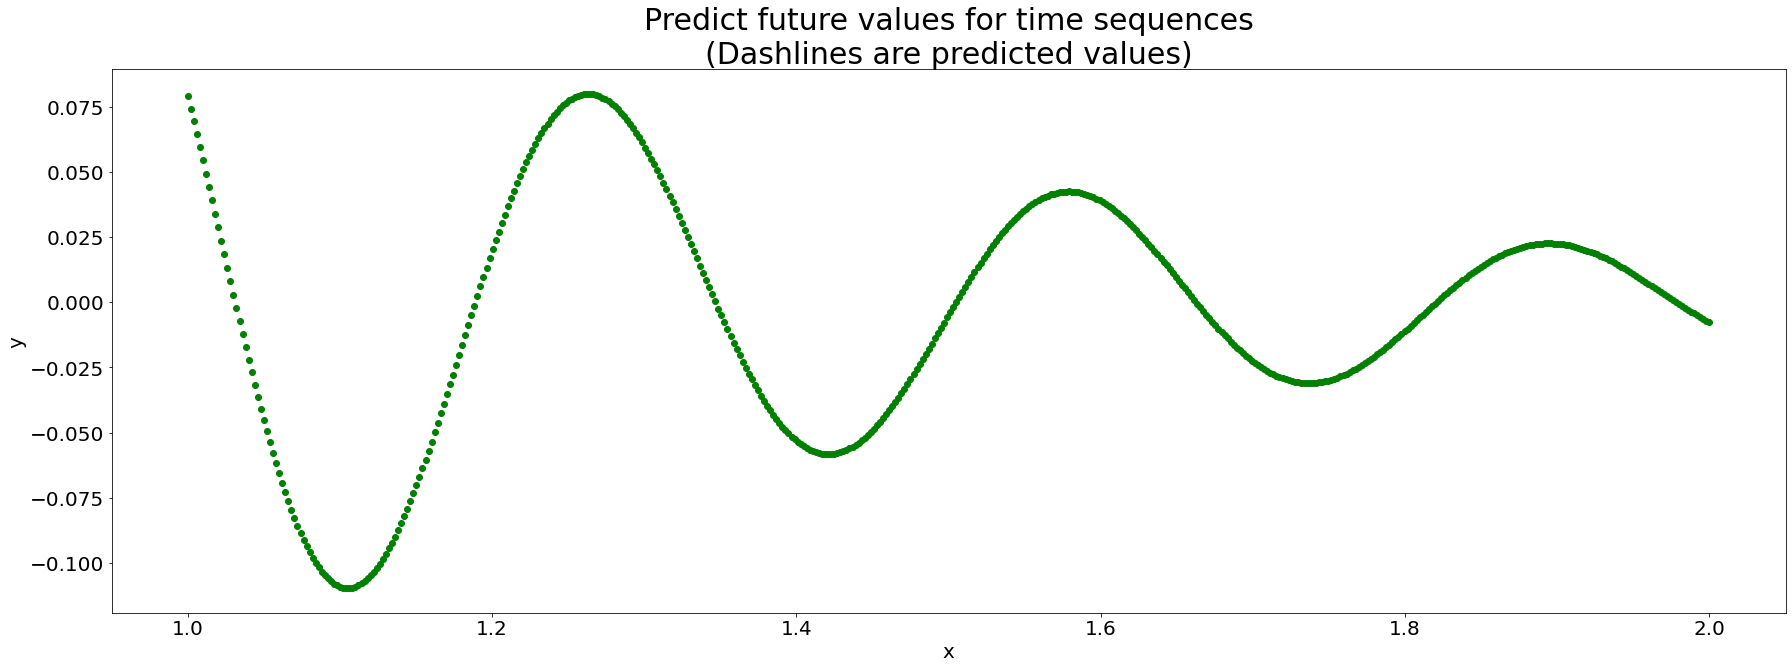

STEP:  74
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


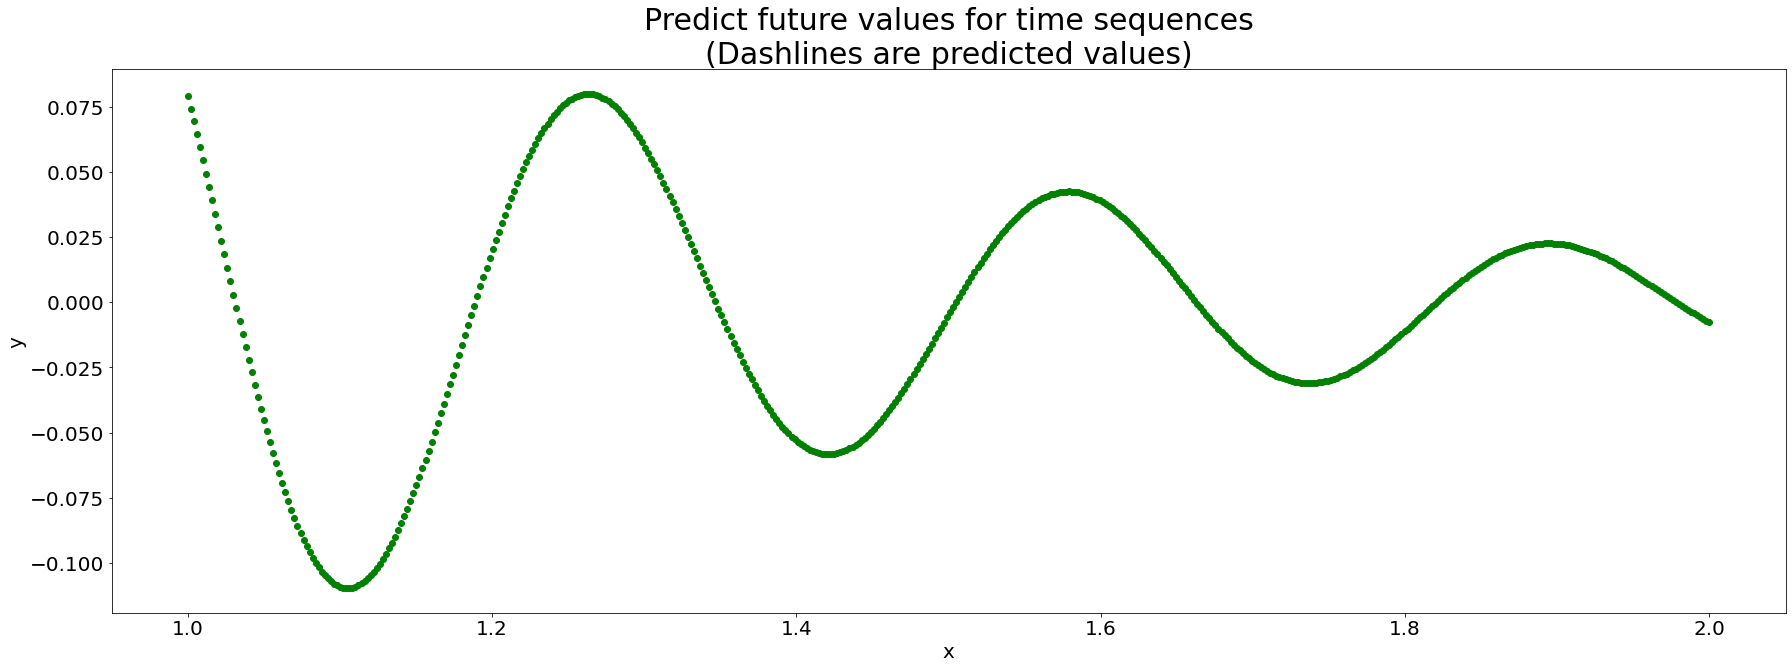

STEP:  75
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


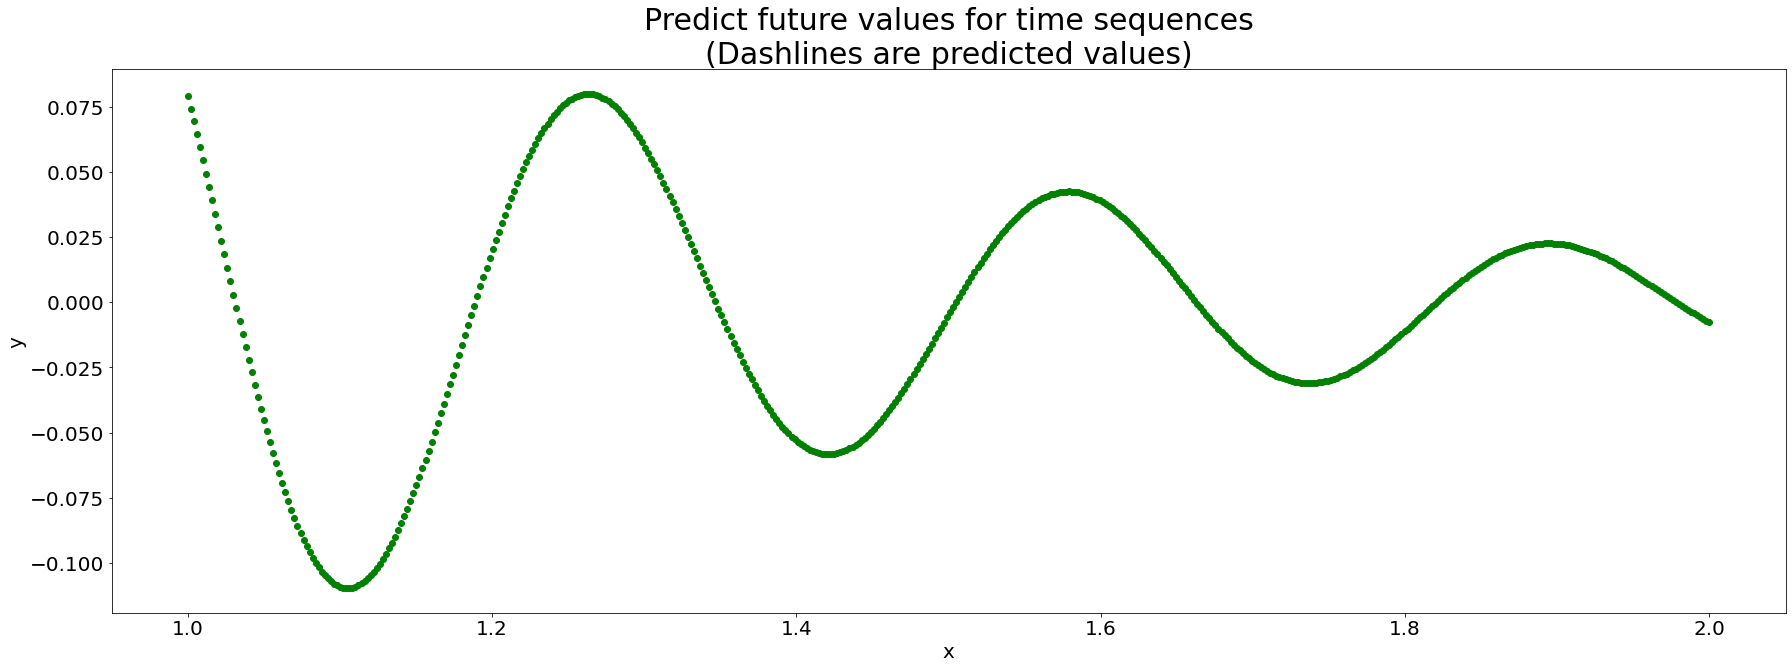

STEP:  76
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


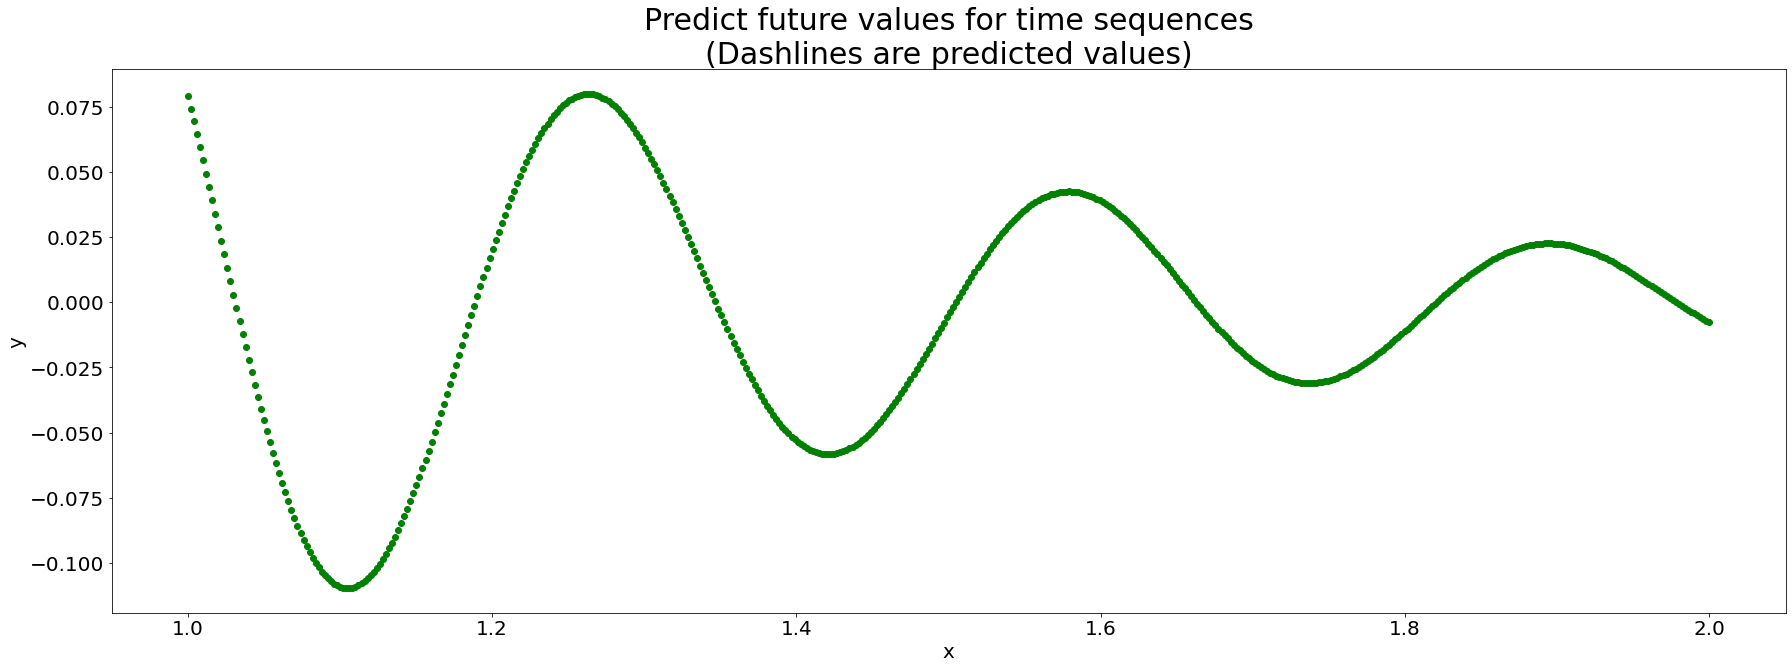

STEP:  77
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


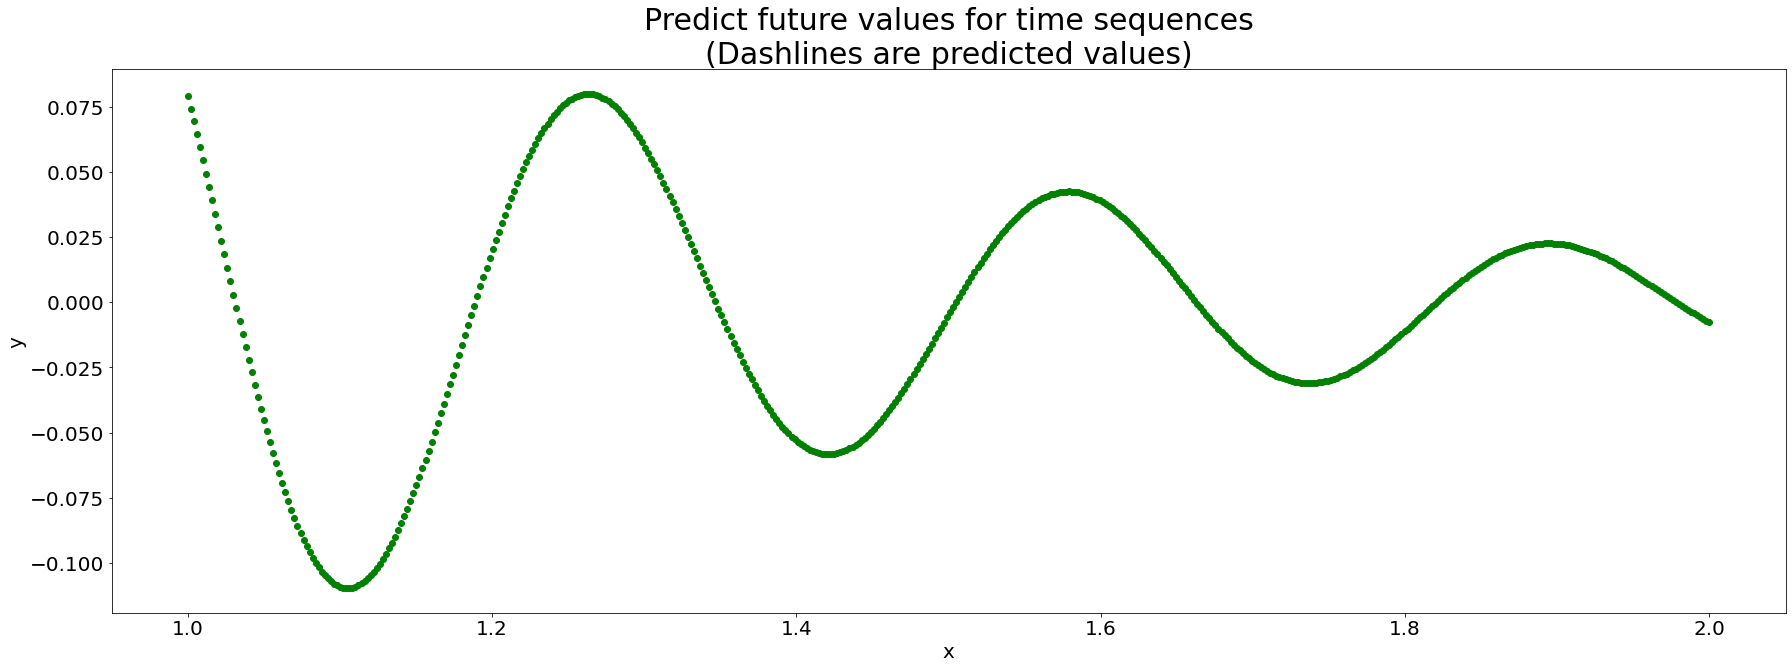

STEP:  78
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


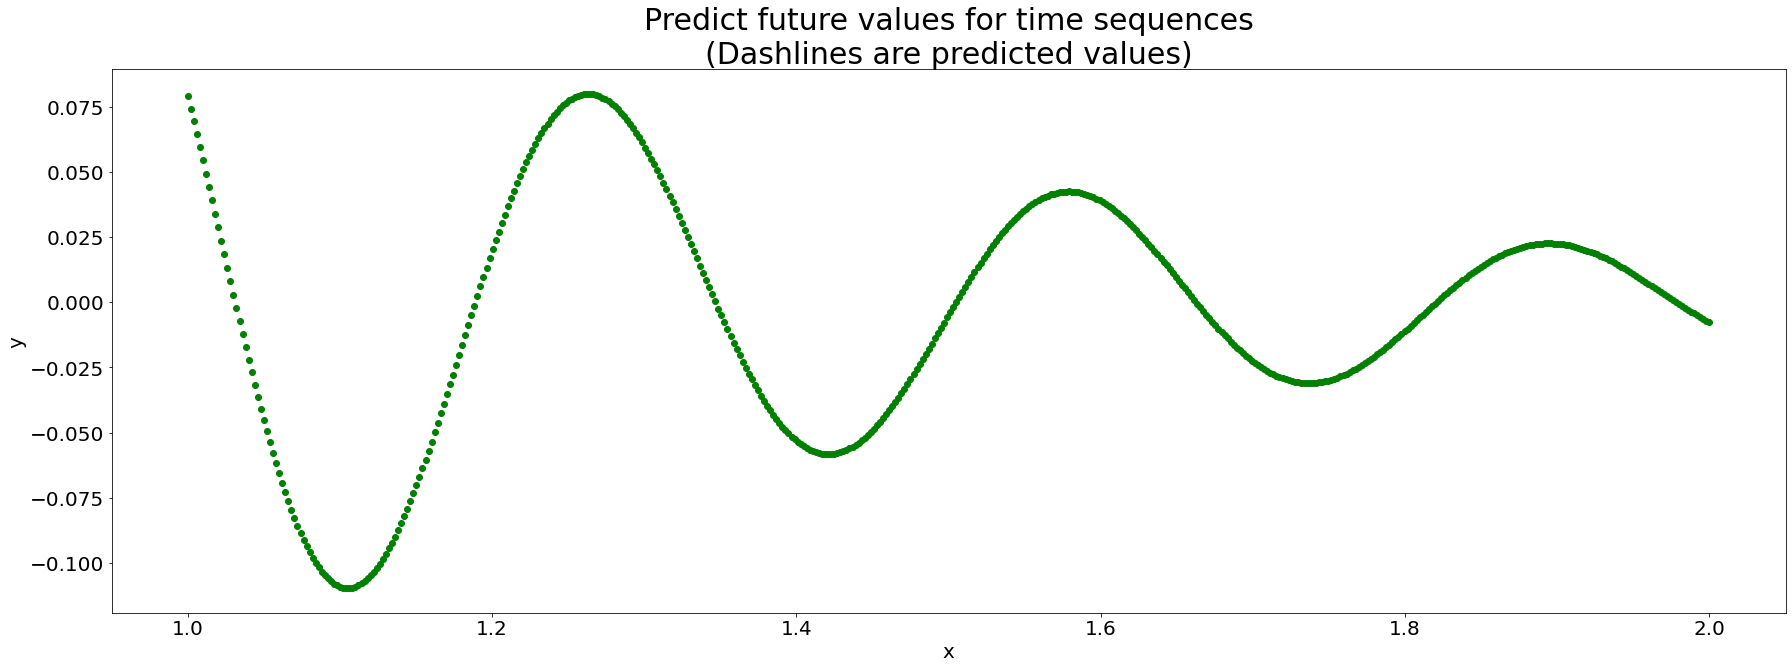

STEP:  79
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
Loss u: nan


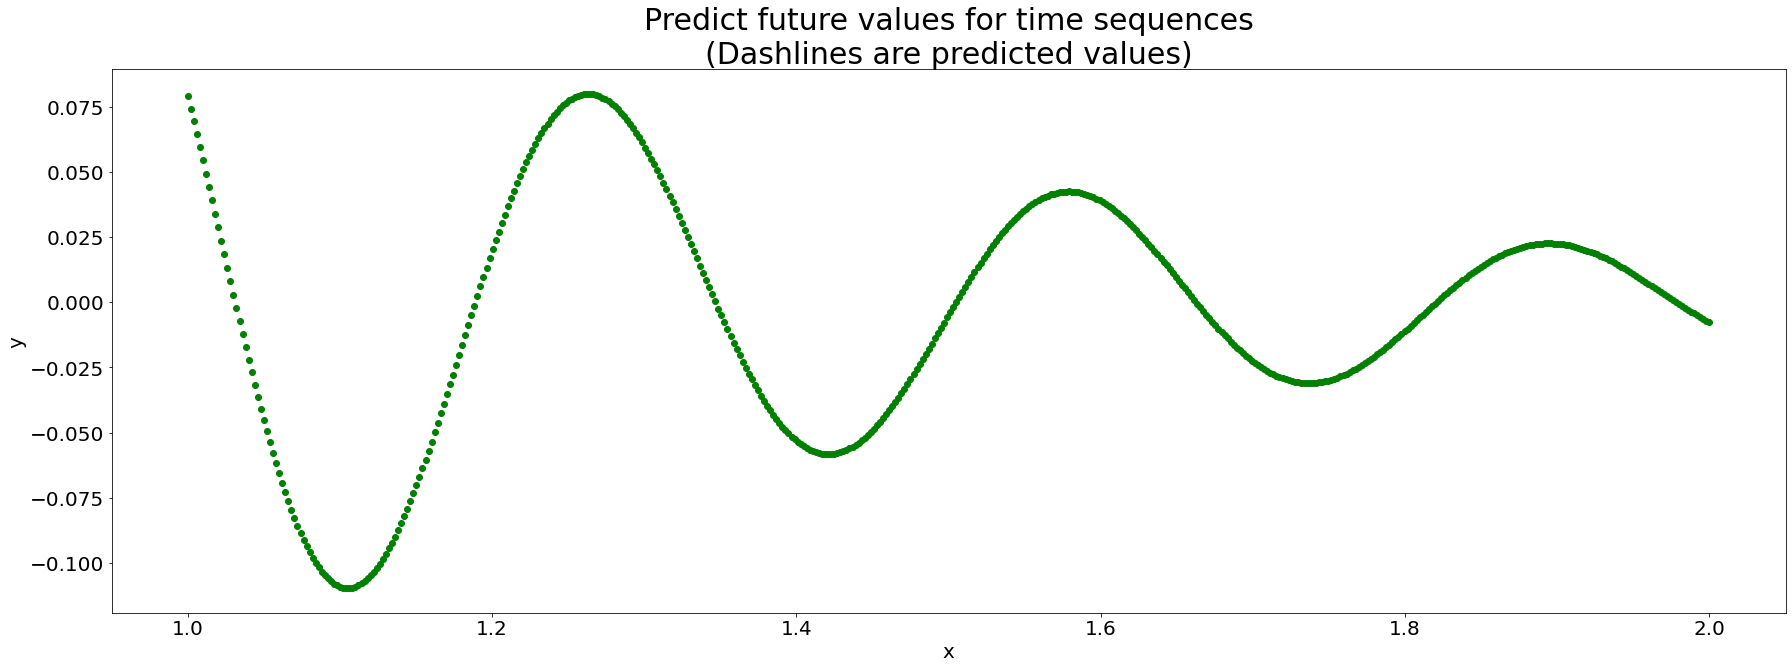

STEP:  80
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan


KeyboardInterrupt: 

In [13]:

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
inpu = y_with_noise[3:, :-1].to(device)
target =y_with_noise[3:, 1:].to(device)
test_input = y_with_noise[:3, :-1].to(device)
test_target = y_with_noise[:3, 1:].to(device)
# build the model
seq = PhysicsInformedNN()


#begin to train

for i in range(500):
    print('STEP: ', i)

    def closure():
        seq.dnn.optimizer.zero_grad()
    
        physics , u_pred , u_t , u_tt = seq.net_f(inpu)
        
        #c_i = u_pred[:,0]
        #ones= torch.ones_like(c_i)
        #loss_u_pred = torch.mean((ones - c_i)**2)
        #loss_u_t = torch.mean((u_t[:,0])**2)
        
        loss_u = torch.mean((target - u_pred)**2)
        # compute the "physics loss"
        loss_pde = (1e-9)*torch.mean(physics**2)
        
        loss = loss_u + loss_pde# + loss_u_pred #+ loss_u_t
    
        print('loss:', loss.item())
        loss.backward(retain_graph=True)
        return loss
    seq.dnn.optimizer.step(closure)


    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 500
        pred = seq.net_u(test_input, future_preds=future)
        loss_u = torch.mean((test_target - pred[:, :-future])**2)
        print('Loss u: %e'%(loss_u.item()))
        y = pred.detach().cpu().numpy()
    
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    d_t=len(y[0])
    plt.scatter(np.linspace(0,2,d_t), y[0], linewidth = 2.0)
    plt.scatter(x_test[1],y_test[1],color="g")
    #plt.savefig('plots_lstm/predict%d.jpg'%i)
    plt.show()
    plt.close()